<a href="https://colab.research.google.com/github/Alanjul/StatisticalLearning/blob/main/predictFinalGrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import  StandardScaler, RobustScaler #for scaling the data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore") #ignore all warnings


Load DataSets

In [10]:
from google.colab import files
uploaded = files.upload()
data = pd.read_csv("student-mat_.csv")
print(data.head(15))
print(data.shape)

#filling in the missing values
for column in data.columns:
    if data[column].dtype == 'object':
        data[column].fillna(data[column].mode()[0], inplace=True) #most frequent
    else:
        data[column].fillna(data[column].median(), inplace=True)
#checking for missing values
print(data.info())
missing_values = data.isnull().sum()
print(missing_values)

#checking for unique values of each feature in the dataset
for column in data.columns:
    print("Unique values for ", column)
    print(data[column].unique())
    print("-"*20)
print(data.shape)

#get all categorical_columns
categorical_columns = data.select_dtypes(include=["object"]).columns
print(categorical_columns)
print("..................")
#Convert categorical values into dummies
dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
print(dummies.columns)
print(dummies.shape)
print("-----dummies------------")
#concatenate data across columns
data = pd.concat([data.drop(categorical_columns, axis=1), dummies], axis=1)
print(data.shape)
print(data.columns)

Saving student-mat_.csv to student-mat_ (1).csv
   school  sex   age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0      GP    F  18.0       U     GT3       A     4     4   at_home   teacher   
1      GP    F  17.0       U     GT3       T     1     1   at_home     other   
2      GP    F  15.0       U     LE3       T     1     1   at_home     other   
3      GP    F  15.0       U     GT3       T     4     2    health  services   
4      GP    F  16.0       U     GT3       T     3     3     other     other   
5      GP    M  16.0       U     LE3       T     4     3  services     other   
6      GP    M  16.0       U     LE3       T     2     2     other     other   
7      GP    F  17.0       U     GT3       A     4     4     other   teacher   
8      GP    M  15.0       U     LE3       A     3     2  services     other   
9      GP    M  15.0       U     GT3       T     3     4     other     other   
10     GP    F  15.0       U     GT3       T     4     4   teacher    he

DATA VISUALIZATION WITH CORRELATION MAP

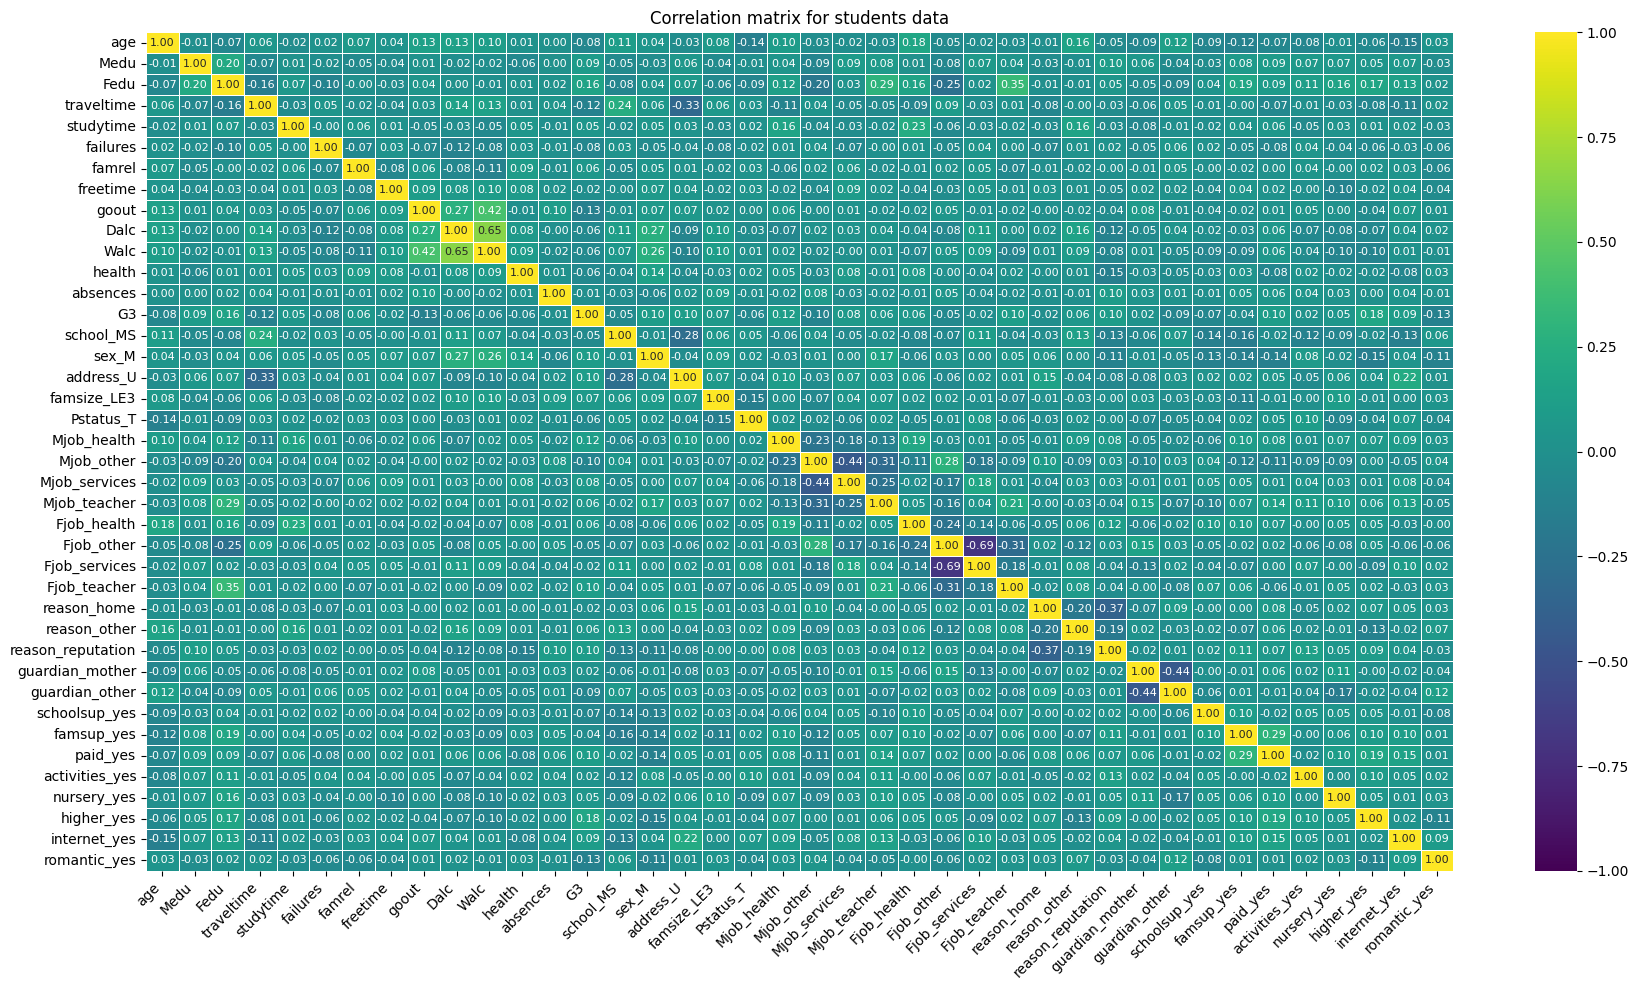

In [34]:
corr_matrix = data.corr(method="pearson")
plt.figure(figsize=(18, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", vmin=-1, vmax=1, linewidth=0.5, cmap="viridis",
            annot_kws={"size": 8})  # smaller font size for annotations
plt.title("Correlation matrix for students data")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.grid(False)
plt.tight_layout()
plt.show()

#visualization of the data withboxplot and scatter plot

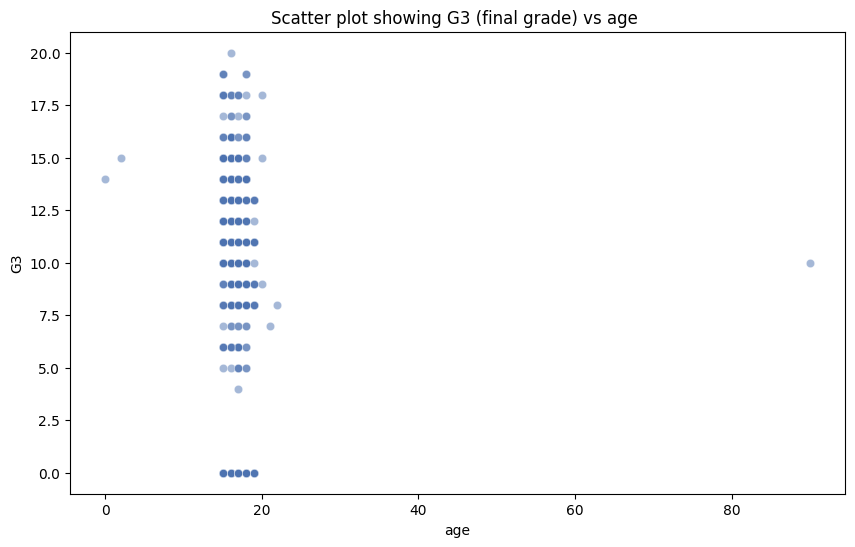

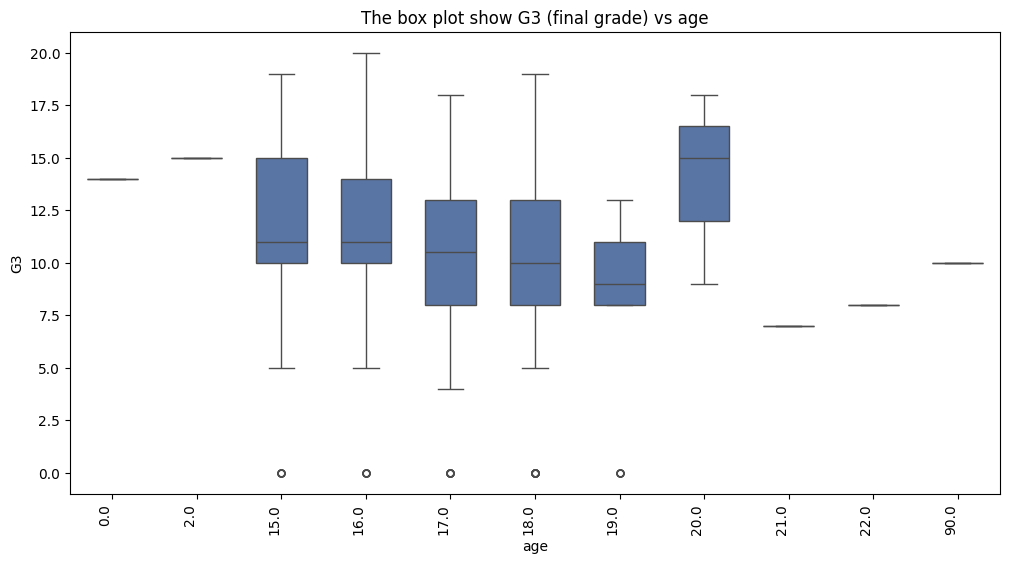

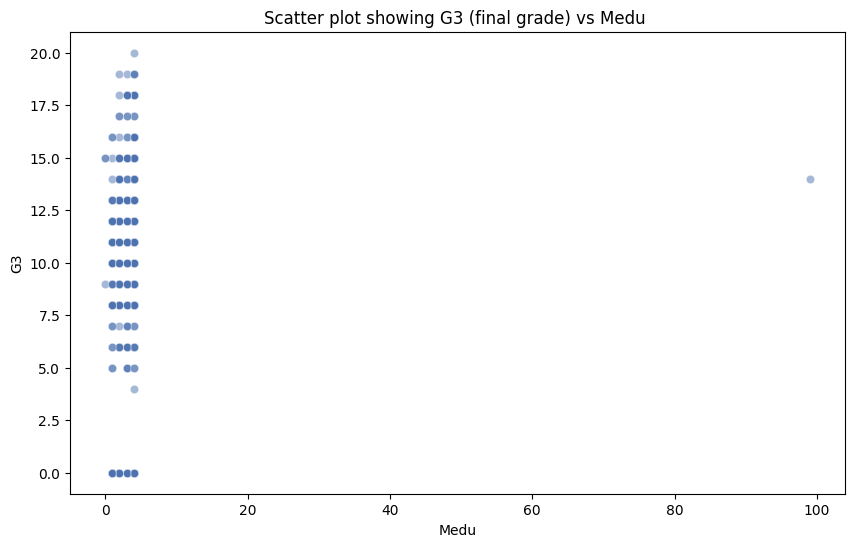

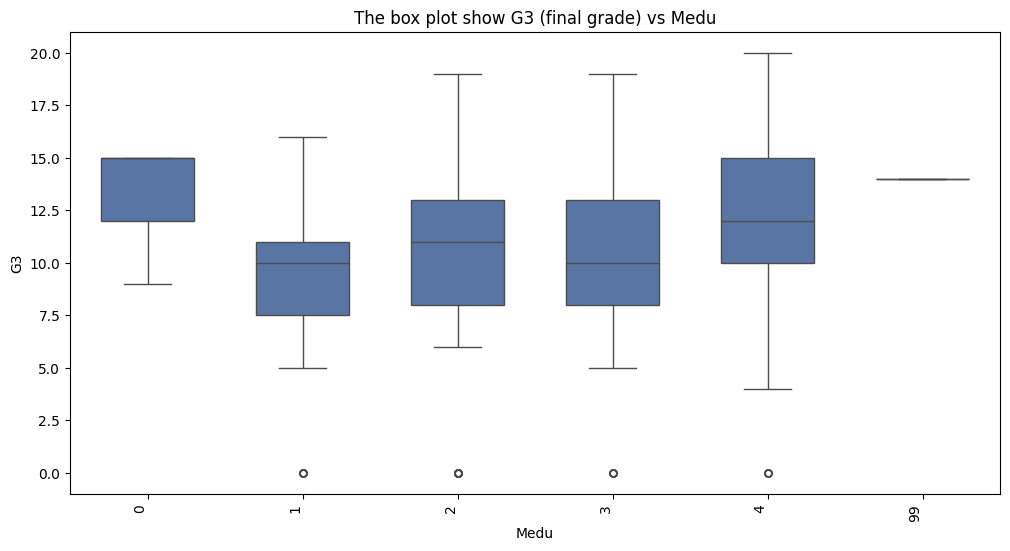

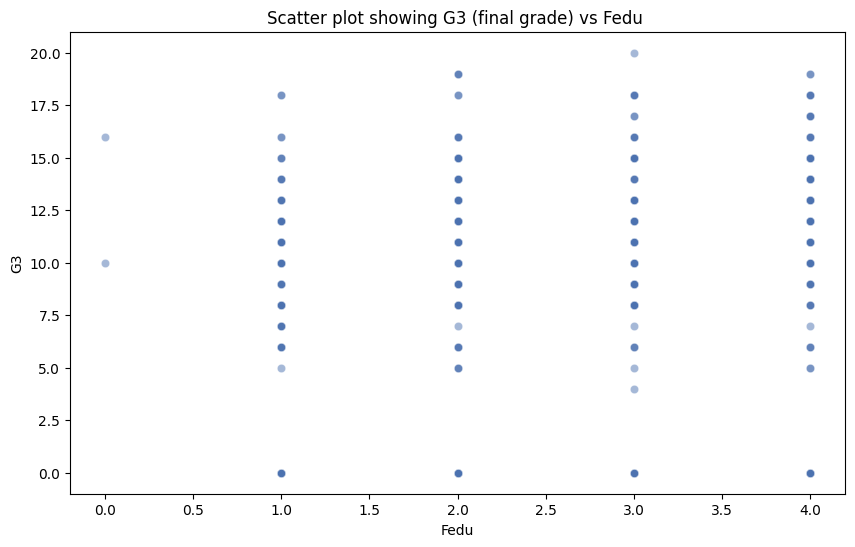

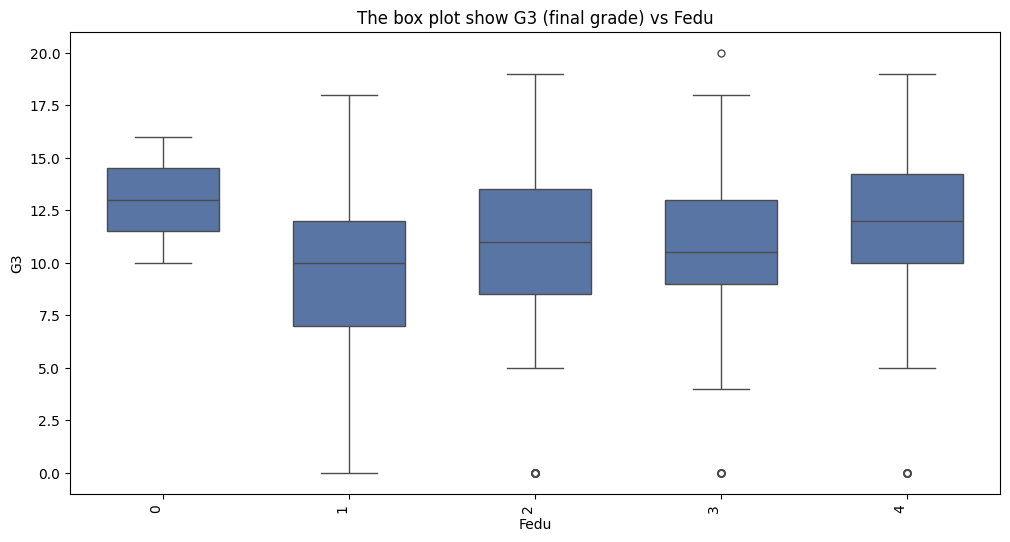

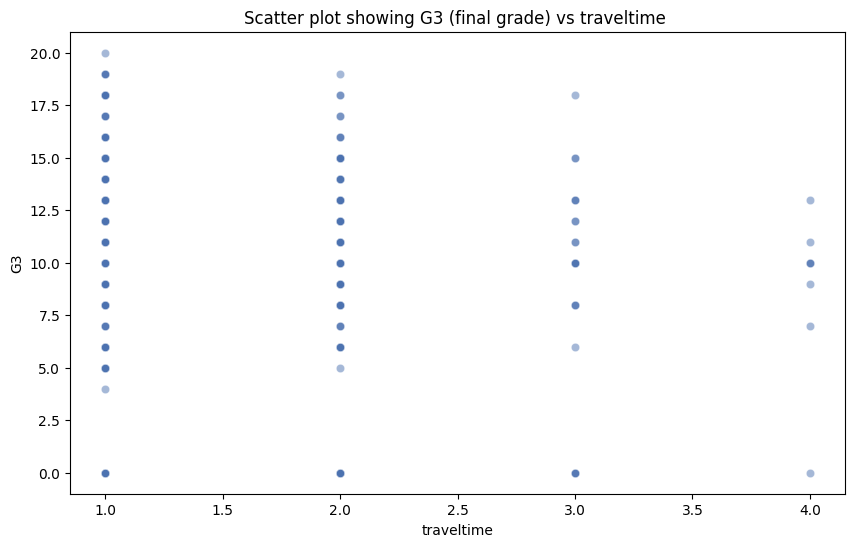

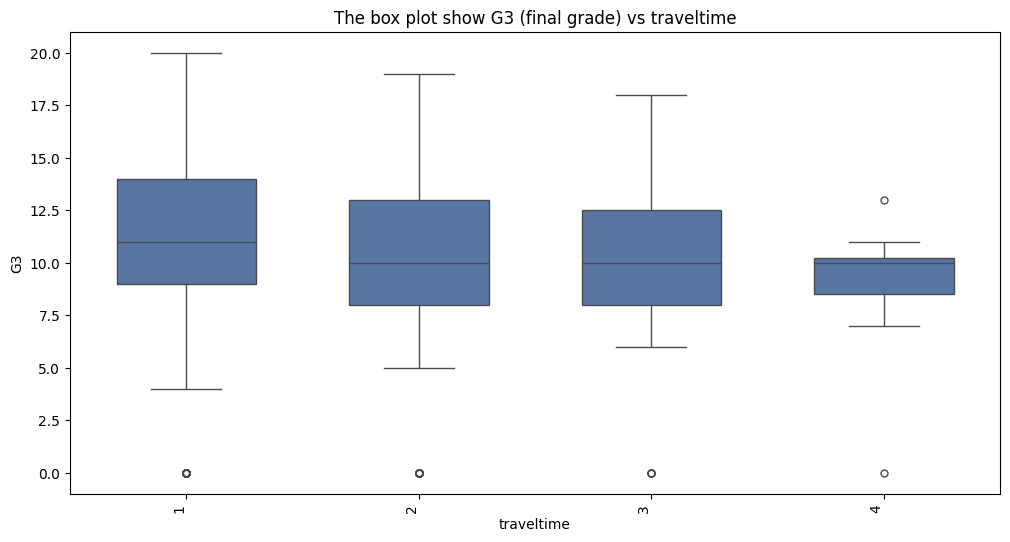

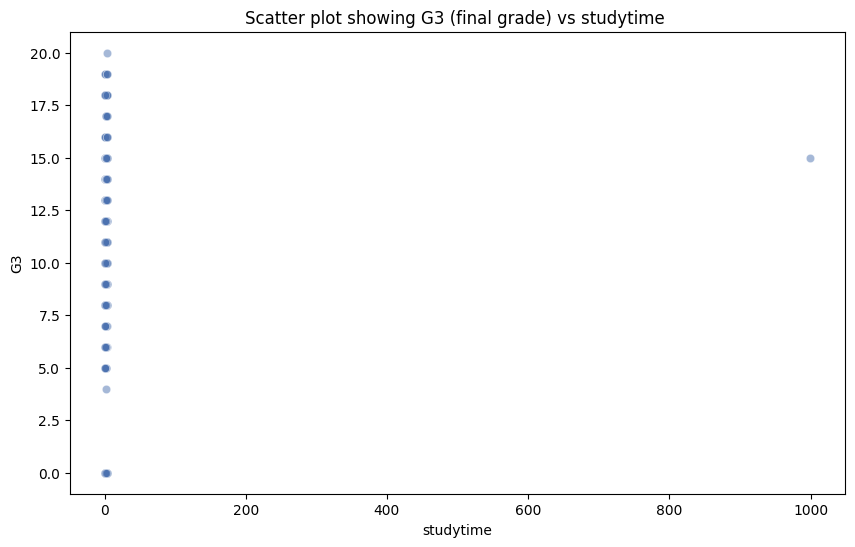

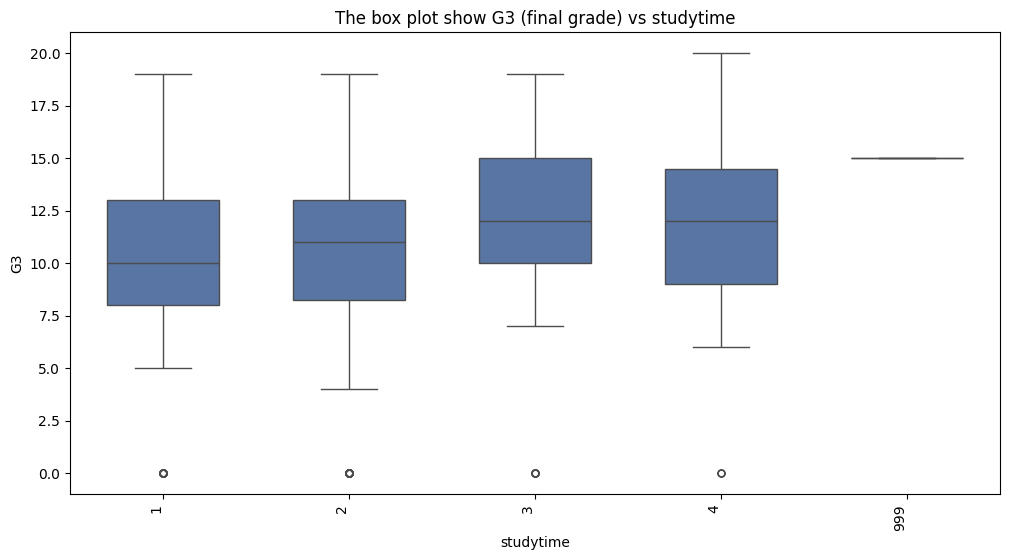

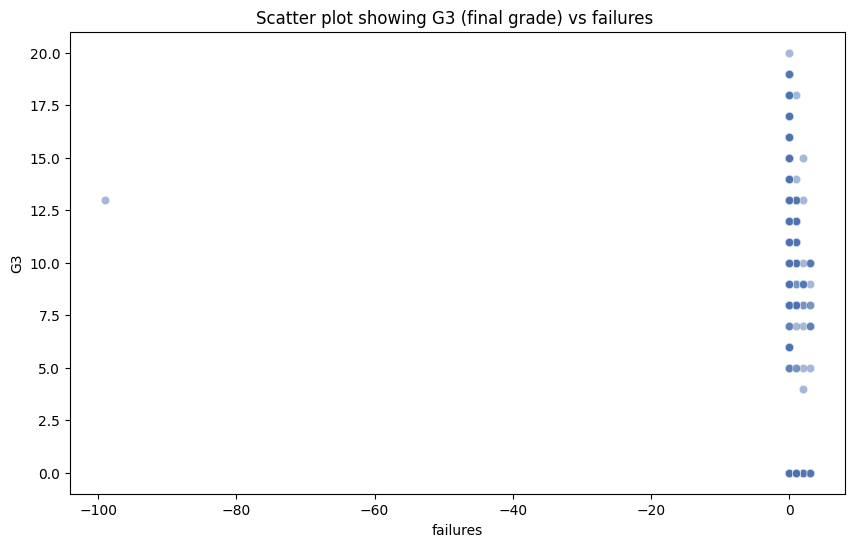

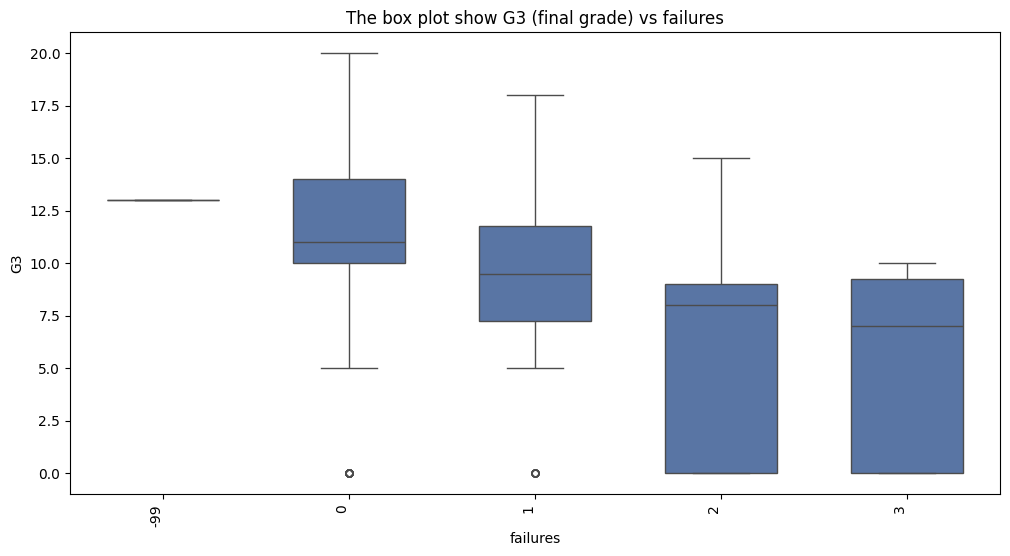

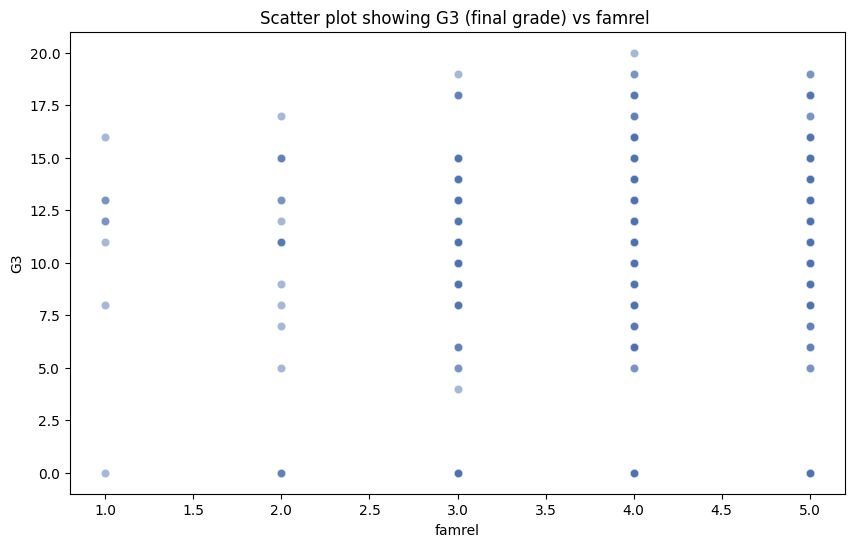

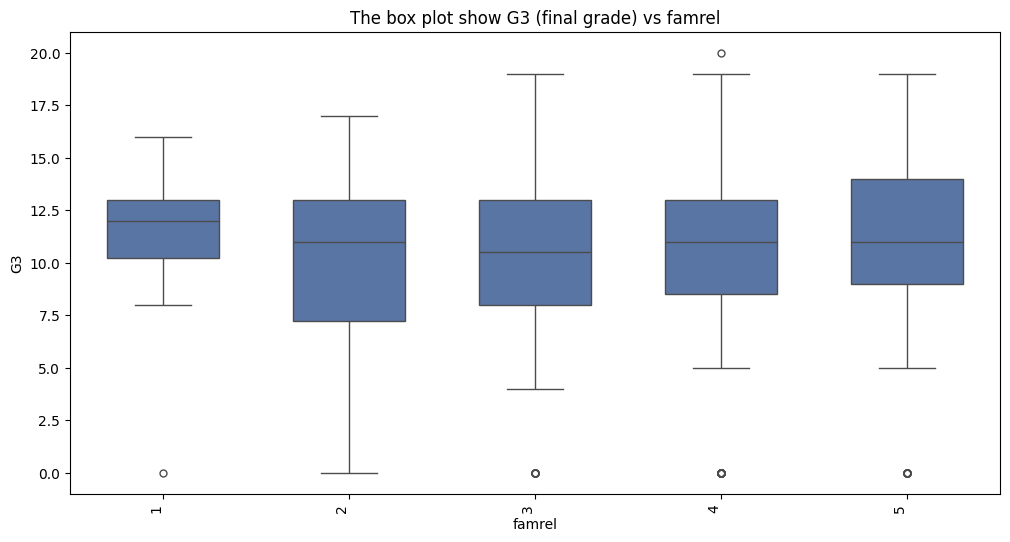

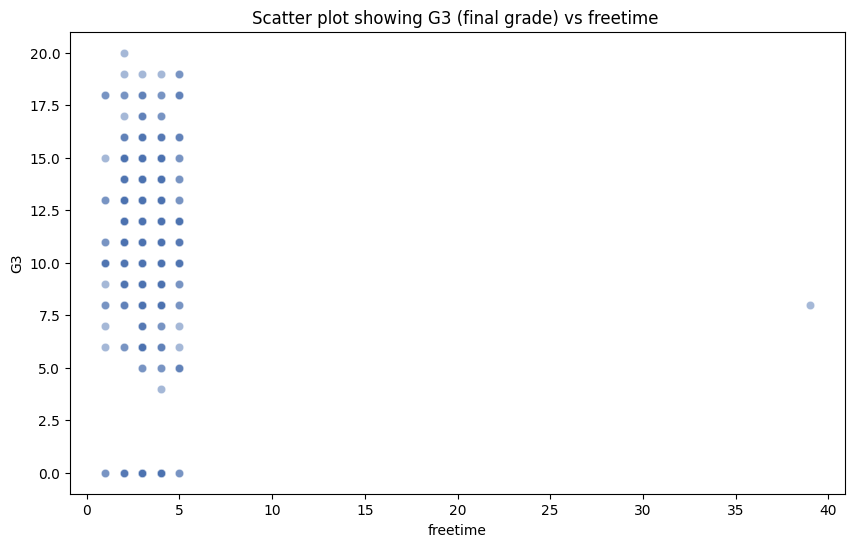

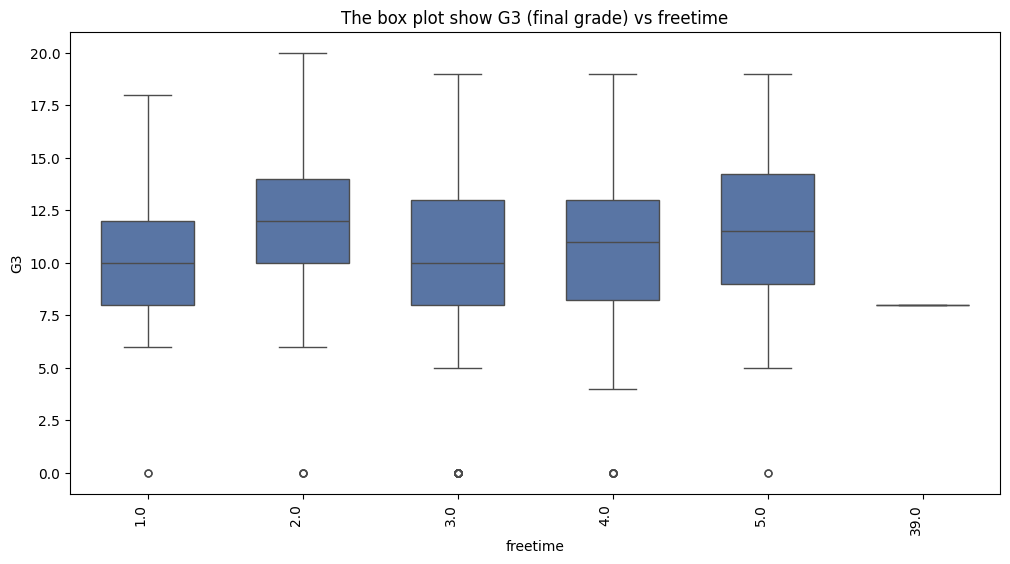

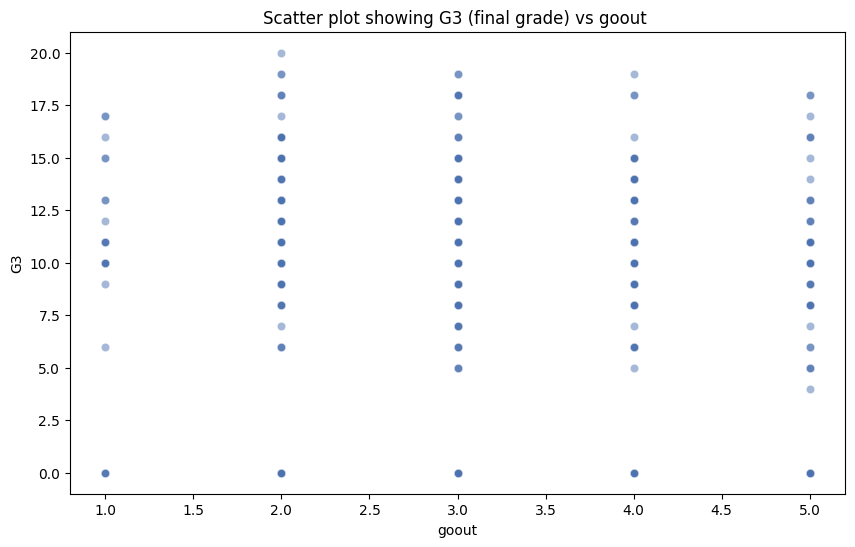

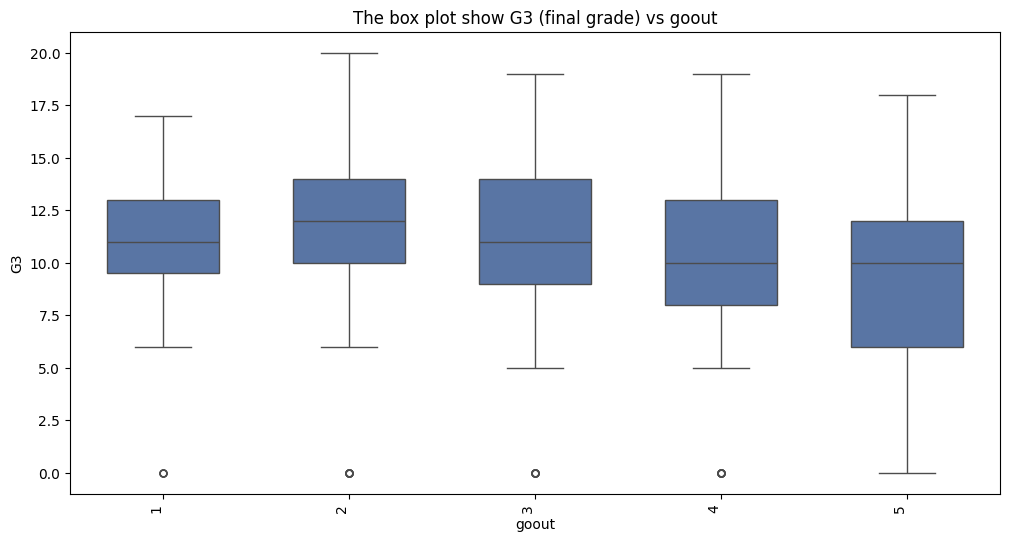

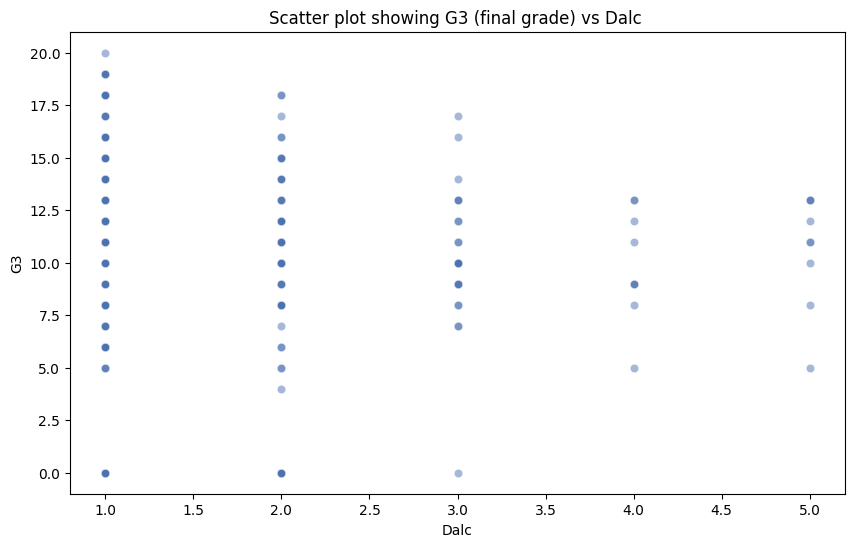

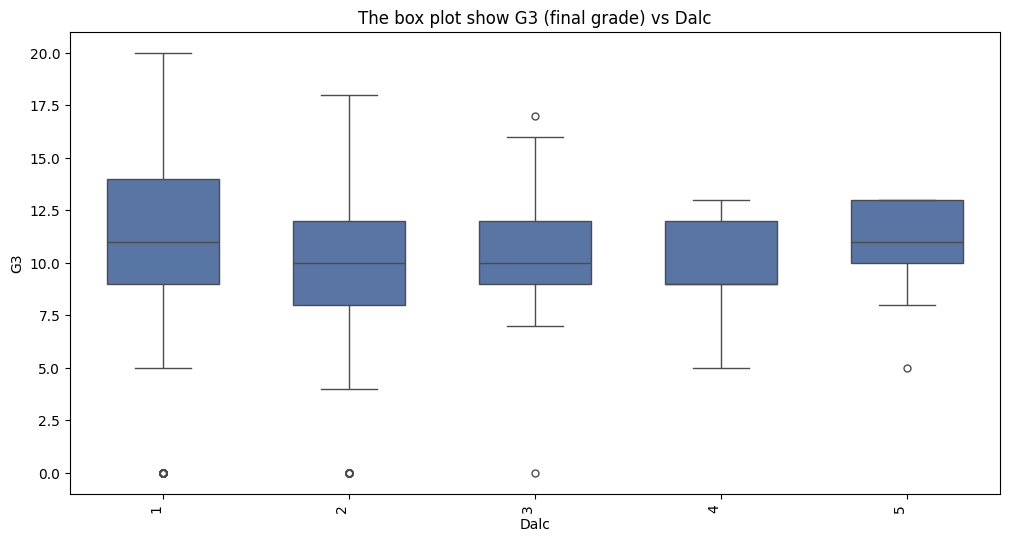

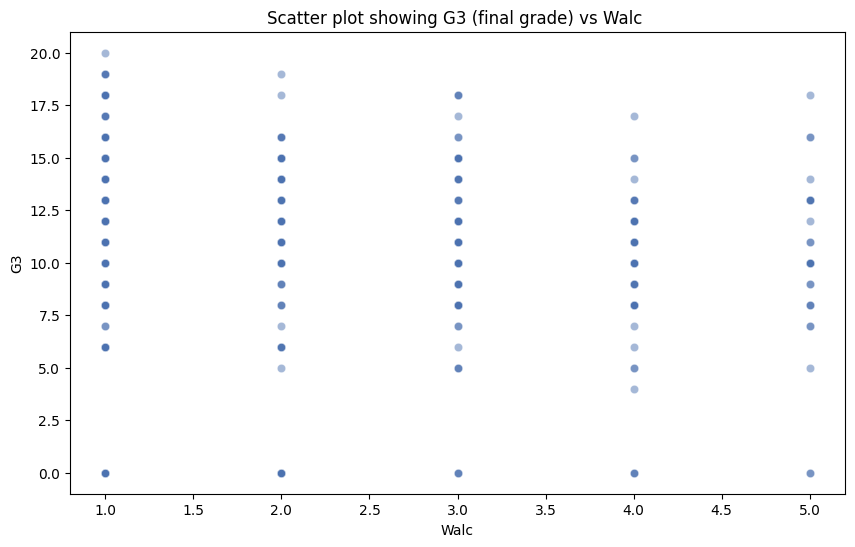

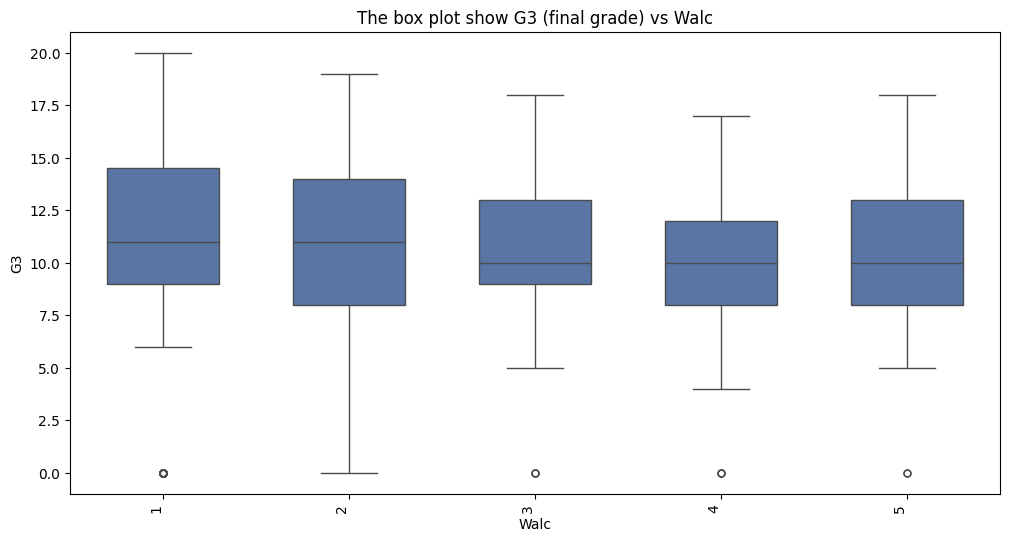

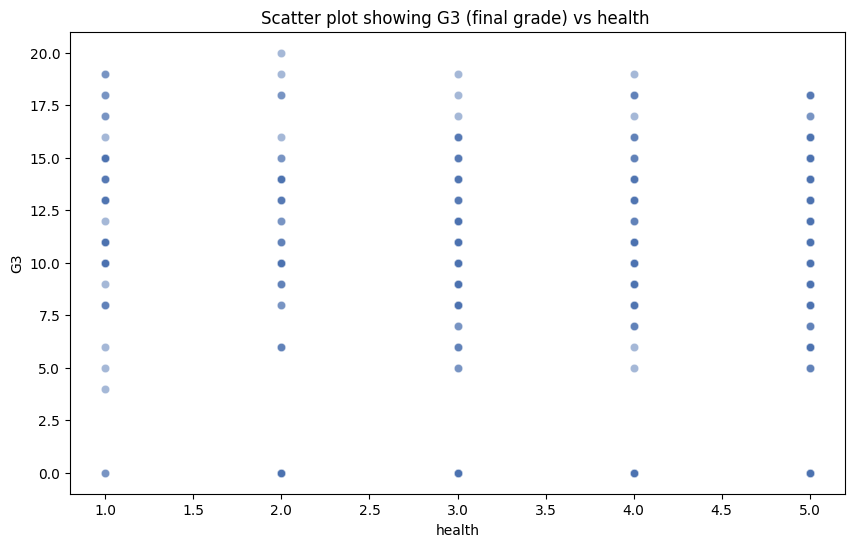

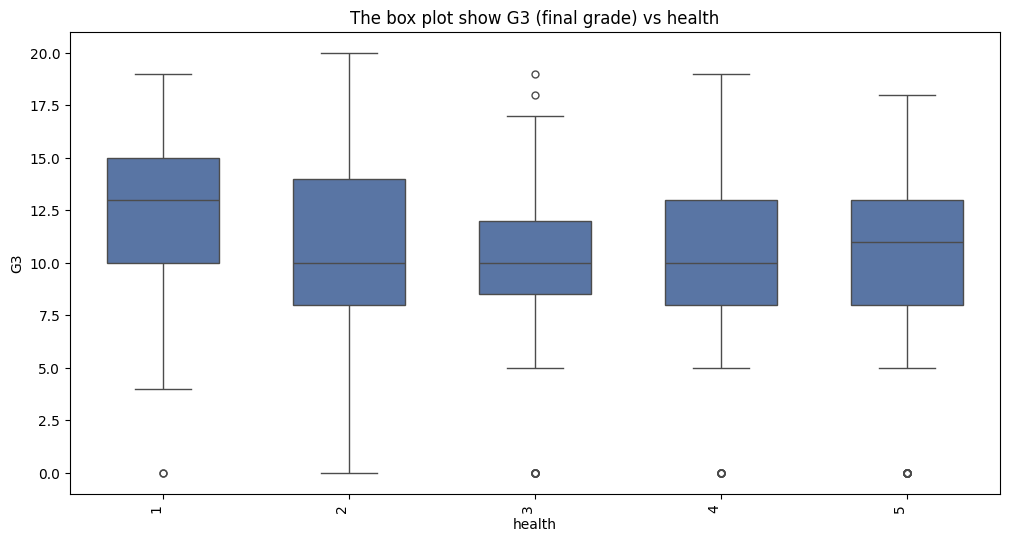

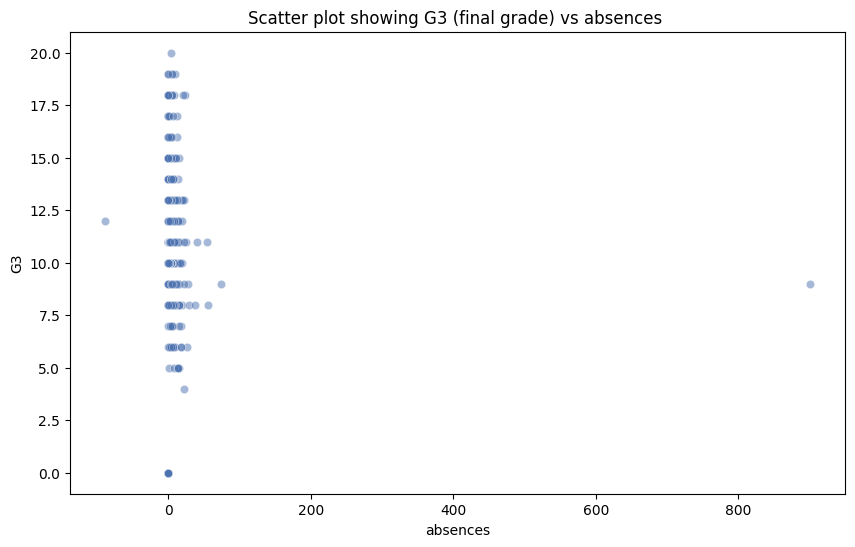

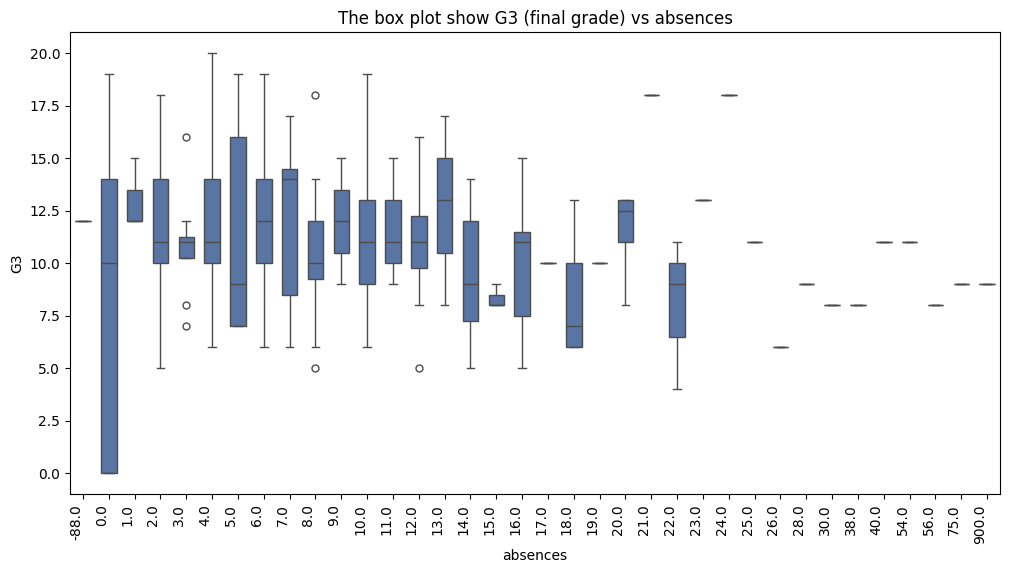

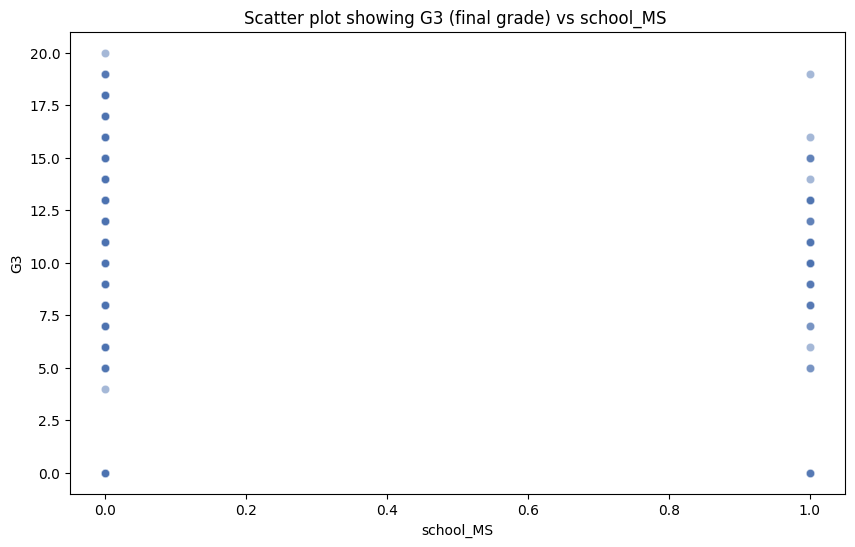

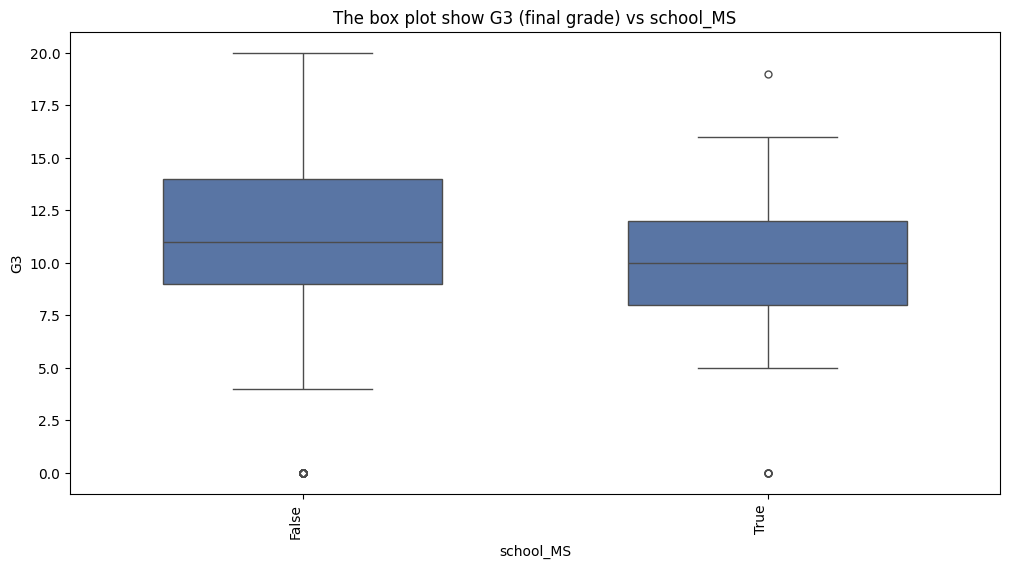

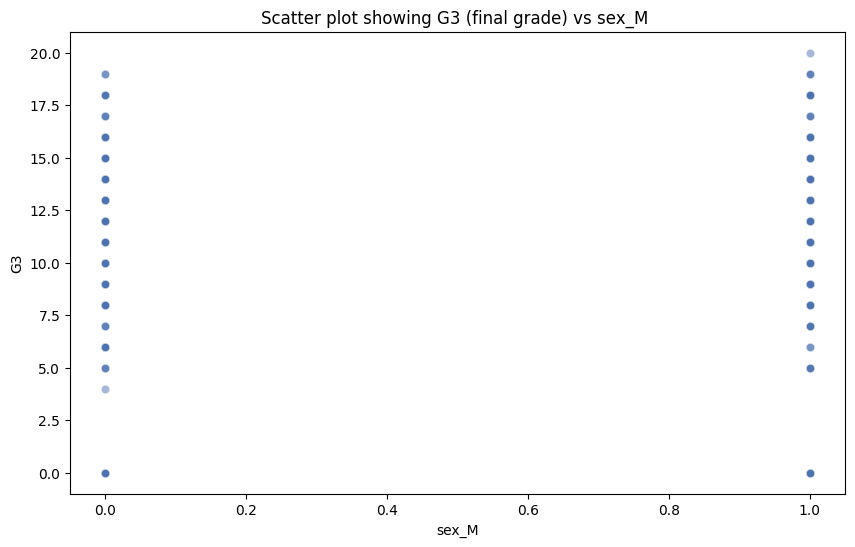

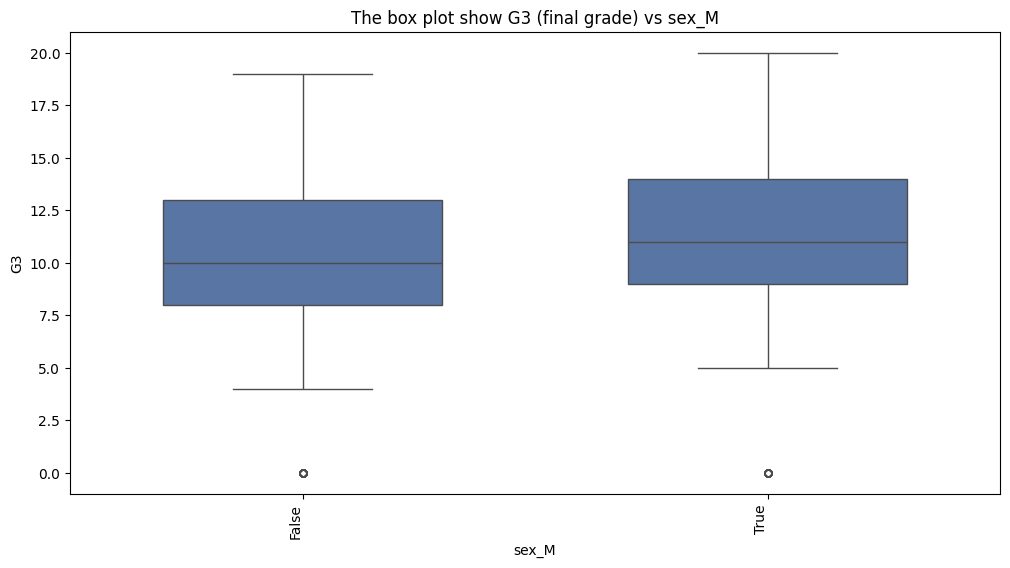

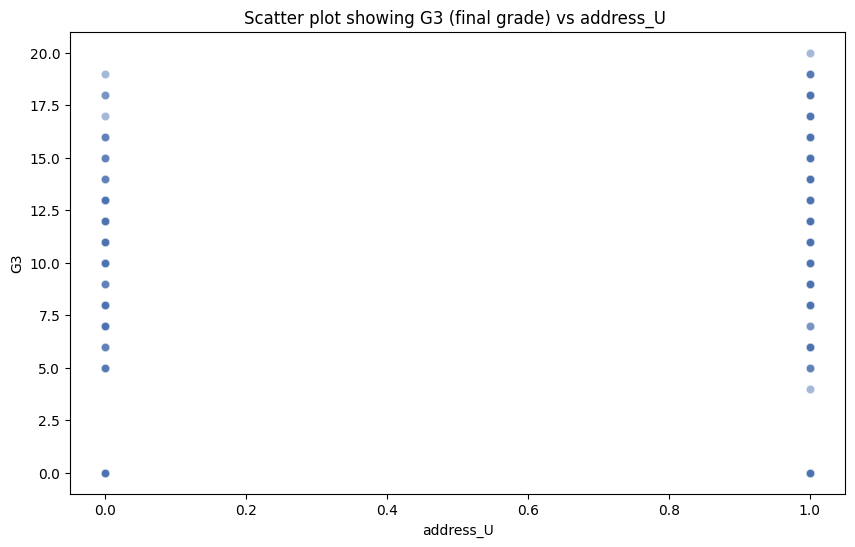

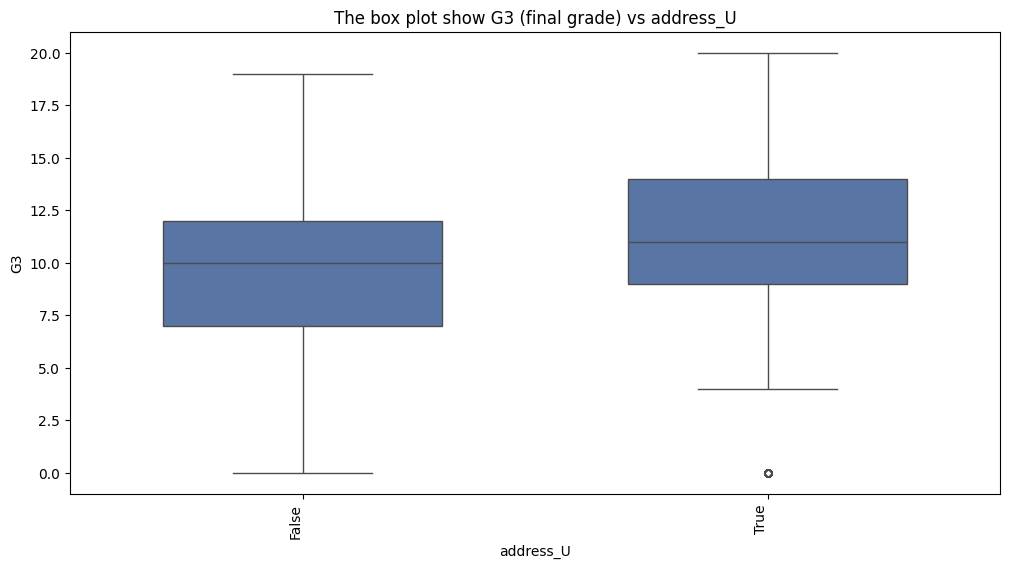

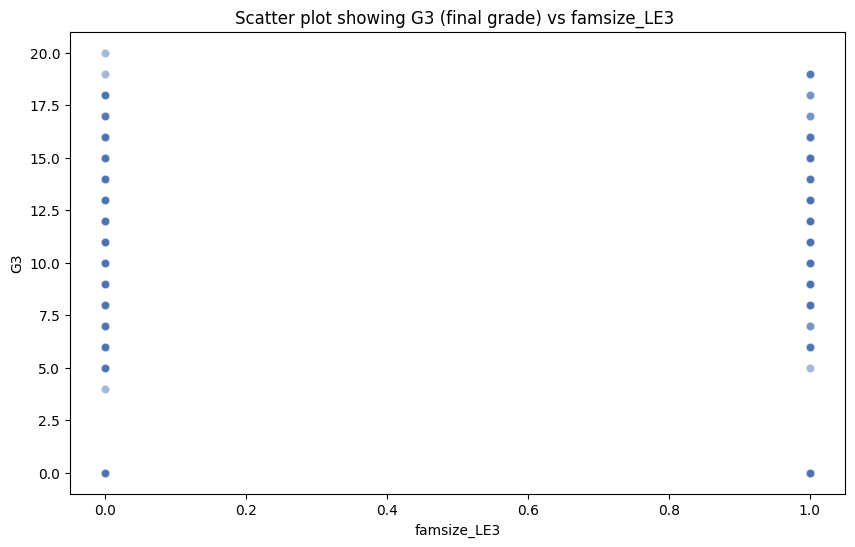

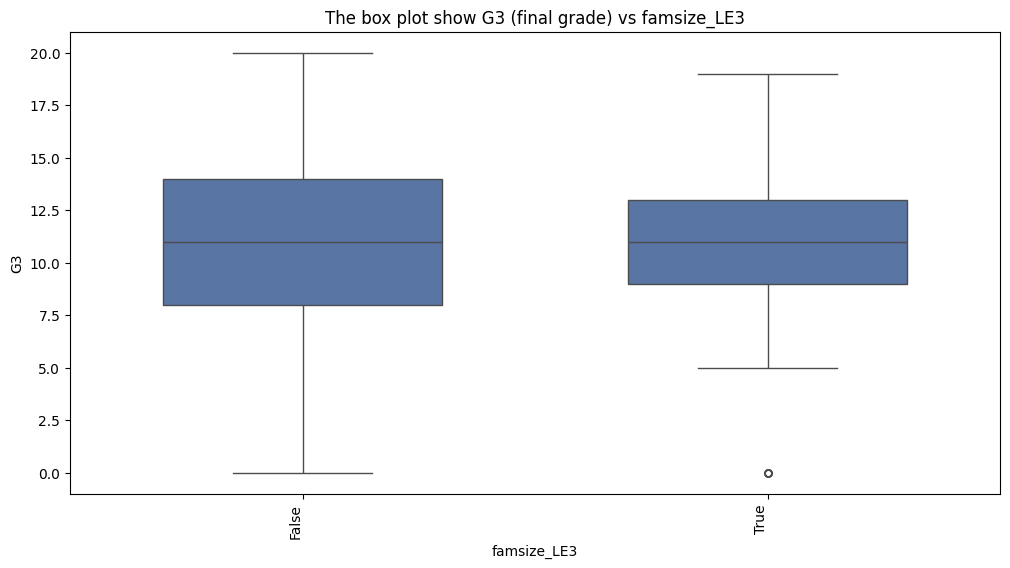

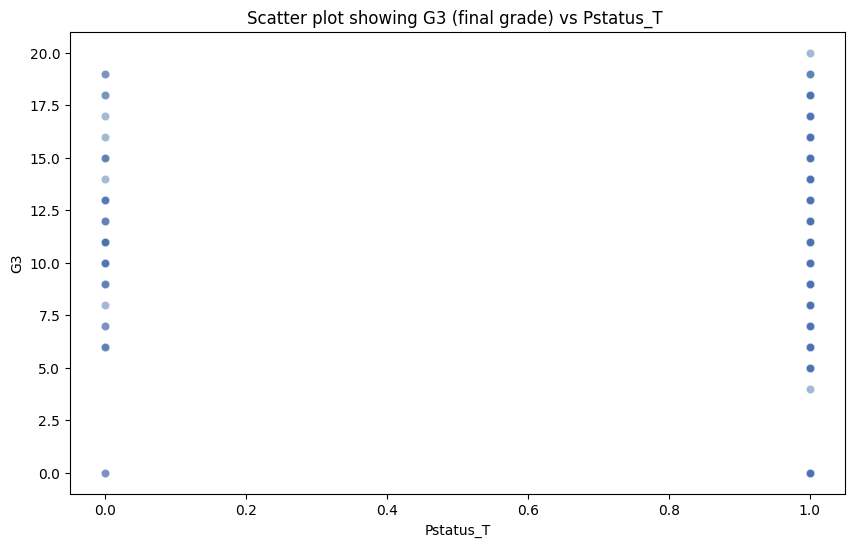

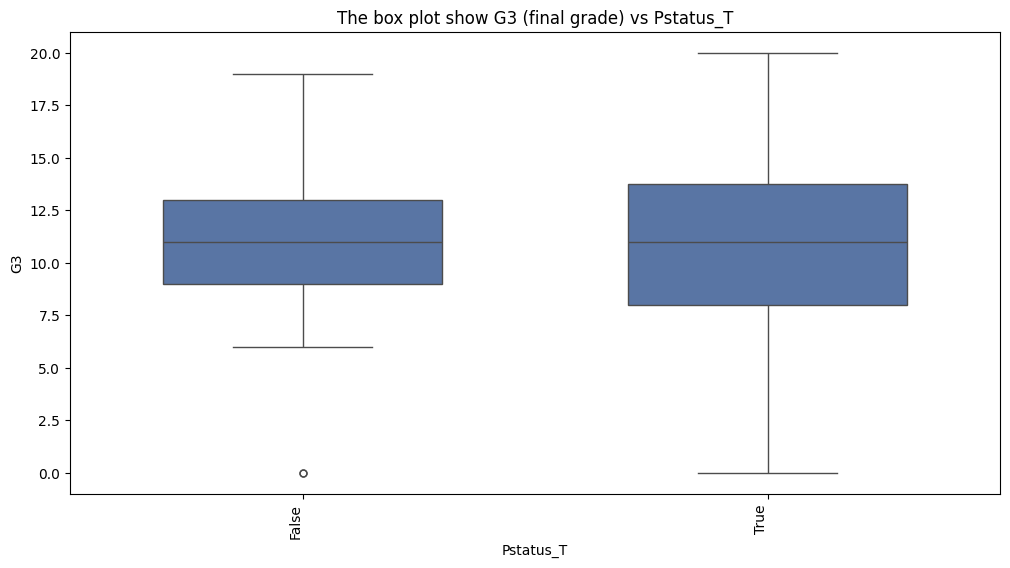

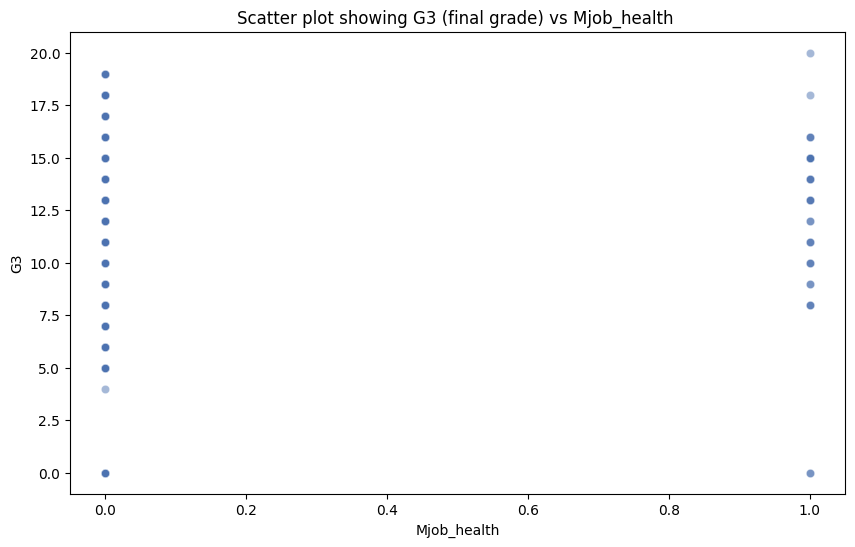

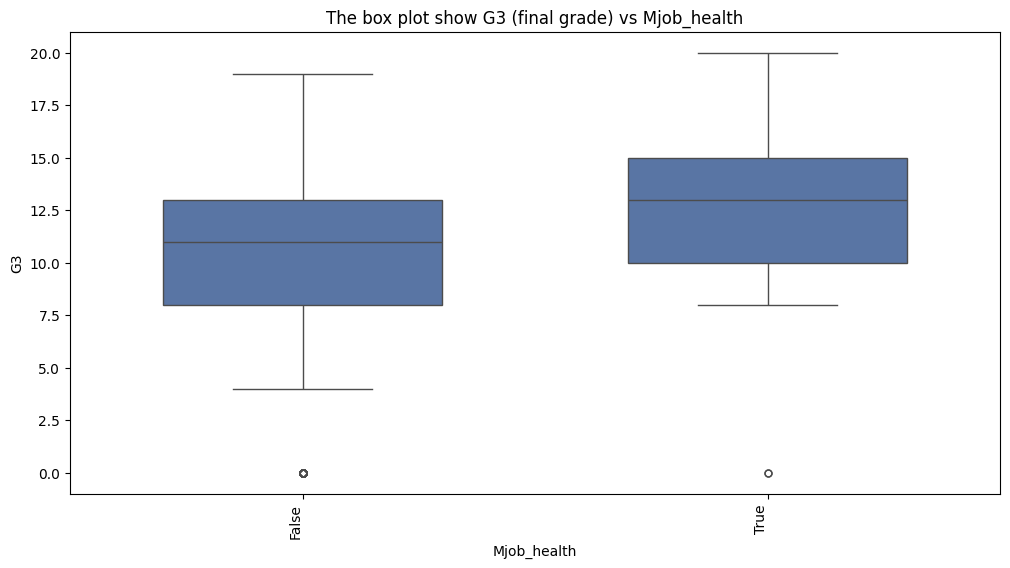

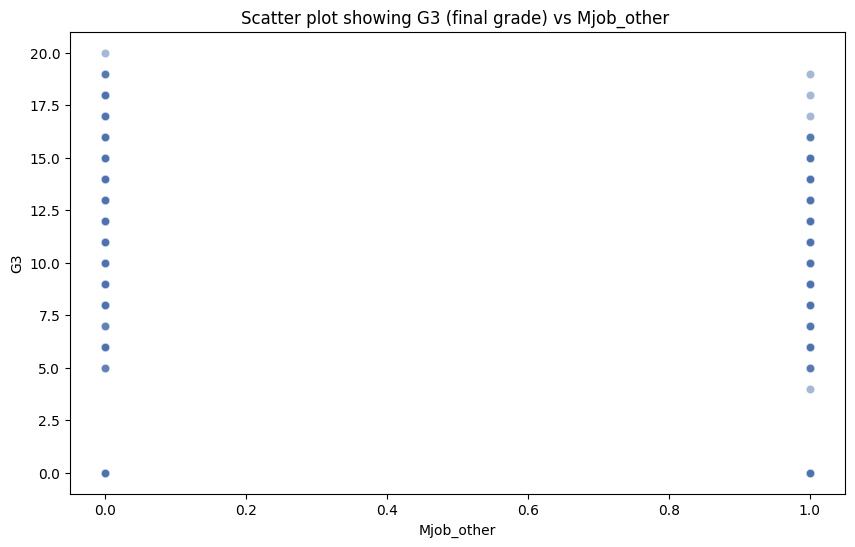

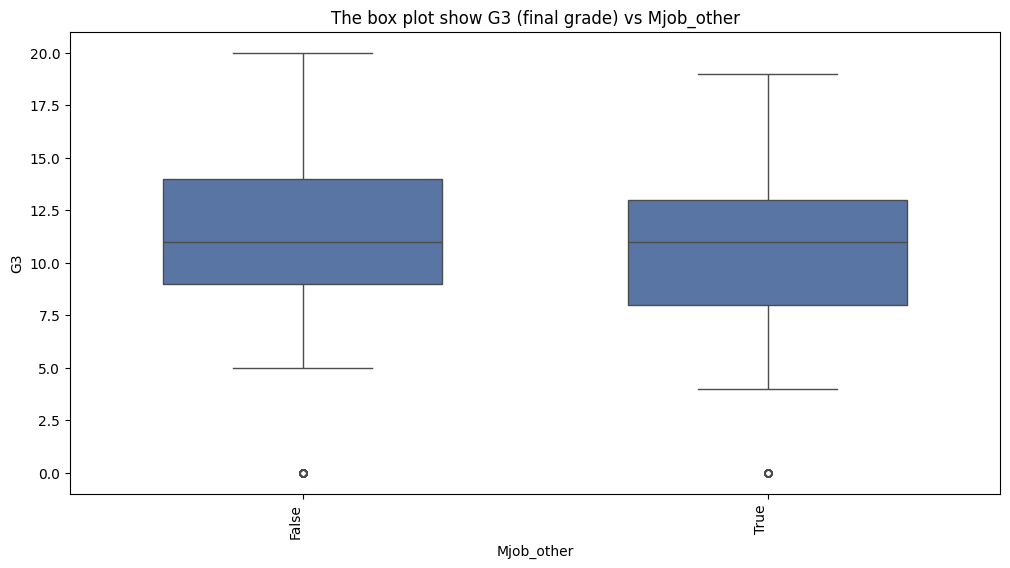

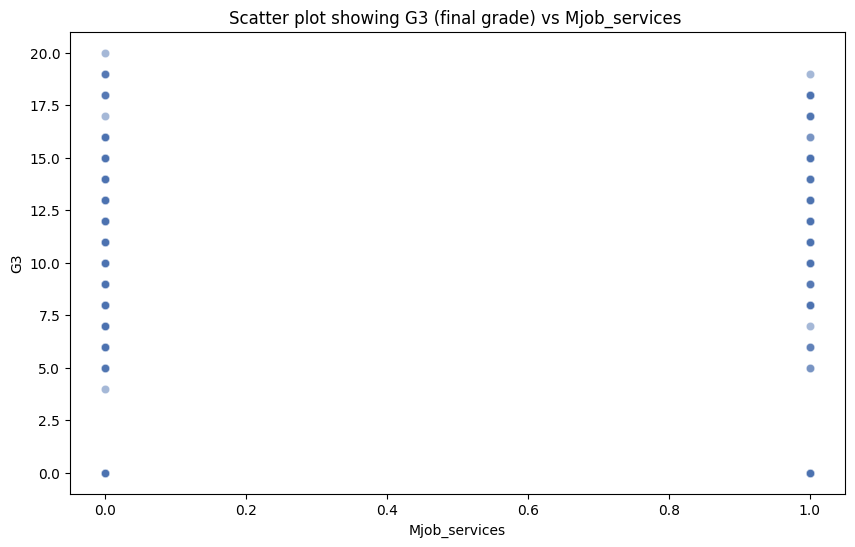

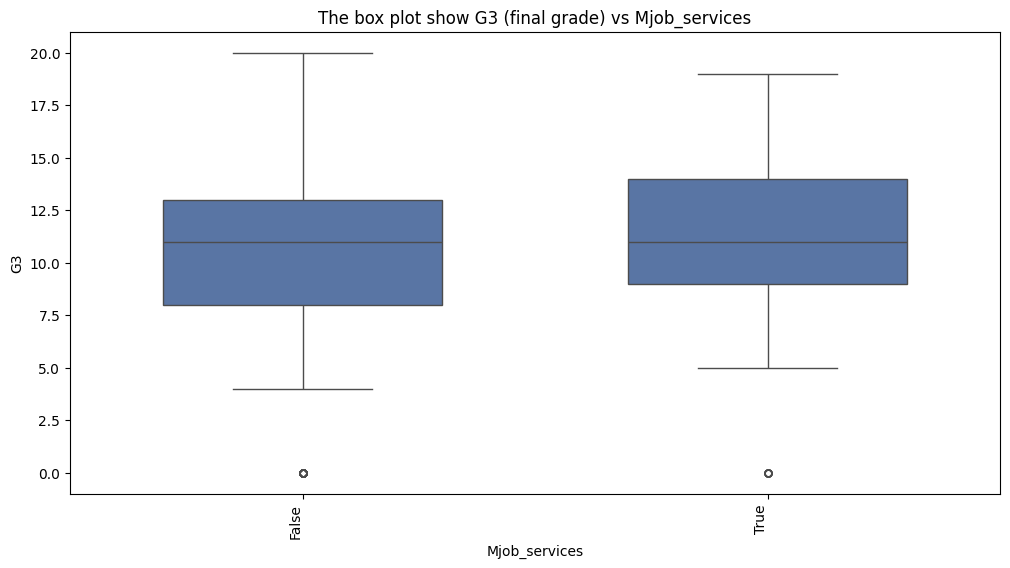

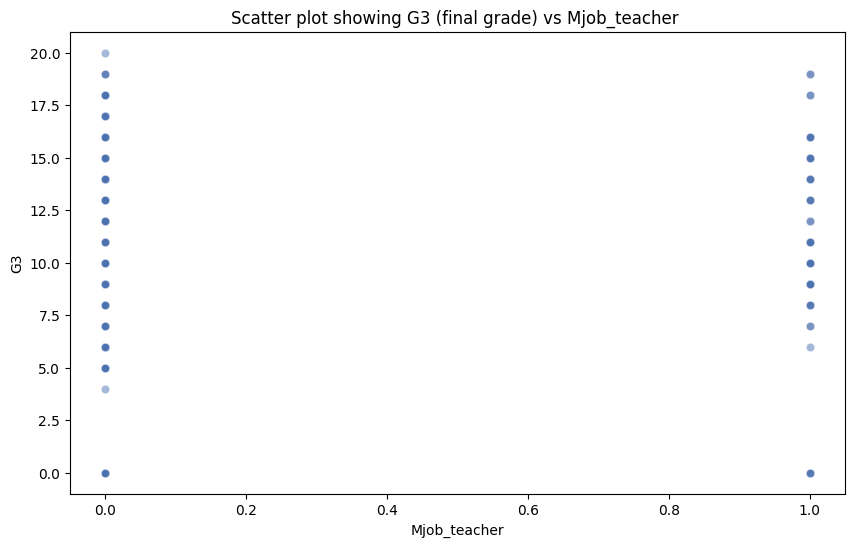

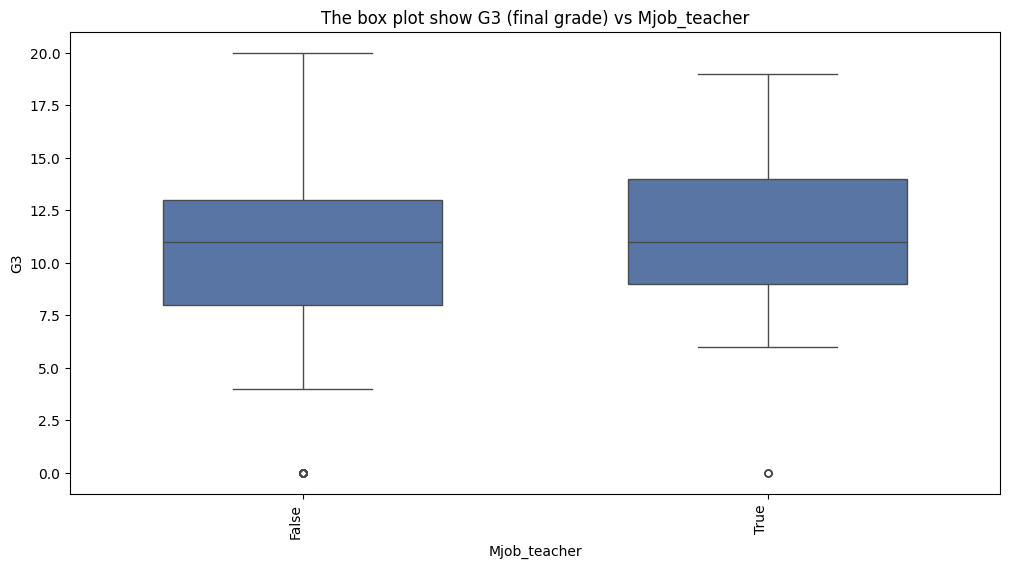

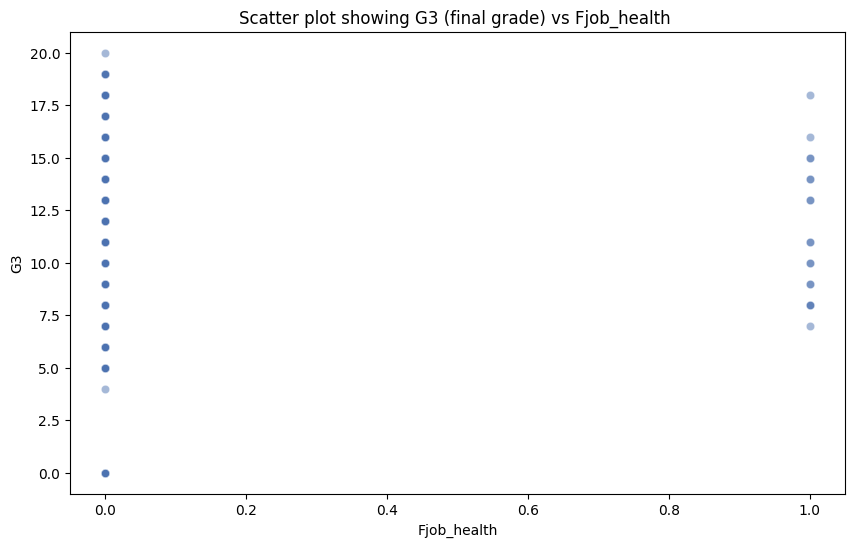

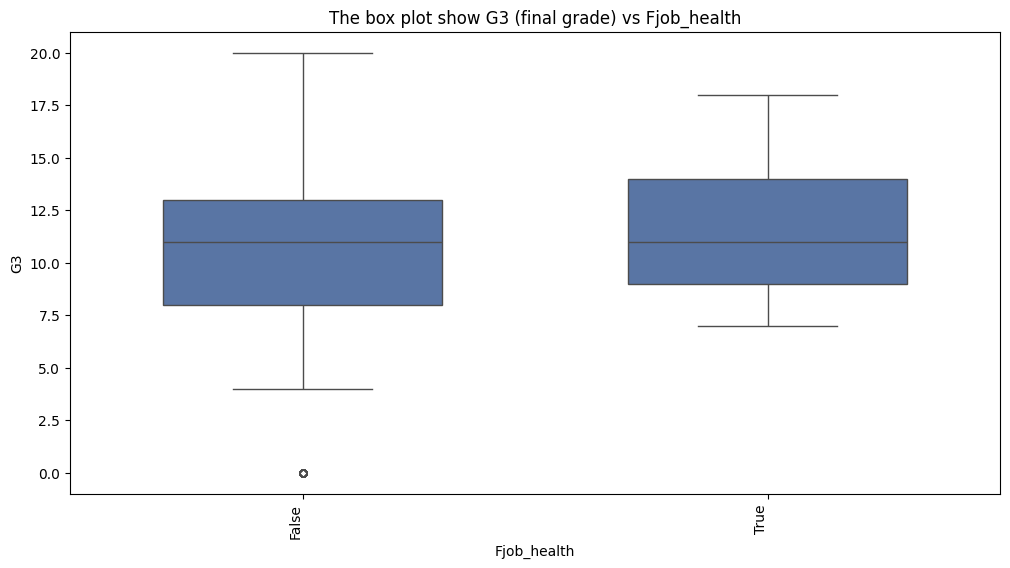

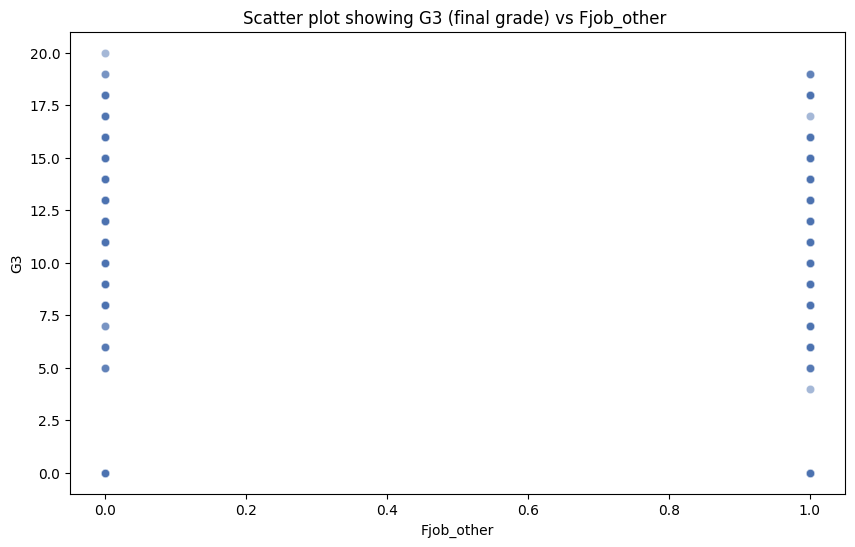

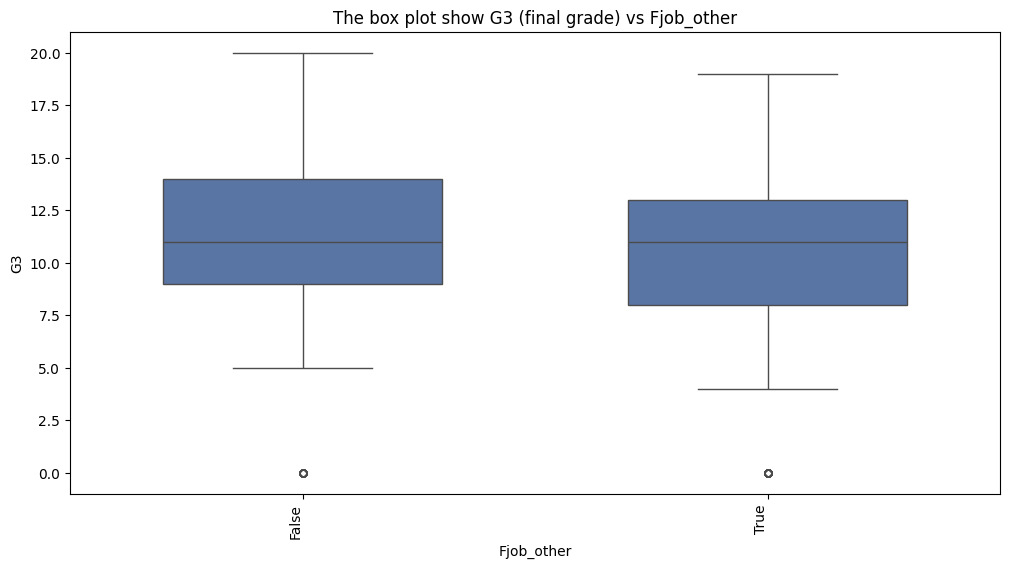

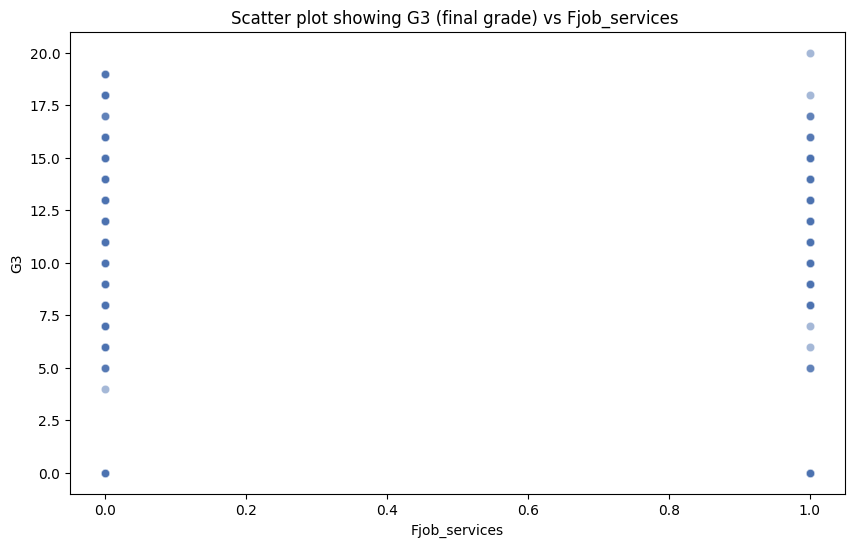

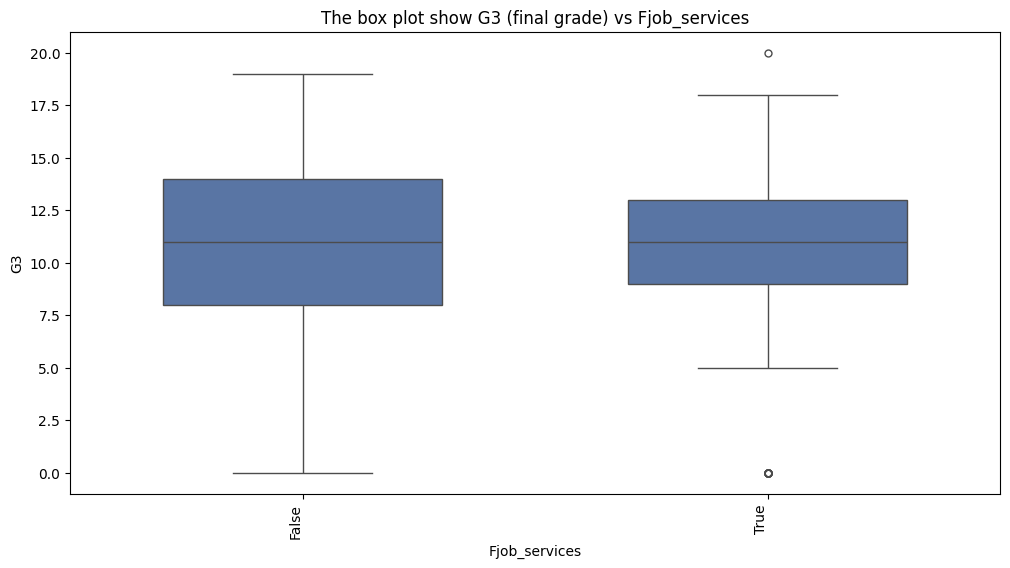

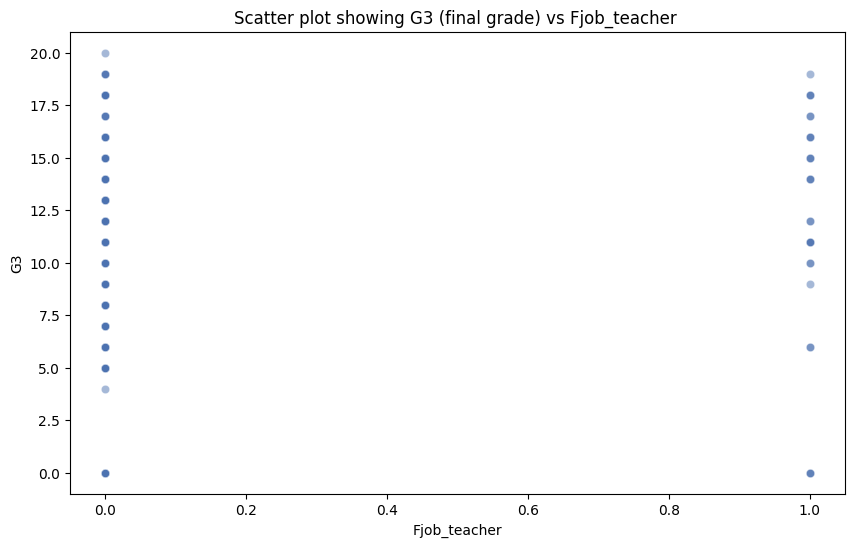

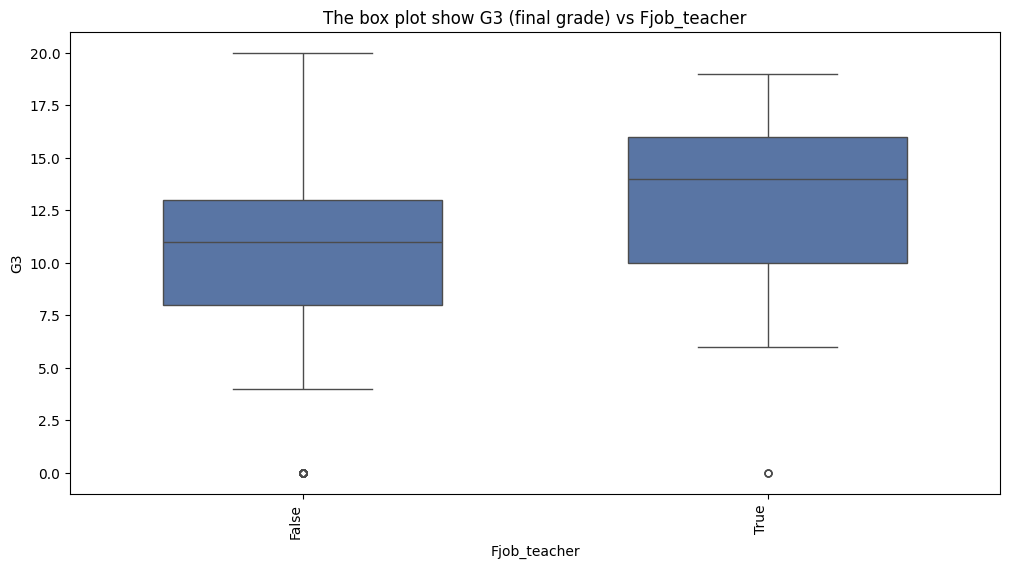

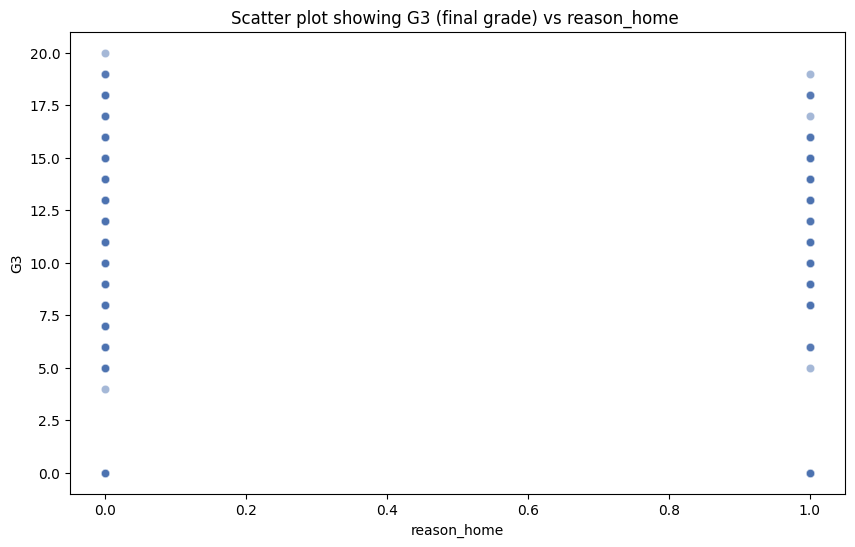

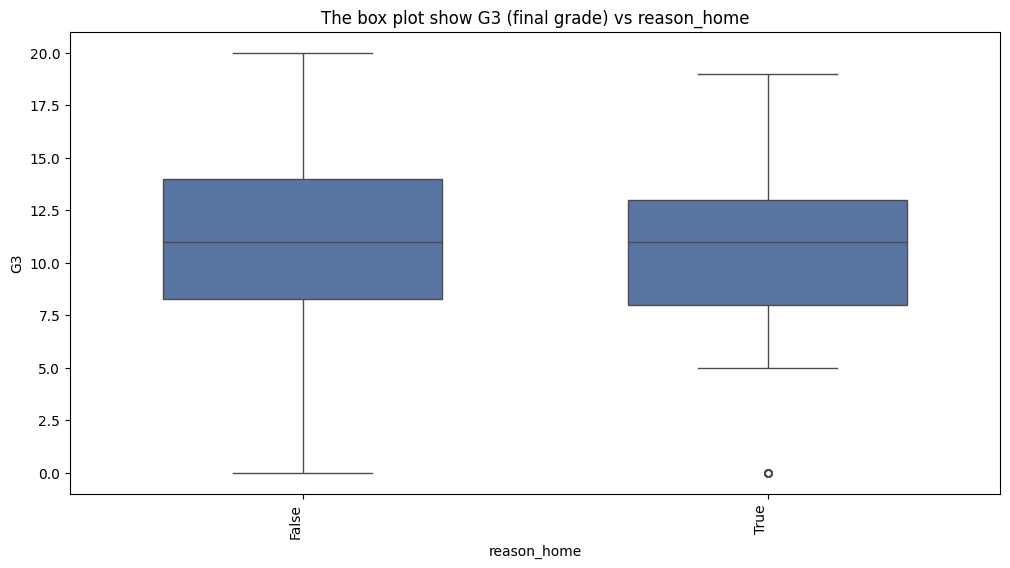

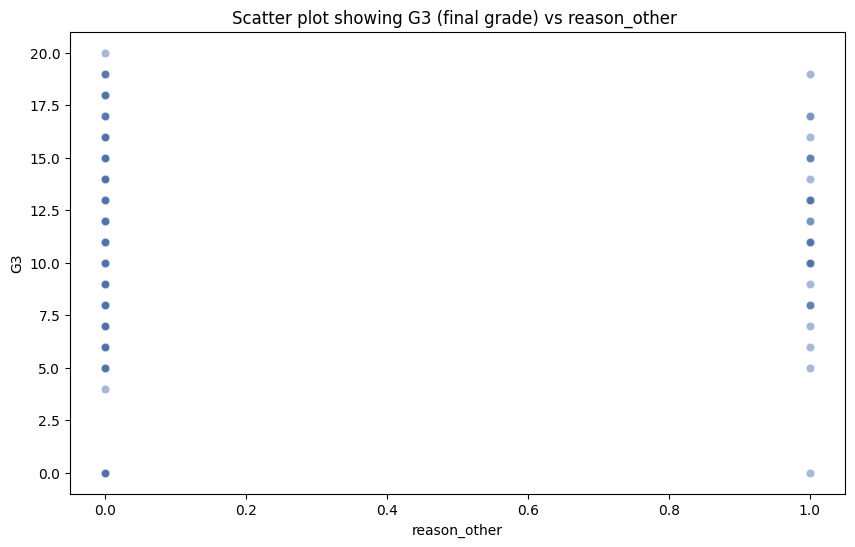

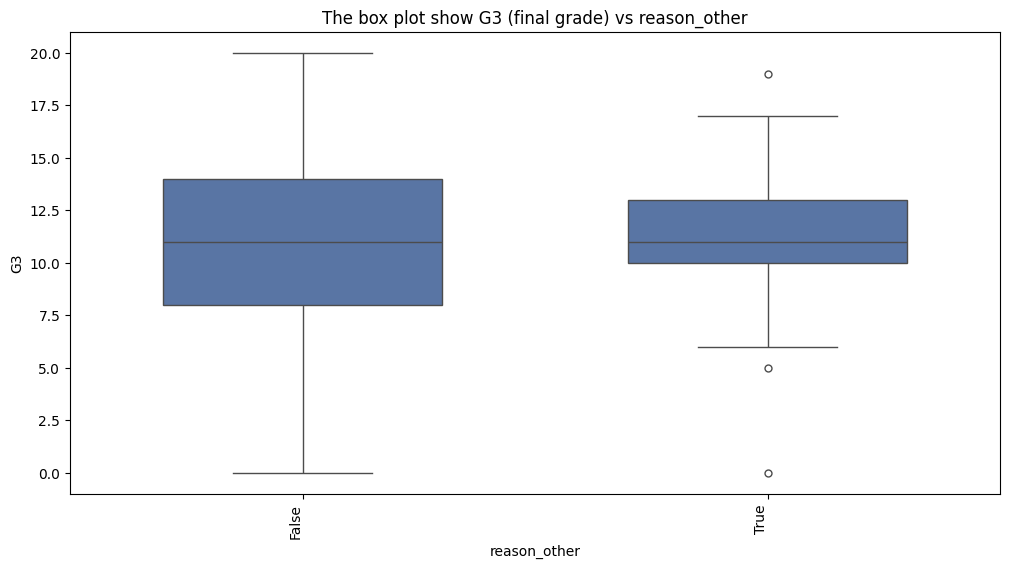

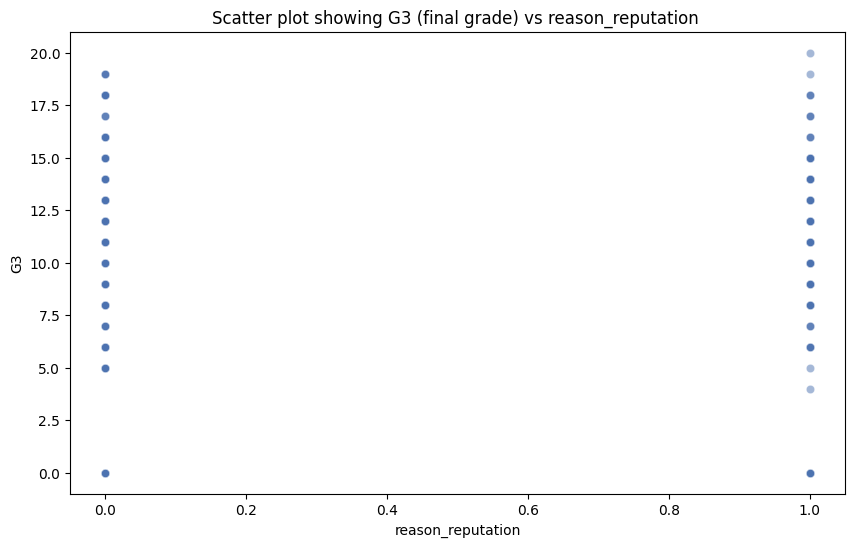

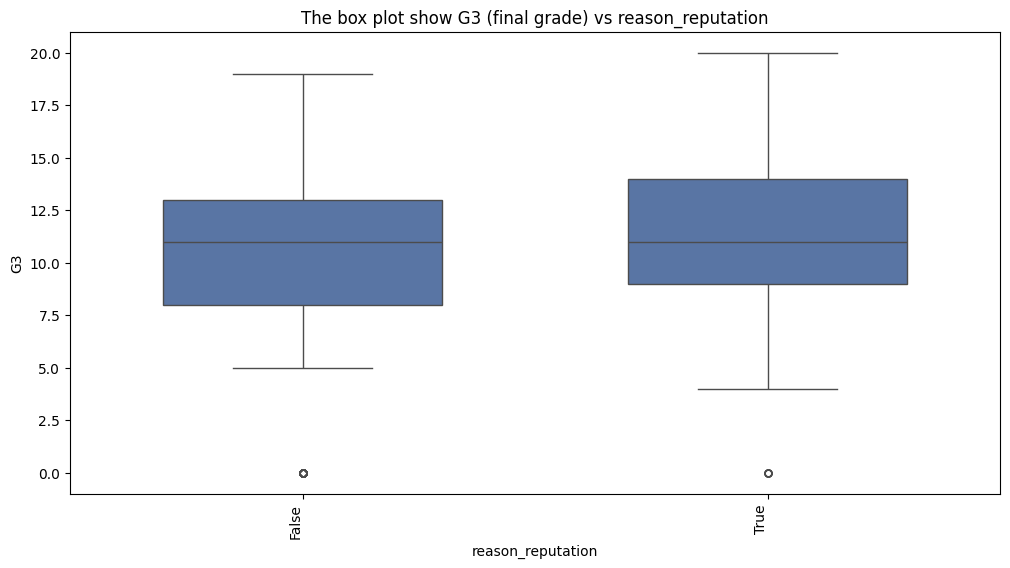

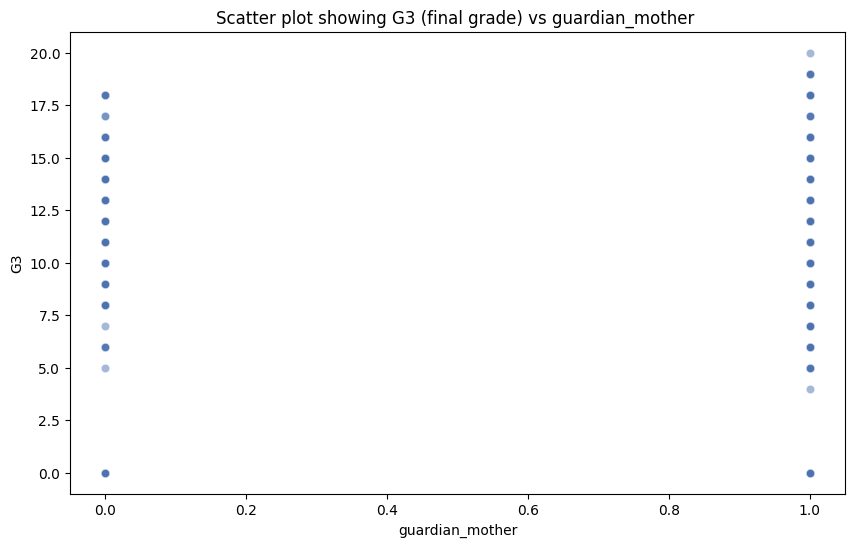

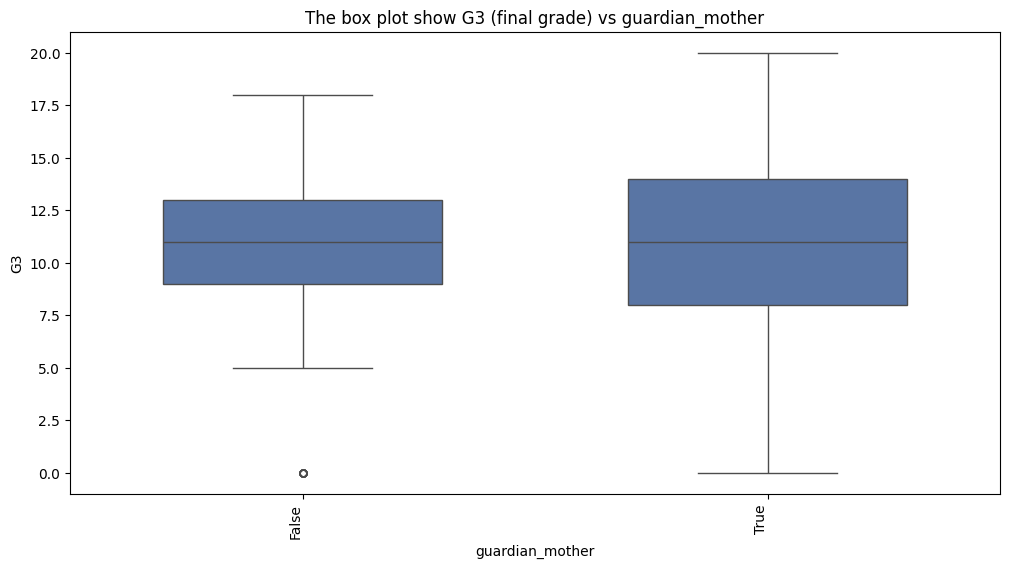

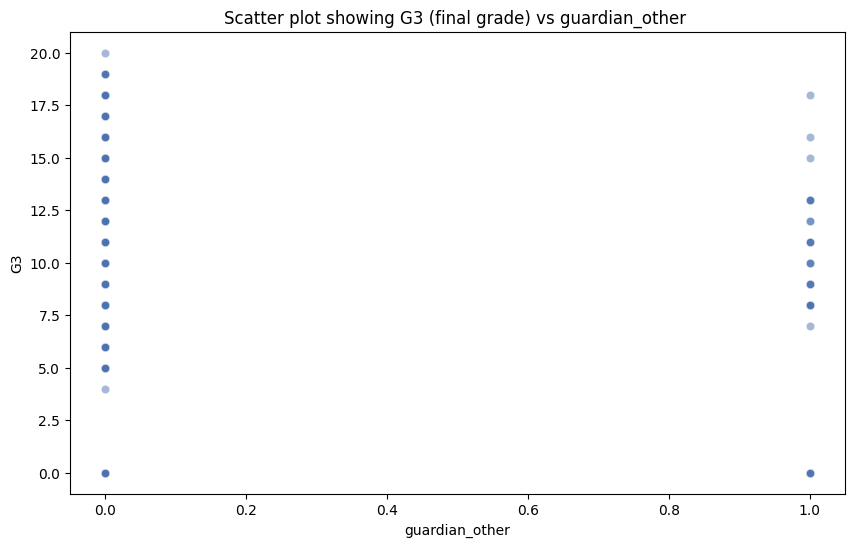

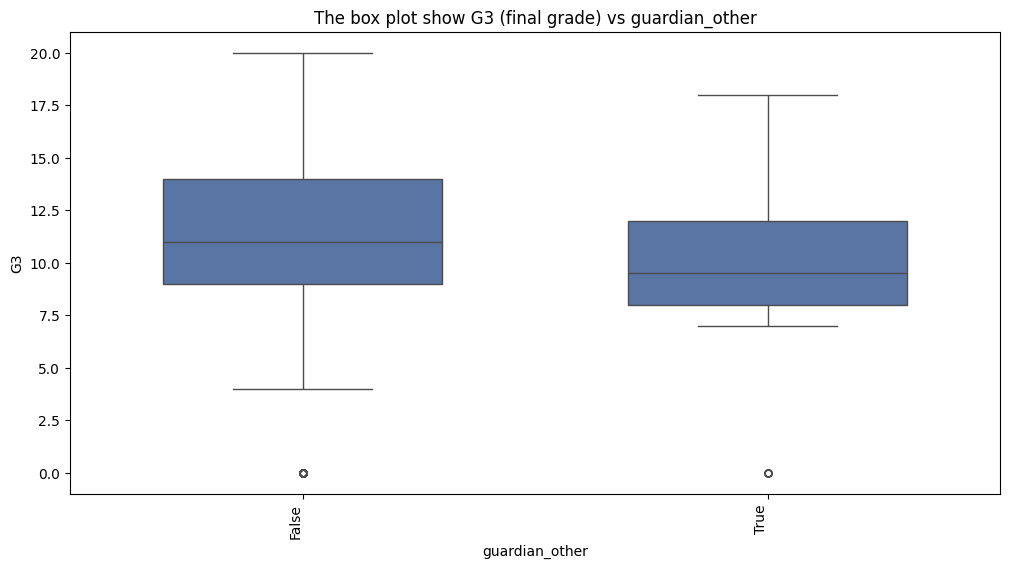

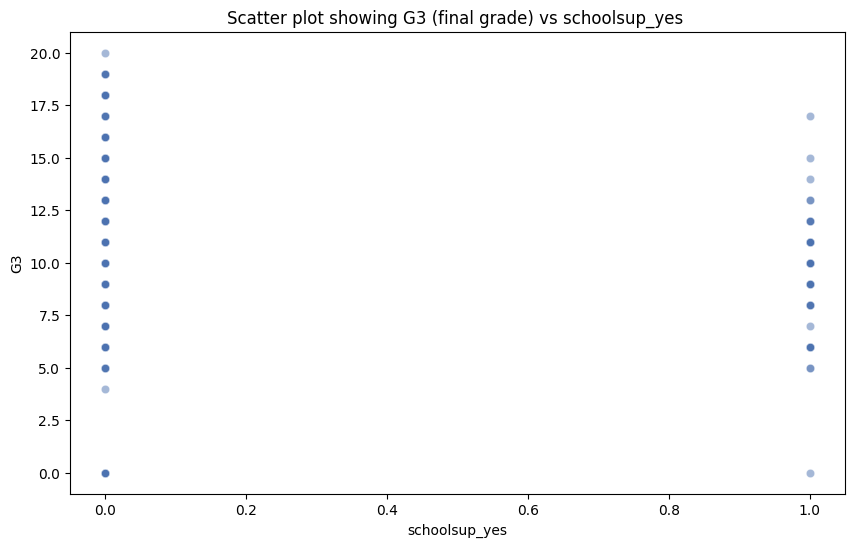

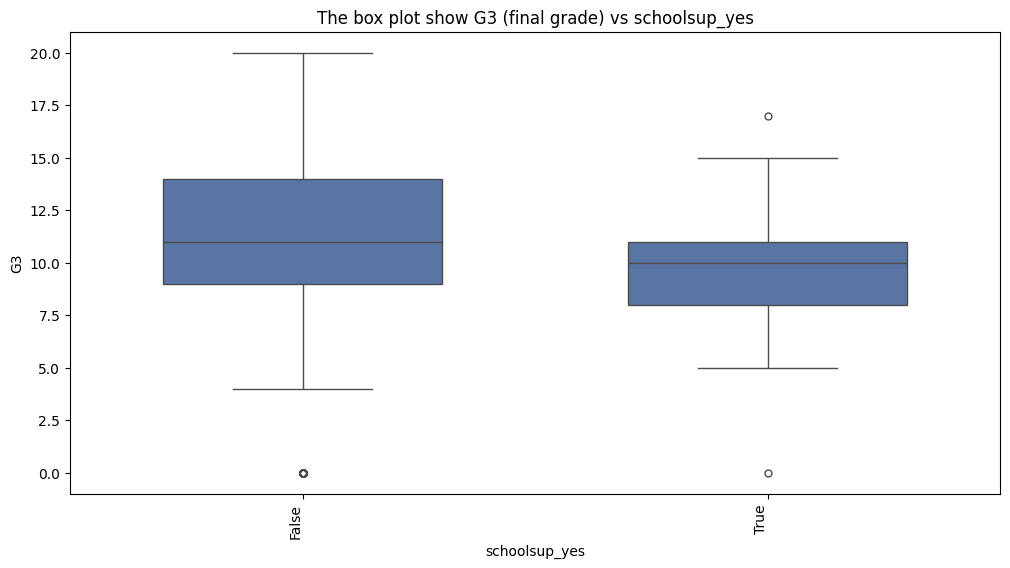

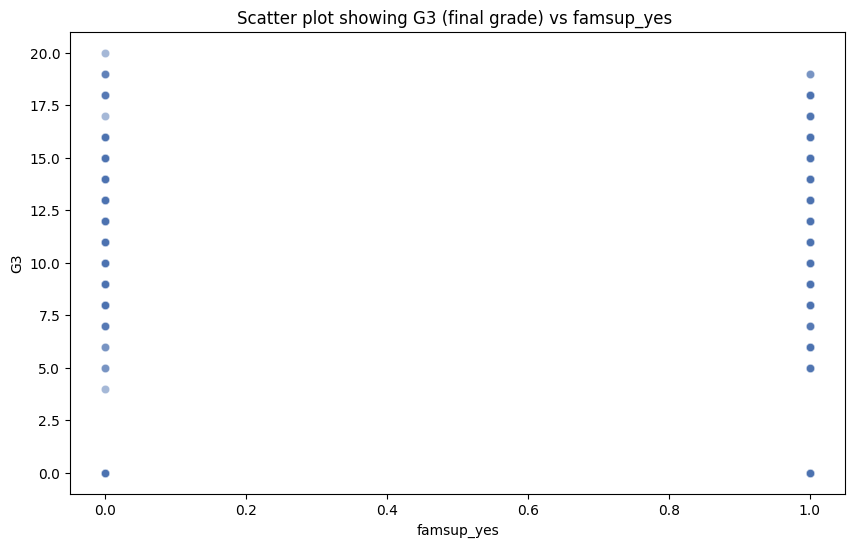

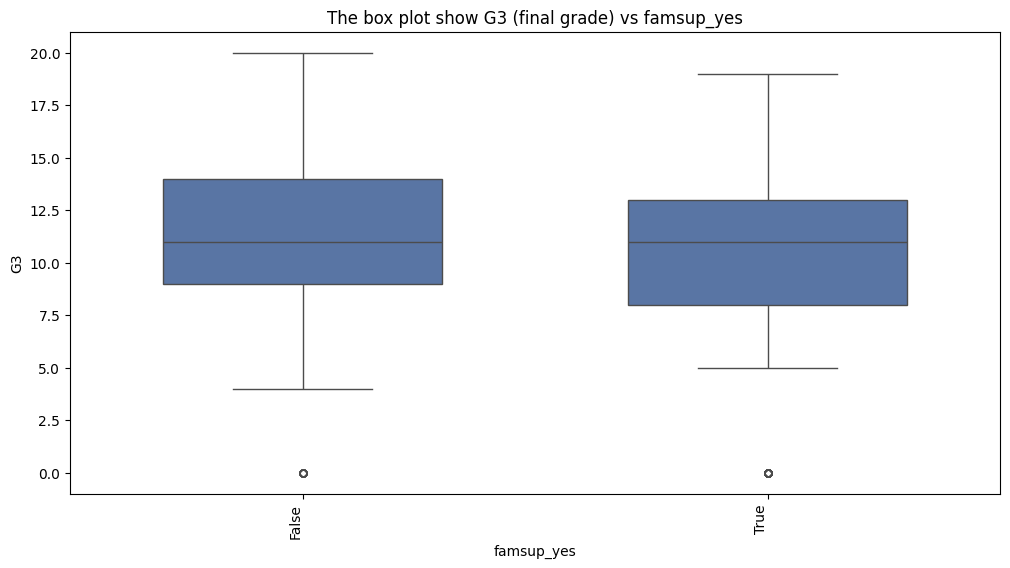

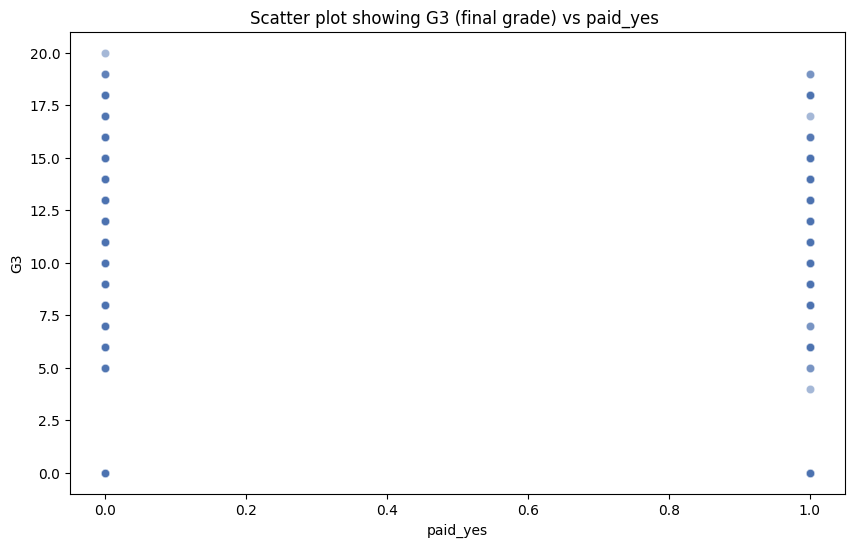

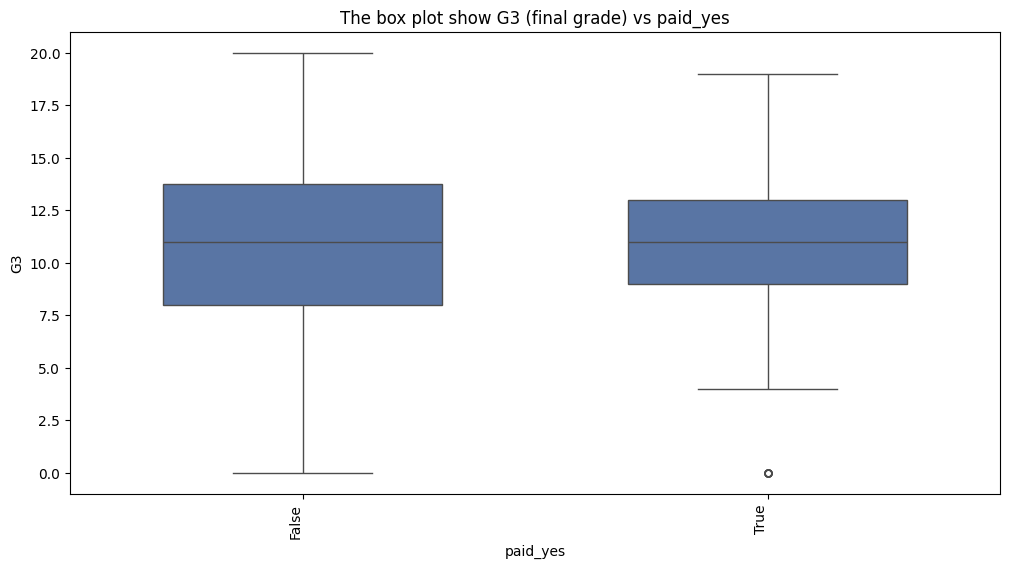

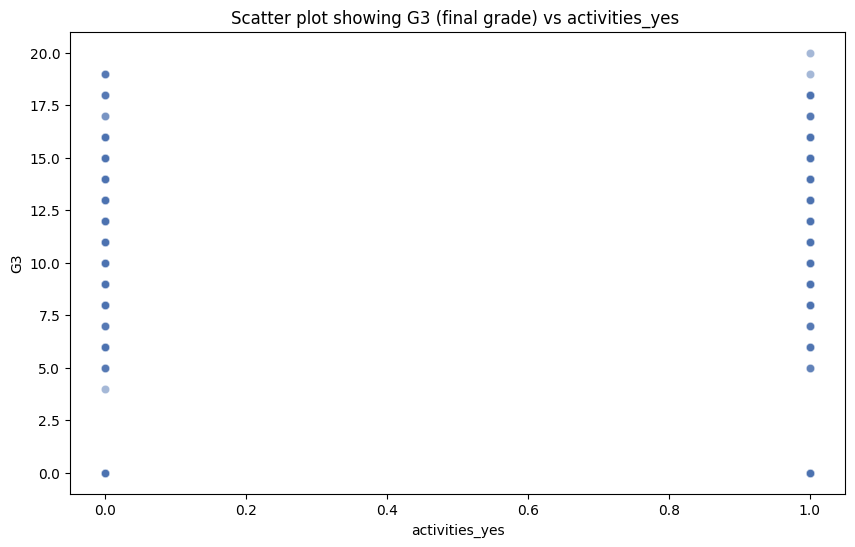

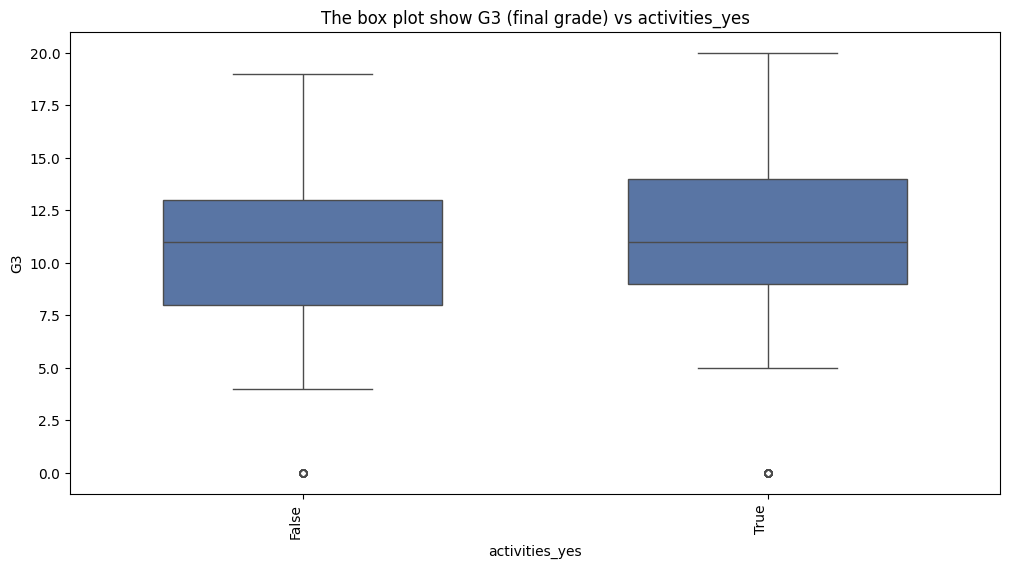

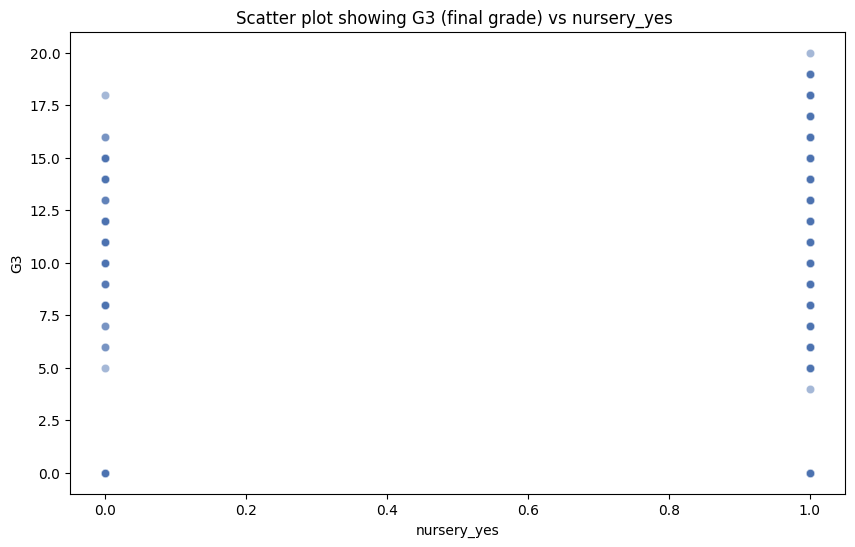

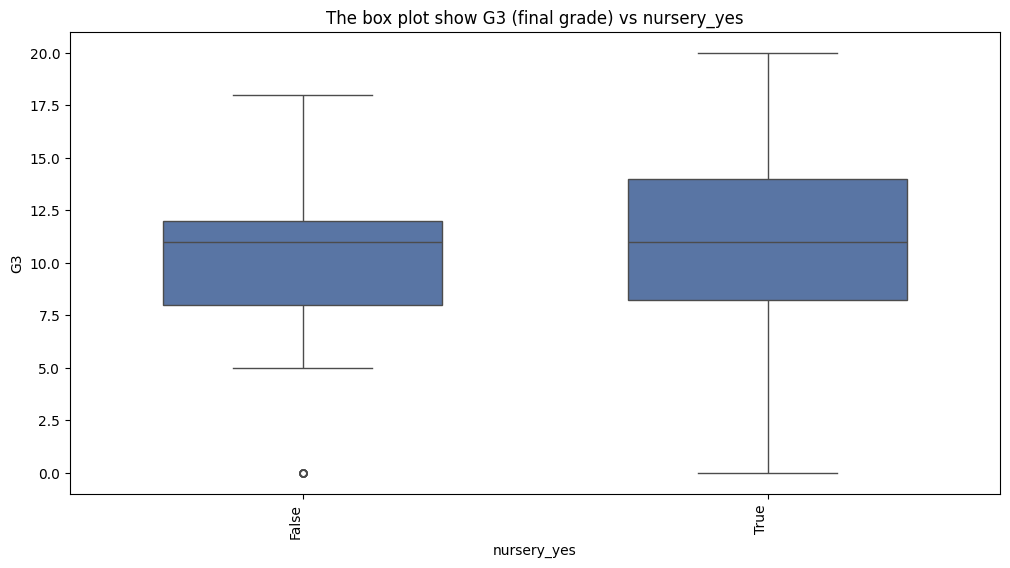

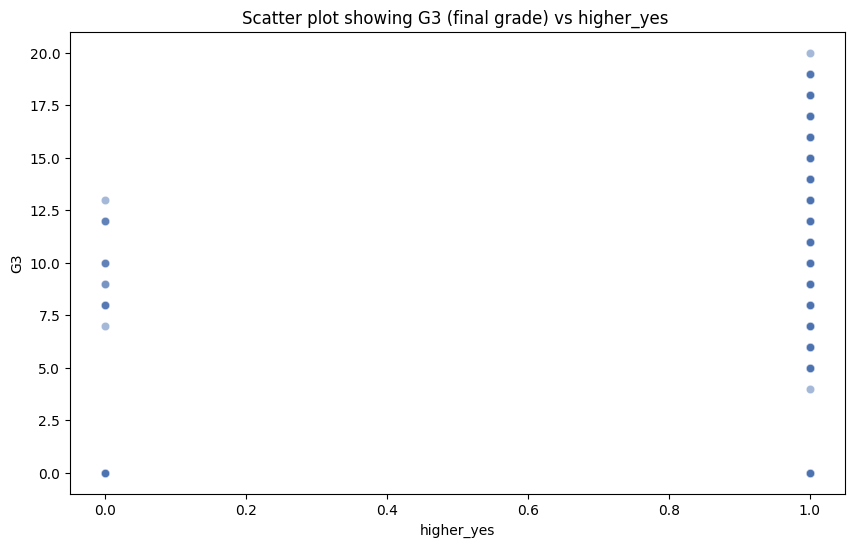

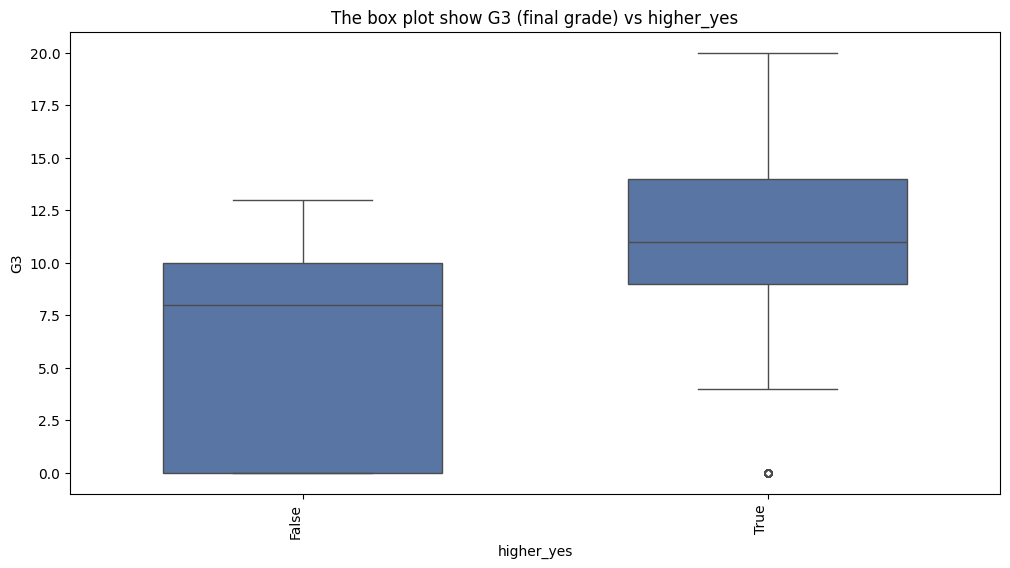

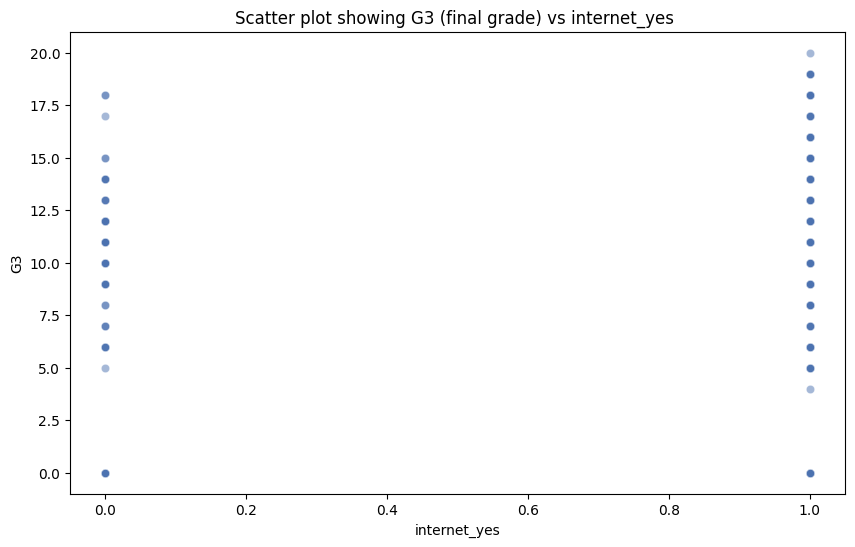

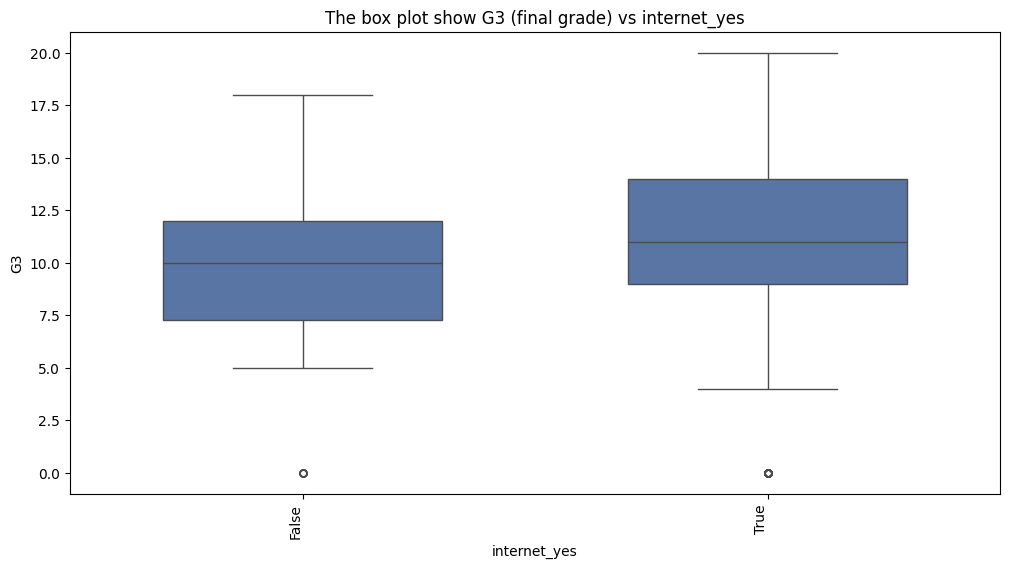

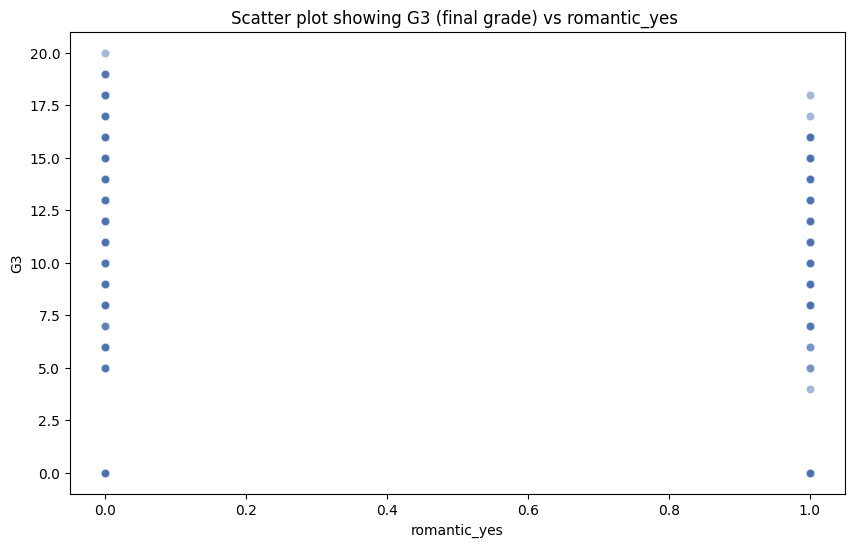

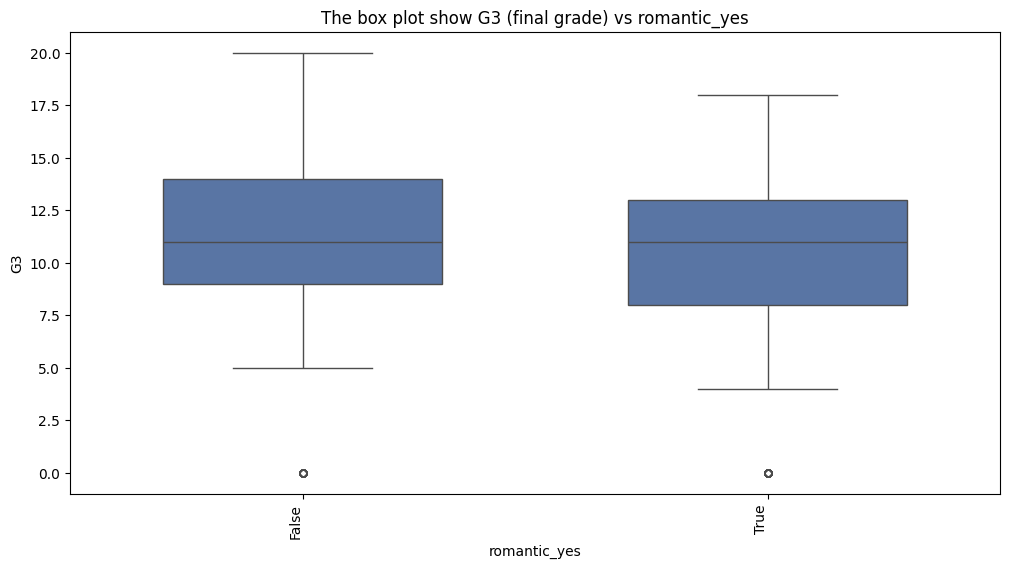

In [14]:
def analyze_graphs(data1, column, target):
    #Differents graphs created to analyze the data
    #scatter plot
    data1[column] =pd.to_numeric(data1[column], errors='coerce')
    data1[column] = data1[column].dropna()
    sns.set_palette('deep')
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=data1, x=column, y=target, alpha=0.5)
    plt.title(f"Scatter plot showing {target} (final grade) vs {column} ")
    plt.xlabel(column)
    plt.ylabel(target)
    plt.show()

    #box plot
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(data=data1,x=column, legend=False,fliersize=5,y=target, width=0.6)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
    plt.title(f"The box plot show {target} (final grade) vs {column}")
    plt.show()



def analyze_all_columns(data2, target):
    #analyze all columns against target
    column_features = [col for col in data2.columns if col != target]
    #loop through column features
    for columns in column_features:
        analyze_graphs(data2,columns, target )
analyze_all_columns(data ,target='G3')


Class for the predictions

In [35]:
#prediction class
class finalGradePrediction:
    def __init__(self, x_train, x_test, y_train, y_test, kfold, use_tuning=True, use_normalization=True,
                 use_shap = True):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test= y_test
        self.kfold= kfold
        self.use_tuning = use_tuning
        self.use_normalization = use_normalization
        self.use_shap = use_shap
    def evaluate_model(self, y_test, y_pred, model_name = "Model"):
        print(f"\n{model_name} evaluation report:")

        #calculate metrics
        mse = metrics.mean_squared_error(y_test, y_pred)
        rmse = mse **0.5
        mae = metrics.mean_absolute_error(y_test, y_pred)
        r_squared =r2_score(y_test, y_pred)

        #storing metrics in the dictionary
        metrics_dict ={ "MSE" : mse,
                        "RMSE": rmse,
                        "MAE" : mae,
                        "R^2": r_squared}

        #Displaying the metrics
        for keys, values in metrics_dict.items():
            print("{:s}: {:.5f}".format(keys,values))

        #calculating residuals
        residuals = y_test - y_pred

        #create subplots
        fig, axes= plt.subplots(1,3, figsize=(18,5))

        fig.suptitle(f"Model Evaluation: {model_name}", fontsize=14)

        #Ploting the target vs Prediction
        ax1 = axes[0]
        ax1.scatter(y_test, y_pred, color="red", alpha=0.5)

        #plot the ideal prediction line (with zero error
        ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r-")
        ax1.set_xlabel("Actual values")
        ax1.set_ylabel("Prediction")
        ax1.set_title("Prediction vs Actual")

        #ploting the residuals vs predicted
        ax2 = axes[1]
        ax2.scatter(y_pred, residuals, alpha=0.5)
        ax2.axhline(y=0, color="k", linestyle="-")
        ax2.set_title("Predicted Values vs Residuals")
        ax2.set_xlabel("Predicted values")
        ax2.set_ylabel("Residuals")

        #bar char for the metrics
        ax3 = axes[2]
        evaluation_names = list(metrics_dict.keys()) #make the name of the evaluation as keys
        values = list(metrics_dict.values()) #get values
        ax3.bar(evaluation_names, values, color=["yellow", "red", "green", "skyblue"])
        ax3.set_title("Evaluation Metrics")
        ax3.set_ylabel("Values")

        #loop through values
        for index, value in enumerate(values):
            ax3.text(index, value, f"{value:.2f}", ha="center", va="bottom")
        plt.tight_layout(rect=[0, 0.04, 1, 1.0])
        plt.show()
        return metrics_dict

    def train_model(self, model, param_dist=None, model_name="Model"):
        #function to train the mode
        if self.use_tuning and  param_dist:
            print(f"Tuning the {model_name}")
            search = GridSearchCV(model, param_grid=param_dist,
                                   cv=self.kfold, scoring="neg_mean_absolute_error", verbose=2,
                                  )
            search.fit(self.x_train, self.y_train)
            return search
        else:
            print(f"Training the m{model_name} without tuning")
            return model.fit(self.x_train, self.y_train)
    def LinearRegression(self):
        print("Training the Linear Regression model")

        #check if we can use normalization
        steps = []
        if self.use_normalization:
            steps.append(('scaler', StandardScaler()))
        steps.append(('lr', LinearRegression()))
        #creating the pipeline
        pipeline = Pipeline(steps)
        param_grid ={"lr__fit_intercept": [True,False]}

        model = self.train_model(pipeline, param_grid, model_name="LinearRegression")
        y_pred = model.predict(self.x_test)
        lr_model = model.best_estimator_.named_steps['lr']

        #displaying the coefficients and the intercepts
        print("Coefficients:", lr_model.coef_)
        print("Intercept:", lr_model.intercept_)
        self.evaluate_model(self.y_test, y_pred, "LinearRegression")

        #using shap to understand how important the features are
        #in making the prediction
        if self.use_shap:
            explainer_model = model.best_estimator_.named_steps['lr']
            if self.use_normalization:
                explainer_data = model.best_estimator_.named_steps['scaler'].transform(self.x_test)
            else:
                explainer_data = self.x_test

            explainer = shap.Explainer(explainer_model, explainer_data)
            shap_values = explainer(explainer_data)

            # Force plot
            instance_index = 0
            shap.plots.force(
                explainer.expected_value,
                shap_values[instance_index].values,
                self.x_test.iloc[instance_index],
                matplotlib=True
            )

            self._plot_shap_summary(model, model_name="LinearRegression")
        return model
    def RidgeRegression(self):
        """Implementing ridge regression model to reduce multicolinearity"""
        pipeline = Pipeline([("scaler", StandardScaler()),
                             ('ridge', Ridge()) #regularization strength set to 1
                             ])

        # Define number of random alphas to test
        n_iterations = 5
        np.random.seed(60)  # For reproducibility

        # List to store results
        results = []

        # Generate and test random alphas in a loop
        for i in range(n_iterations):
            # Generate a random alpha value
            random_alpha = np.random.uniform(0.1, 200)
            param_grid = {"ridge__alpha": [random_alpha], #testing ridge with different regularization levels
                      #auto choose solver automaticall
                      #svd : stands for Singular value decomposition
                      #sag use stochastic average gradient descent
                      "ridge__solver" : ["auto", "svd", "sag"]  #testing different solvers
                      }
        model =self.train_model(pipeline, param_grid, model_name = "Ridge Regression")

        print(f"Iteration {i+1}: Testing alpha = {random_alpha}")
        y_pred = model.predict(self.x_test)
        self.evaluate_model(self.y_test, y_pred, "Ridge Regression")
        ridge_model = model.best_estimator_.named_steps['ridge']

        #display the best alpha, solver, coefficients and intercepts
        print("Best alpha:", ridge_model.alpha)
        print("Best solver:", ridge_model.solver)
        print("Coefficients:", ridge_model.coef_)
        print("Intercept:", ridge_model.intercept_)

        if self.use_shap:
            #geting the best estimator from the trained pipeline
            estimator = model.best_estimator_

            #manually tranform all values of X to numerical
            transform = estimator.named_steps["scaler"].transform(self.x_test)
            explainer = shap.LinearExplainer(estimator.named_steps["ridge"],transform)

            # Calculate SHAP values
            shap_values = explainer.shap_values(transform)

            # Plot force plot for a every x_test feature in the class
            for i in range(len(self.x_test)):
                shap.plots.force(
                    explainer.expected_value,
                    shap_values[i],
                    self.x_test.iloc[i],
                    matplotlib=True
                )

            self._plot_shap_summary(model, model_name="Ridge Regression")

        return model

    def _plot_shap_summary(self, model, model_name="Model", task_type="regression"):
        #using it to explain how each feature contribut to the target
        print(f"Generating SHAP summary for {model_name}...")

        #Get feature names
        if isinstance(self.x_train, pd.DataFrame): # Check if x_train is a dataframe
            # Change columns to list
            feature_names = self.x_train.columns.tolist()
            shap_data = self.x_train
            shap_test = self.x_test
        else:
            feature_names = [f"feature {i+1}" for i in range(self.x_train.shape[1])]
            shap_data = pd.DataFrame(self.x_train, columns=feature_names)
            shap_test = pd.DataFrame(self.x_test, columns=feature_names)
        predict_fn = model.predict

        #Using k-means to summarize the dataset
        background = shap.kmeans(shap_data, 50)
        explainer = shap.KernelExplainer(predict_fn, background)

        #calculate shape values
        shap_values = explainer.shap_values(shap_test)

        # Plot the SHAP summary
        shap.summary_plot(shap_values,shap_test, feature_names=feature_names, plot_type="bar",show=False)
        plt.title(f"SHAP Feature Importance for {model_name}", fontsize=14)
        plt.tight_layout()
        plt.show()






VISUALIZING THE PREDICTION

0     6.0
1     6.0
2    10.0
3    15.0
4    10.0
Name: G3, dtype: float64
    age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  goout  \
0  18.0     4     4           2          2         0       4       3.0      4   
1  17.0     1     1           1          2         0       5       3.0      3   
2  15.0     1     1           1          2         3       4       3.0      2   
3  15.0     4     2           1          3         0       3       2.0      2   
4  16.0     3     3           1          2         0       4       3.0      2   

   Dalc  ...  guardian_mother  guardian_other  schoolsup_yes  famsup_yes  \
0     1  ...             True           False           True       False   
1     1  ...            False           False          False        True   
2     2  ...             True           False           True       False   
3     1  ...             True           False          False        True   
4     1  ...            False           False          Fal

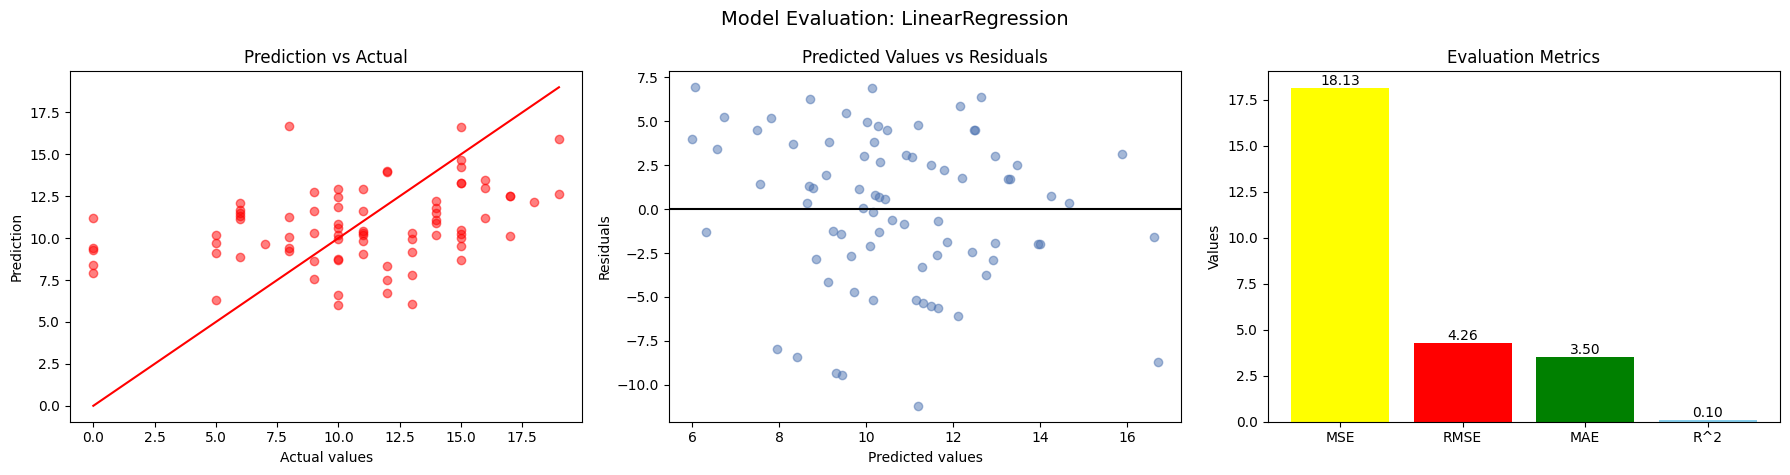

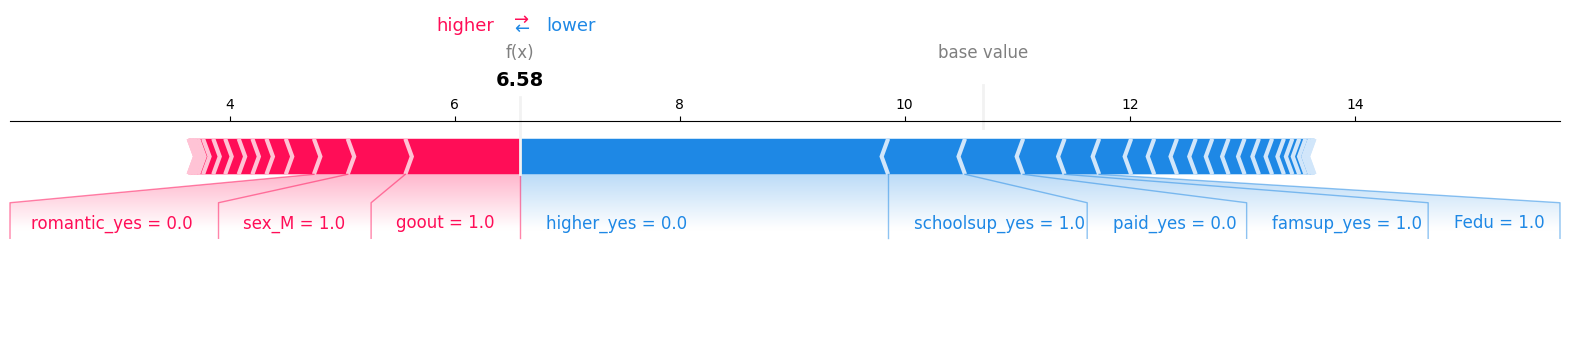

Generating SHAP summary for LinearRegression...


  0%|          | 0/79 [00:00<?, ?it/s]

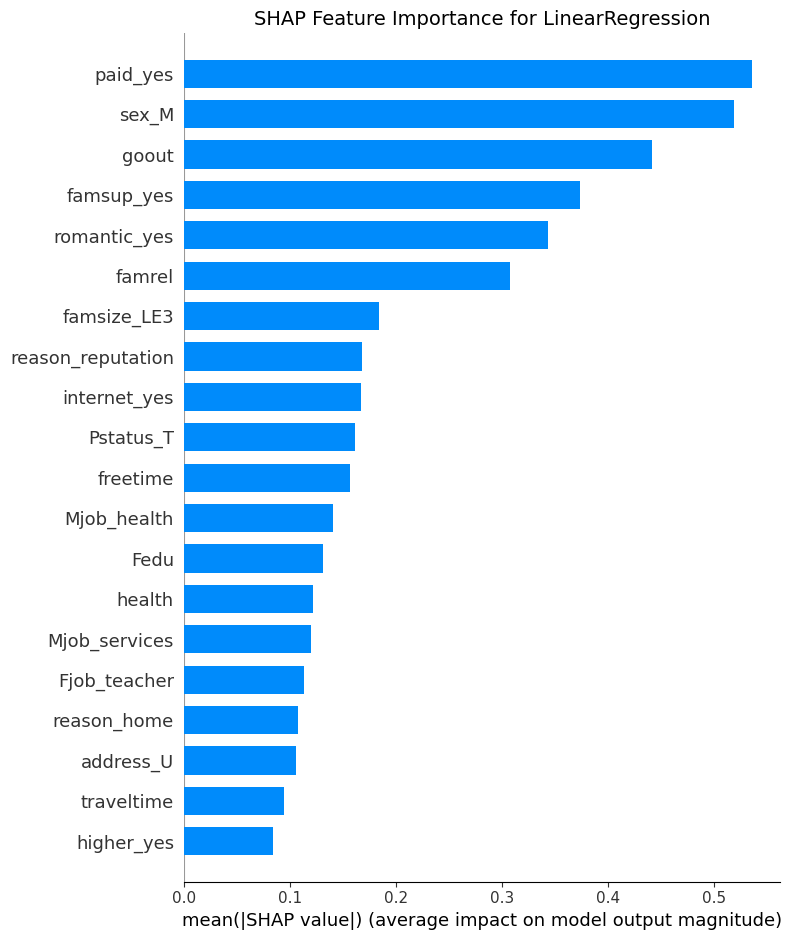

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr', LinearRegression())]),
             param_grid={'lr__fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error', verbose=2)

In [36]:
y= data.G3
print(y.head())
x = data.drop(["G3"], axis=1)
print(x.head())

#separate the data into testing and training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

finalPred =finalGradePrediction(x_train, x_test, y_train, y_test, kfold = 5, use_tuning=True, use_normalization=True,
                 use_shap = True)

finalPred.LinearRegression()


Ridge Regression Prediction

Tuning the Ridge Regression
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ridge__alpha=113.43746311374575, ridge__solver=auto; total time=   0.0s
[CV] END ridge__alpha=113.43746311374575, ridge__solver=auto; total time=   0.0s
[CV] END ridge__alpha=113.43746311374575, ridge__solver=auto; total time=   0.0s
[CV] END ridge__alpha=113.43746311374575, ridge__solver=auto; total time=   0.0s
[CV] END ridge__alpha=113.43746311374575, ridge__solver=auto; total time=   0.0s
[CV] END .ridge__alpha=113.43746311374575, ridge__solver=svd; total time=   0.0s
[CV] END .ridge__alpha=113.43746311374575, ridge__solver=svd; total time=   0.0s
[CV] END .ridge__alpha=113.43746311374575, ridge__solver=svd; total time=   0.0s
[CV] END .ridge__alpha=113.43746311374575, ridge__solver=svd; total time=   0.0s
[CV] END .ridge__alpha=113.43746311374575, ridge__solver=svd; total time=   0.0s
[CV] END .ridge__alpha=113.43746311374575, ridge__solver=sag; total time=   0.0s
[CV] END .ridge__alph

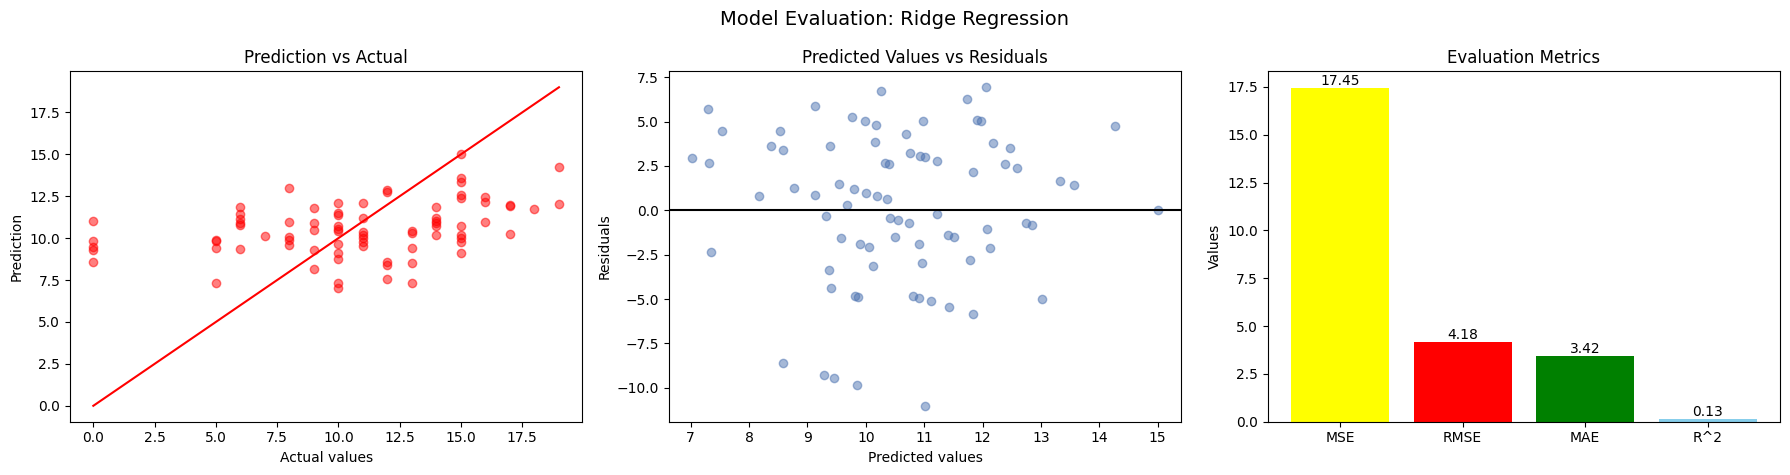

Best alpha: 113.43746311374575
Best solver: sag
Coefficients: [-0.22419662  0.16472035  0.22085664 -0.18682204  0.02869514 -0.20639158
  0.29764968  0.0940179  -0.38678102 -0.13425294 -0.08068807 -0.1813331
 -0.02451172 -0.01534521  0.35233413  0.15900554  0.23358852 -0.30930219
  0.30662005 -0.04257621  0.19457053 -0.01749274  0.05052567 -0.0018219
 -0.10179477  0.17389235 -0.13473363  0.23731773  0.24520494  0.0869733
 -0.11283722 -0.18032657 -0.31655408  0.40621623 -0.06911762 -0.06334078
  0.58438124  0.27033756 -0.36830803]
Intercept: 10.33860759493671


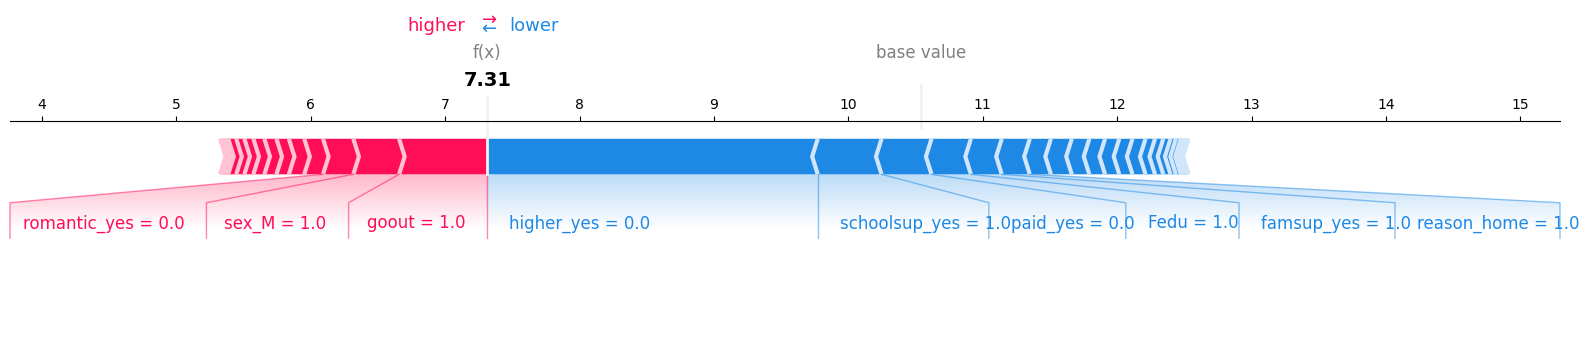

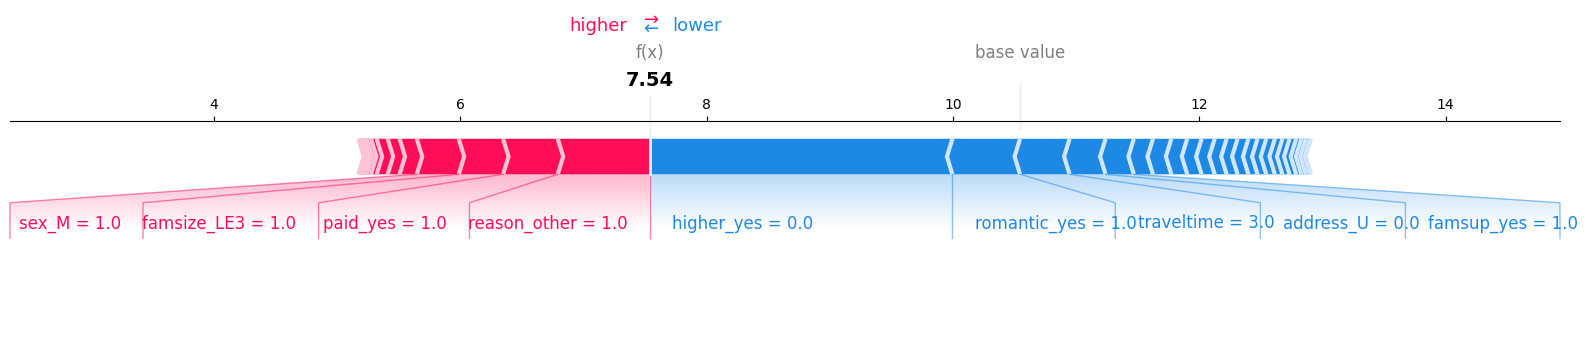

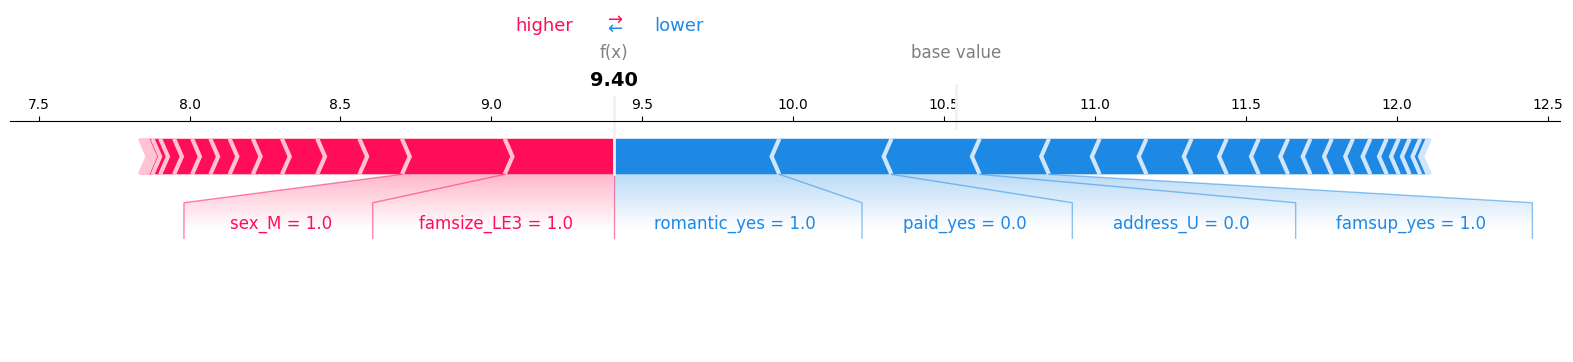

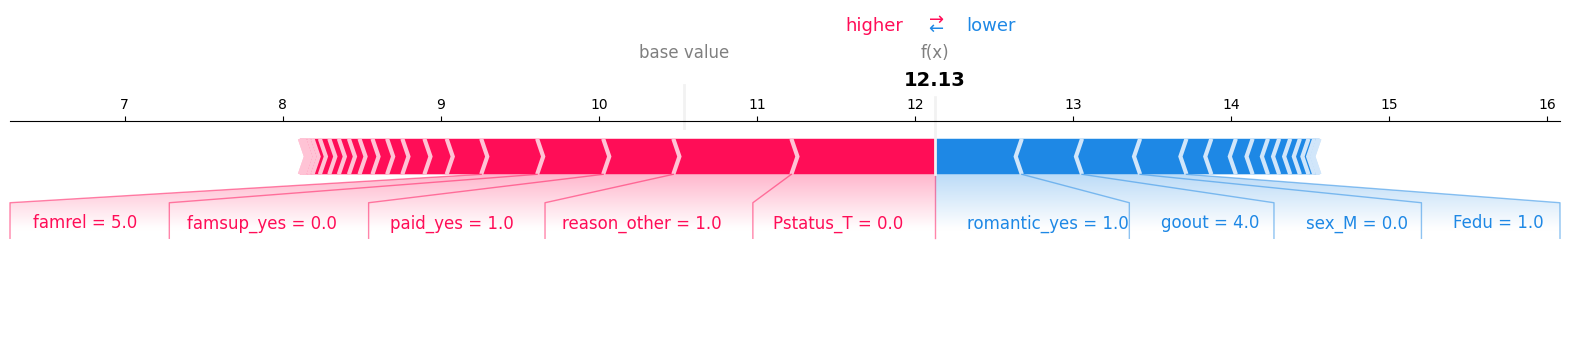

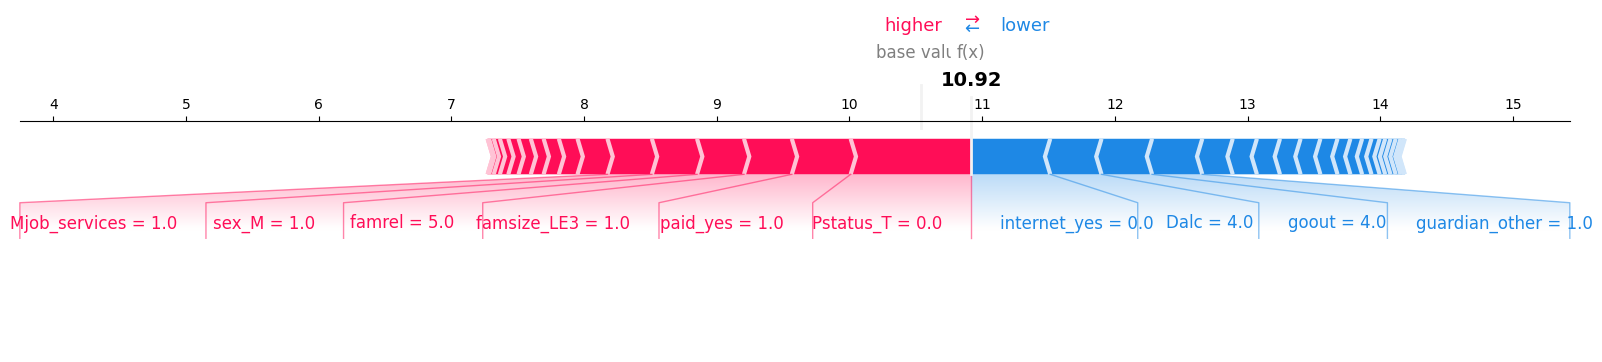

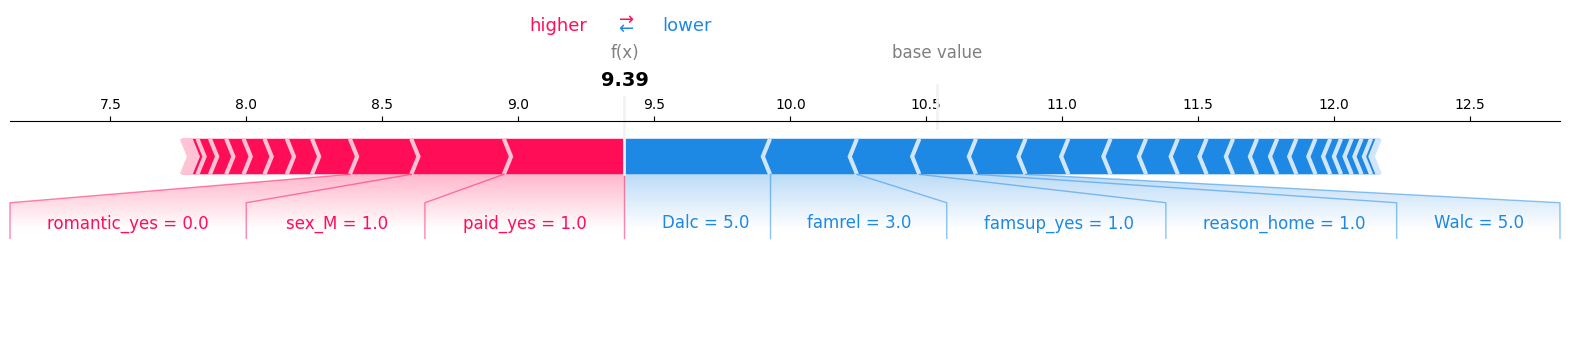

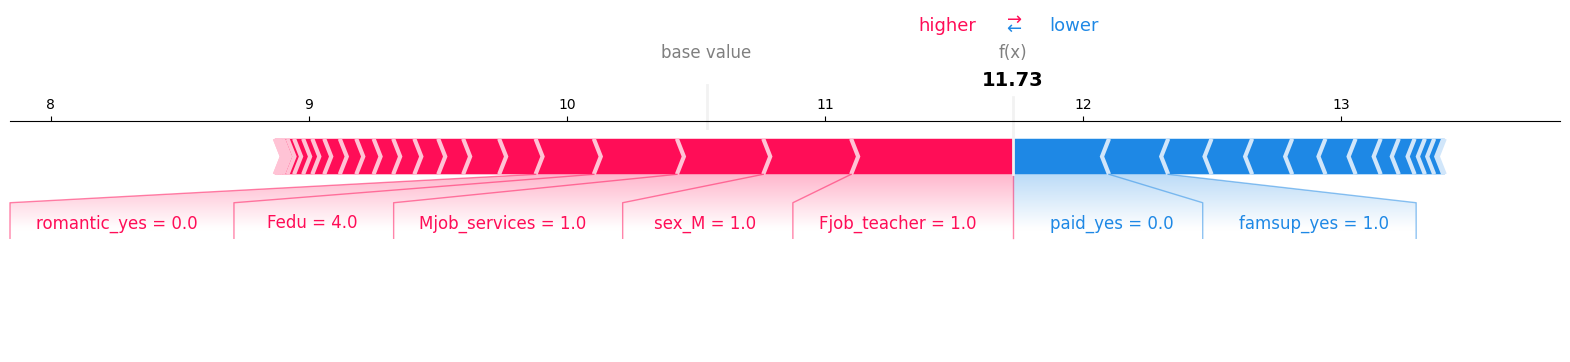

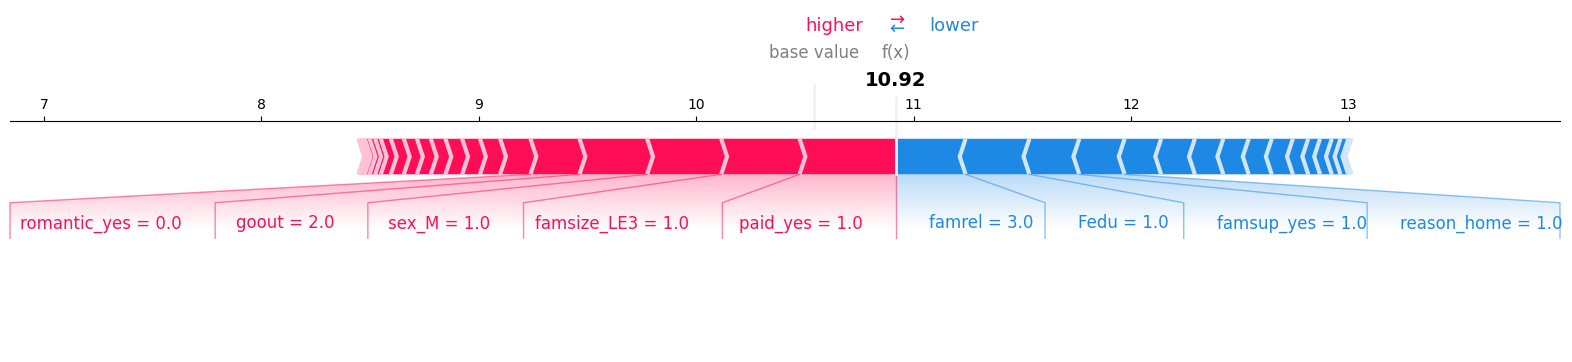

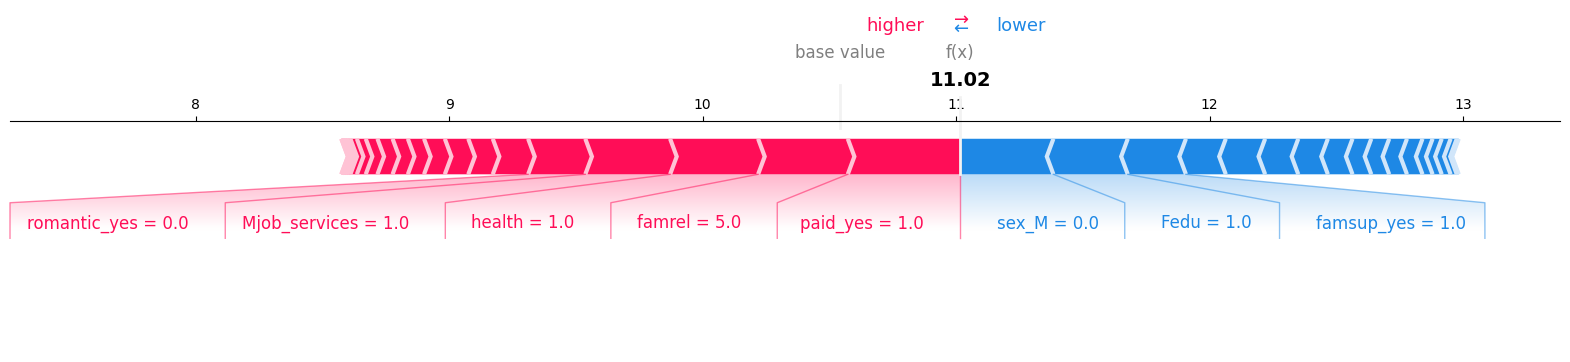

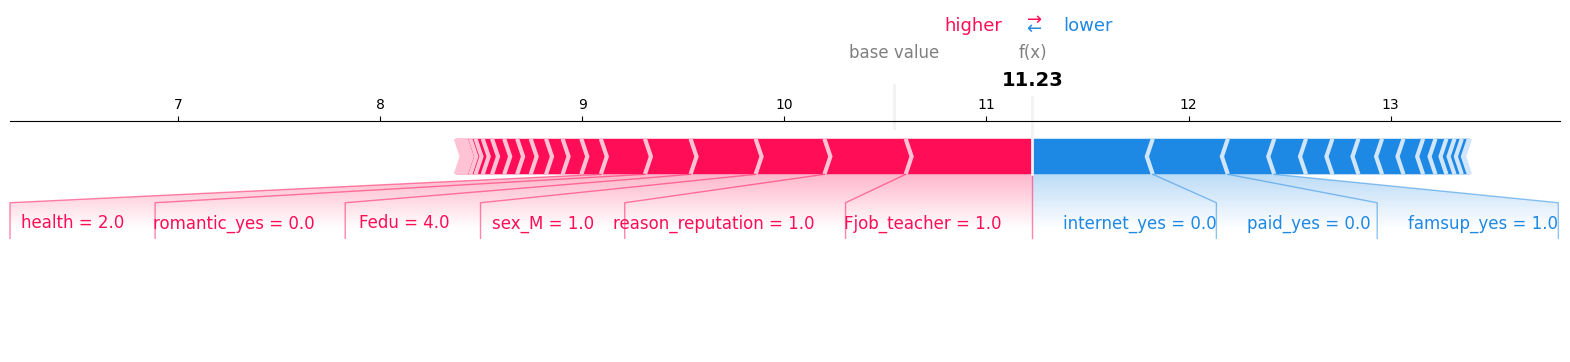

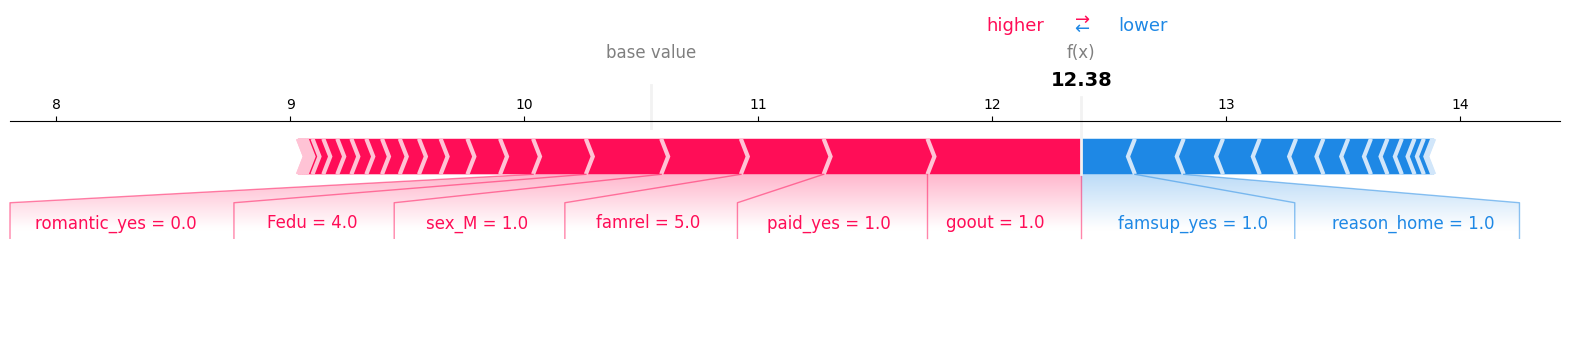

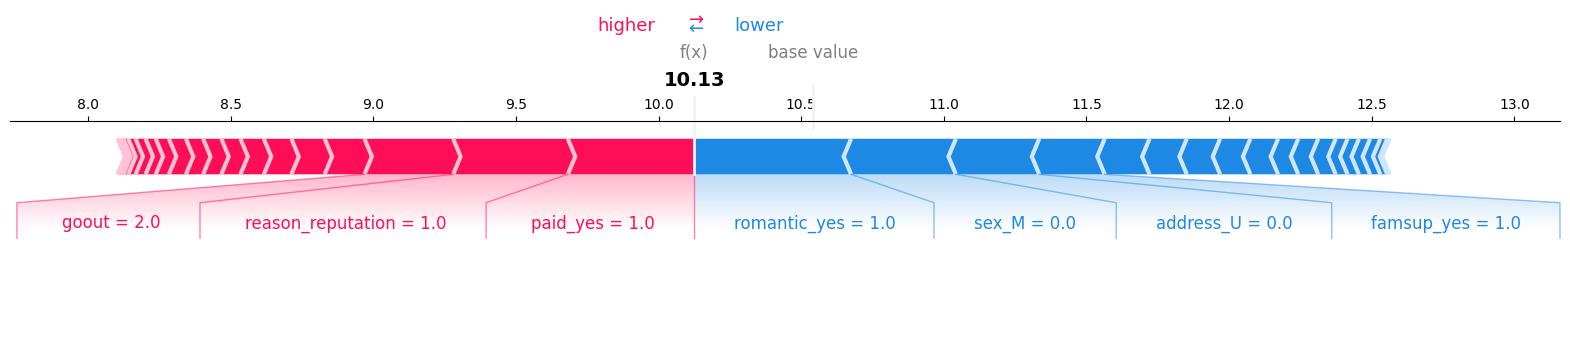

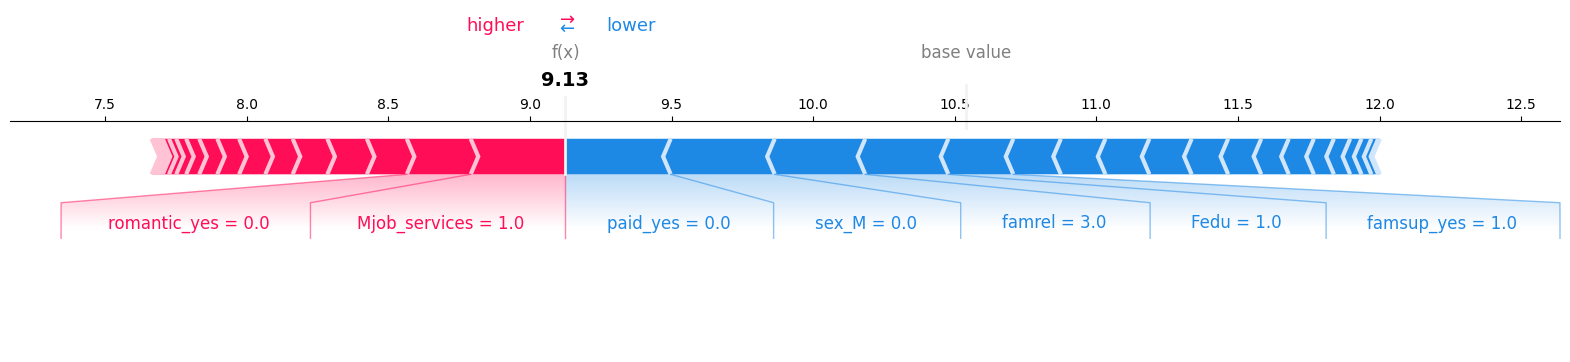

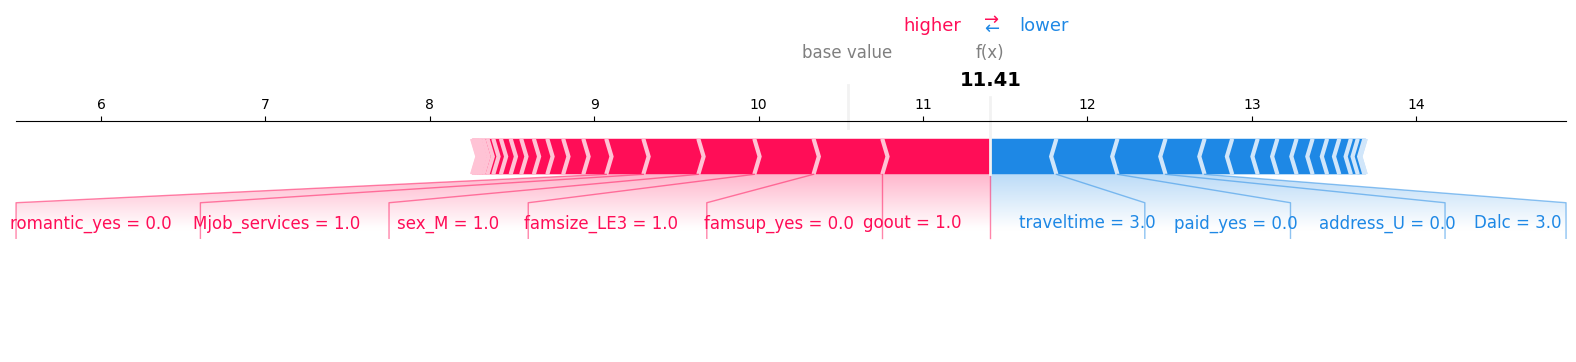

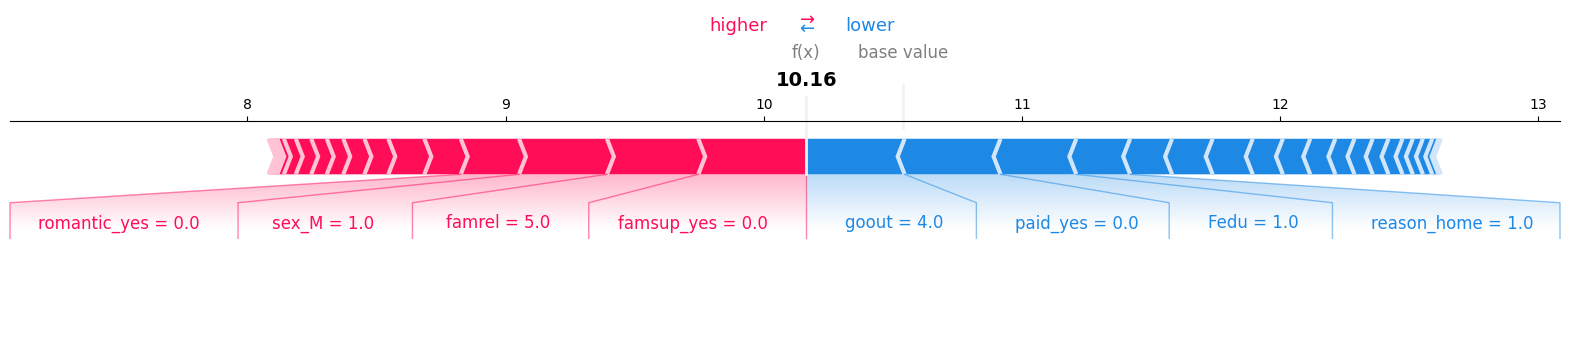

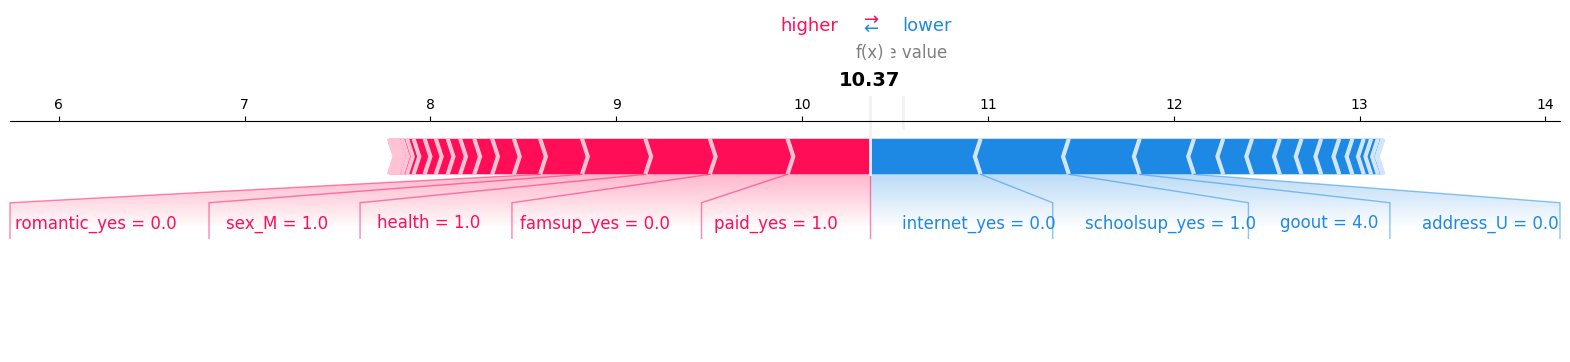

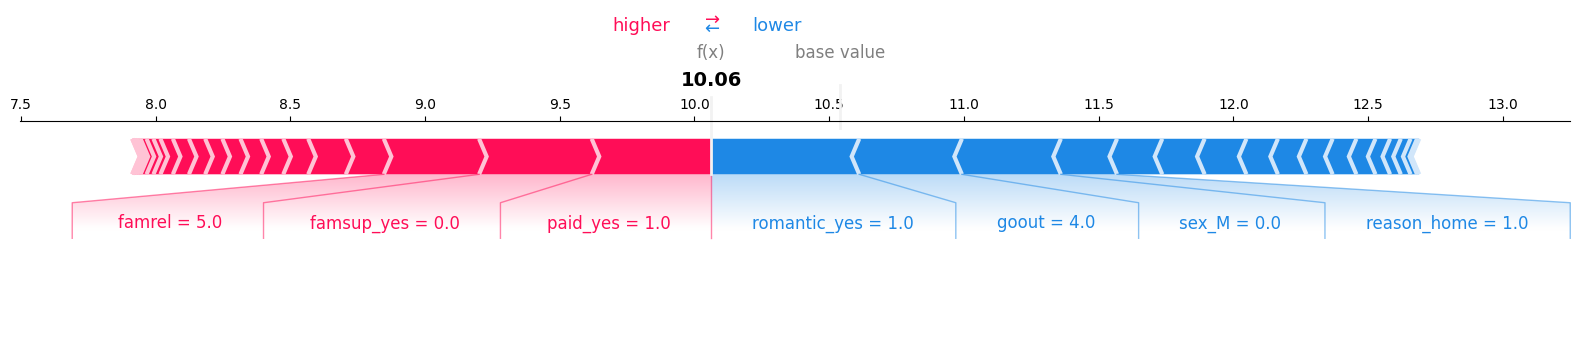

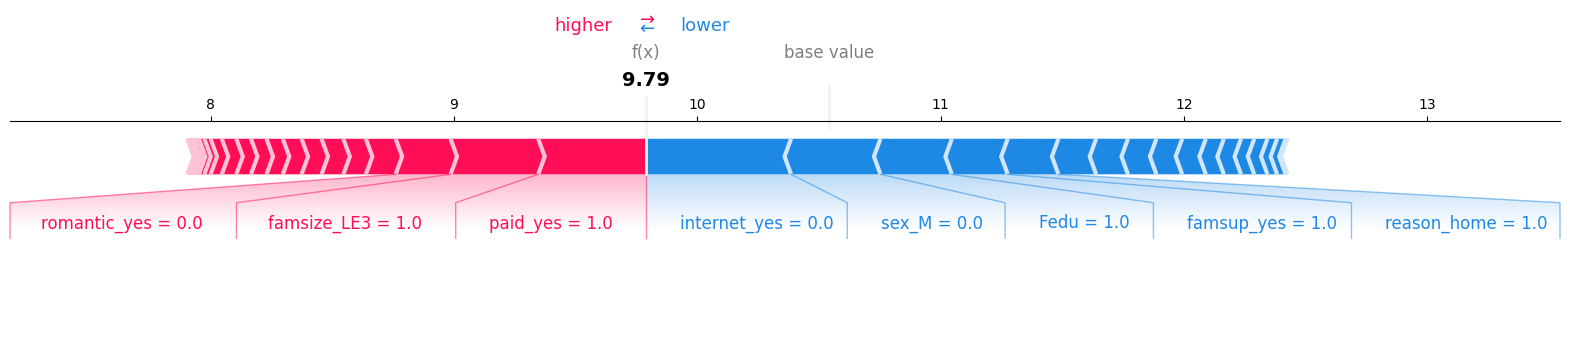

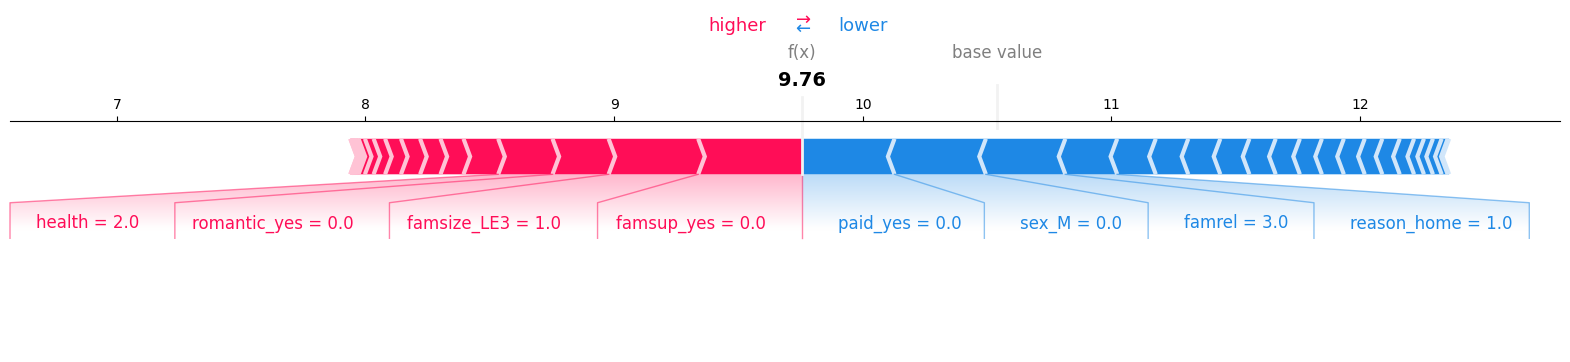

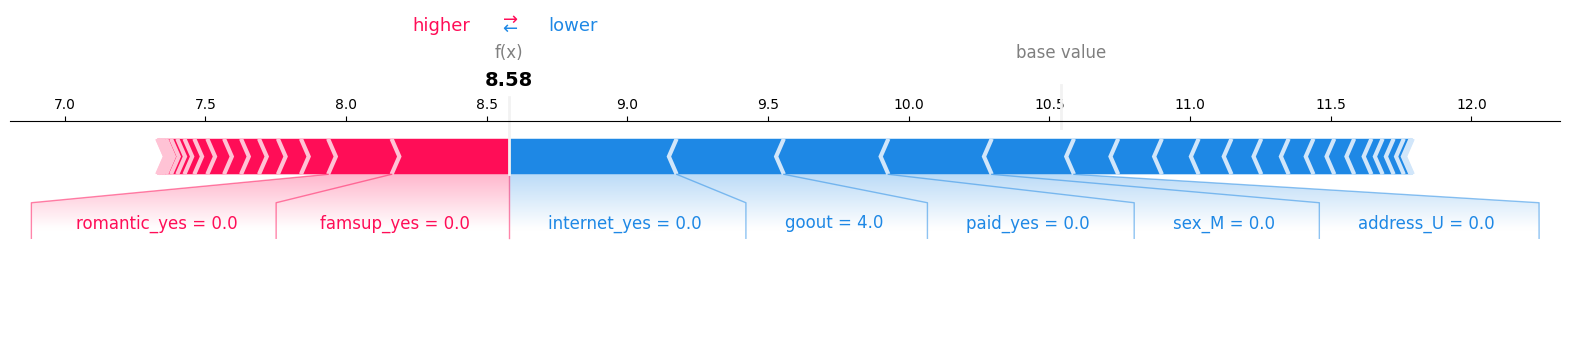

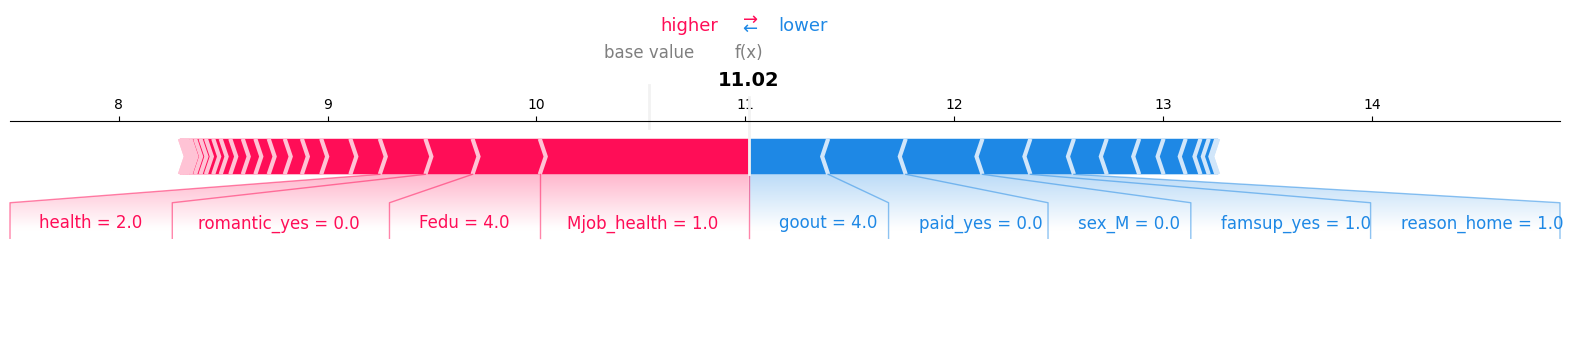

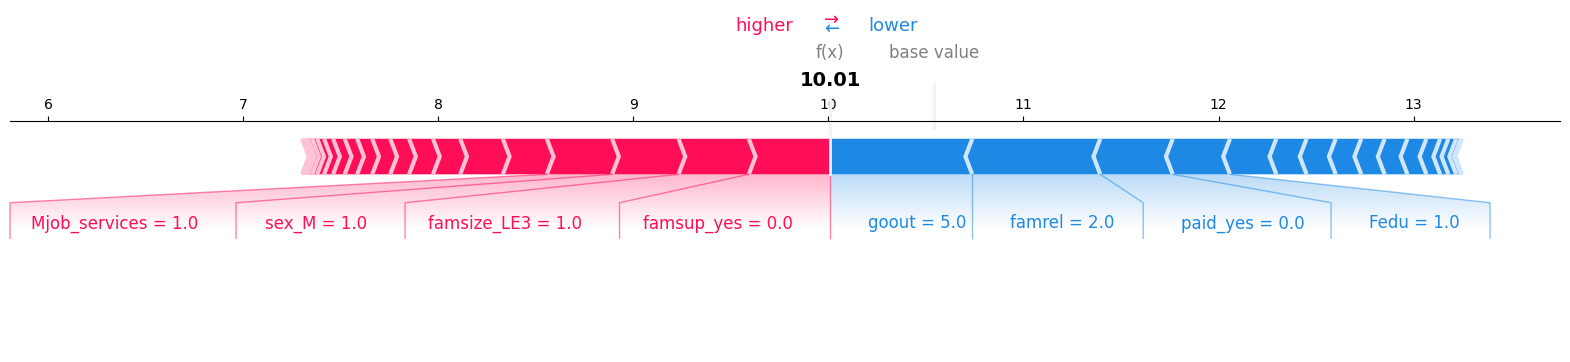

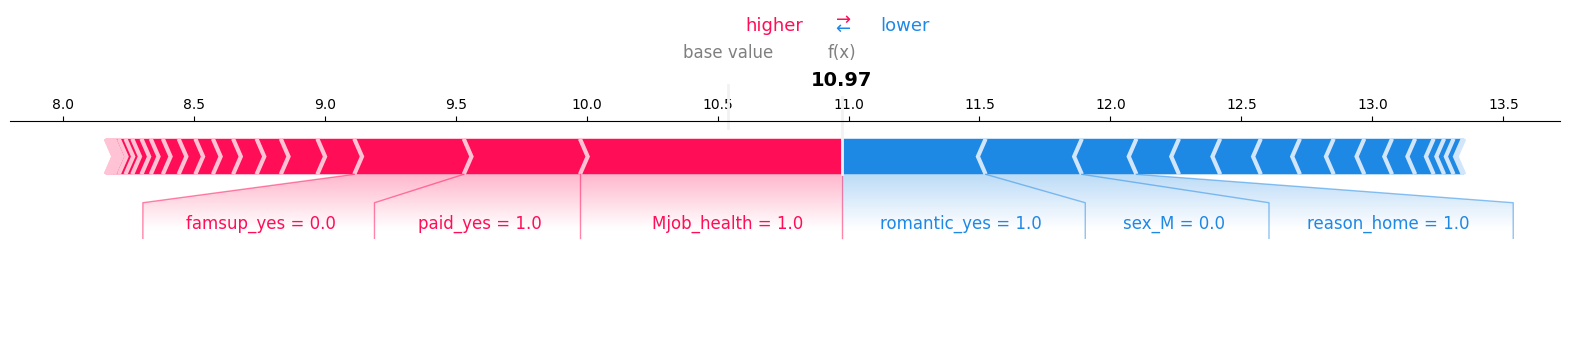

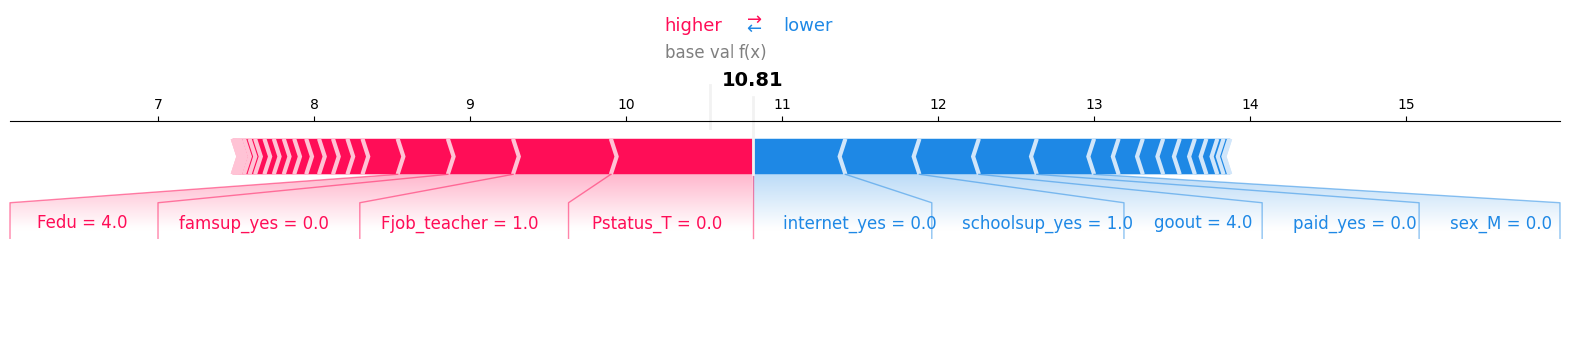

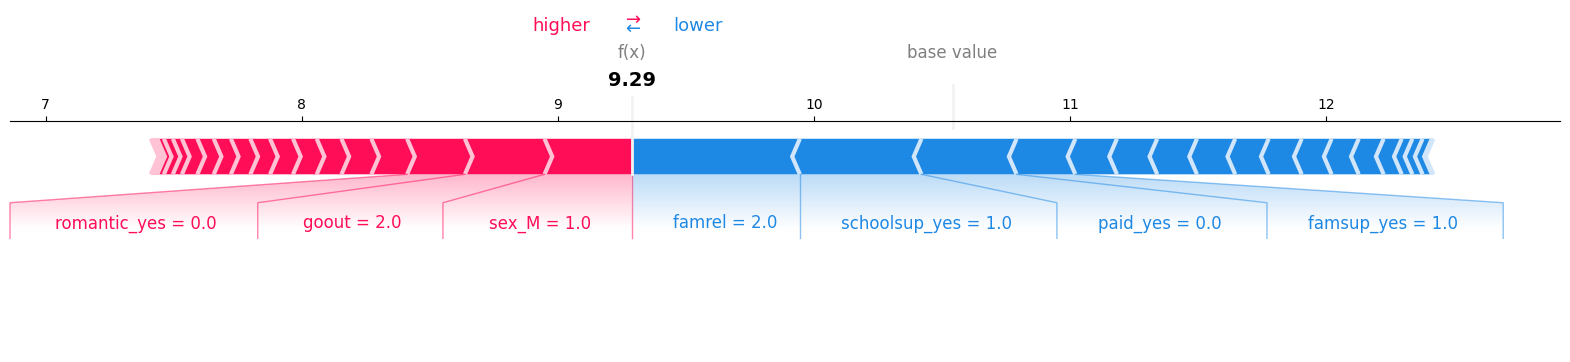

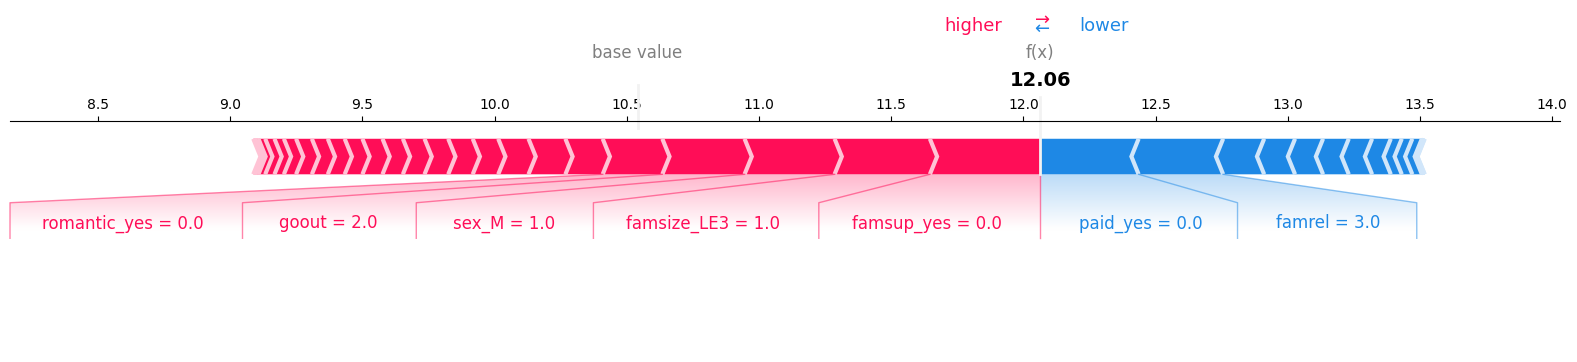

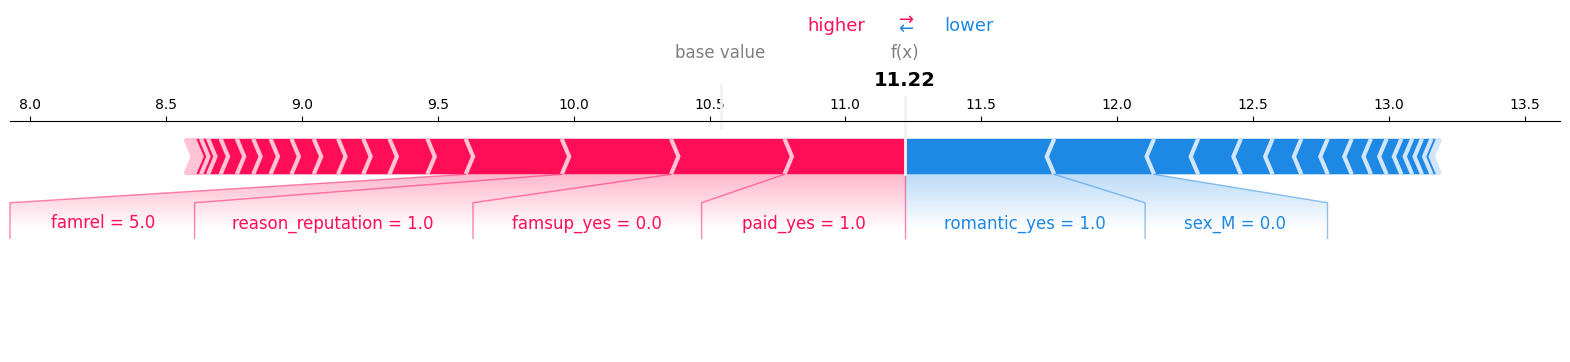

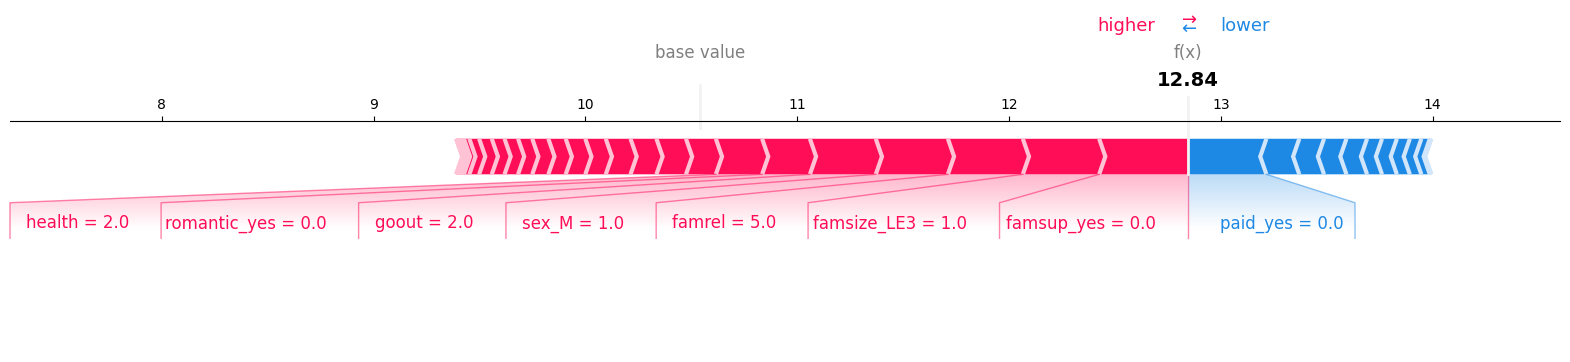

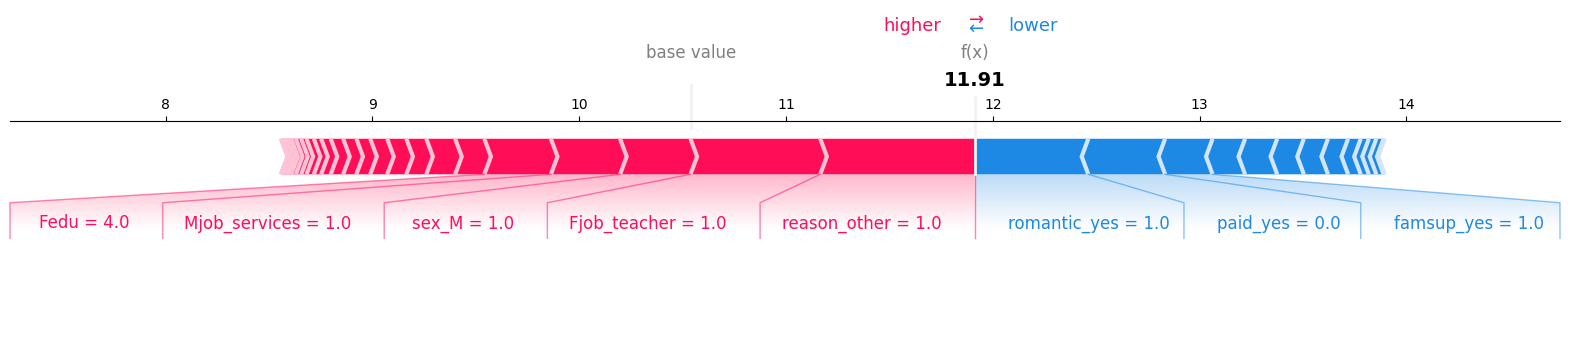

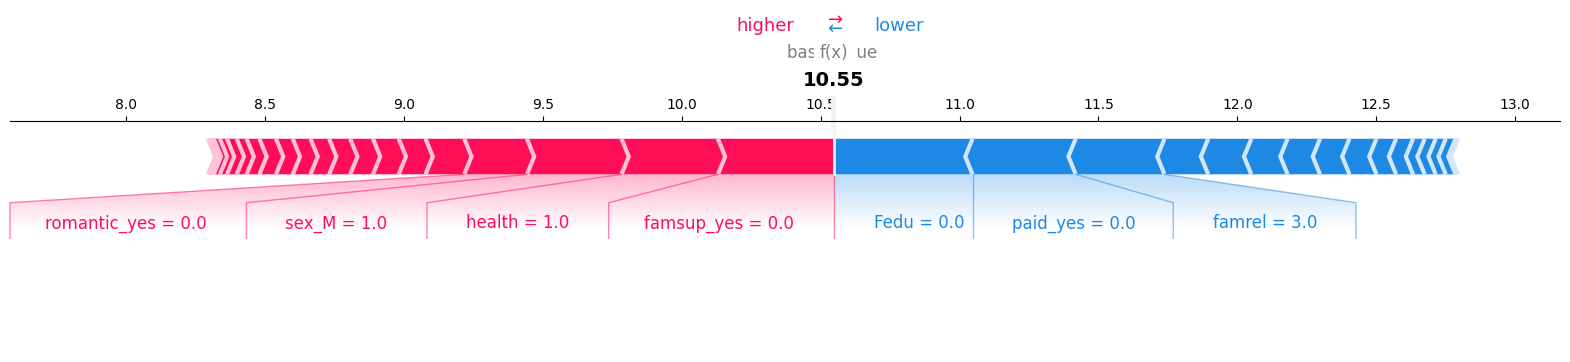

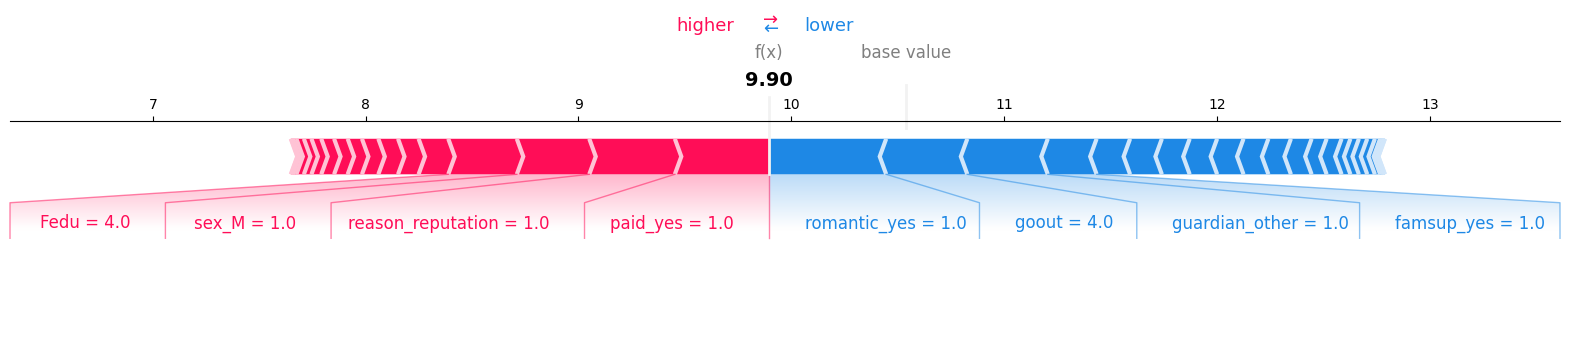

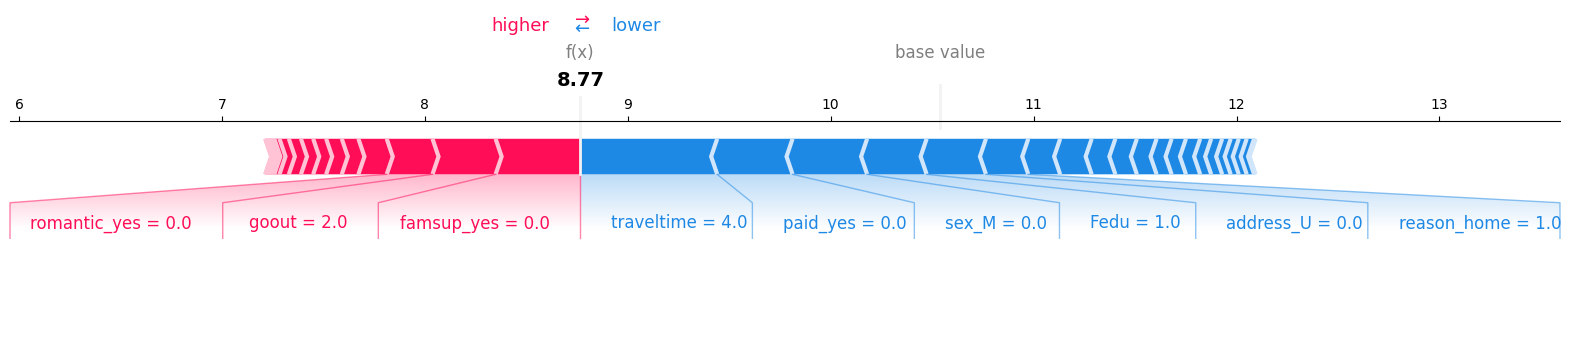

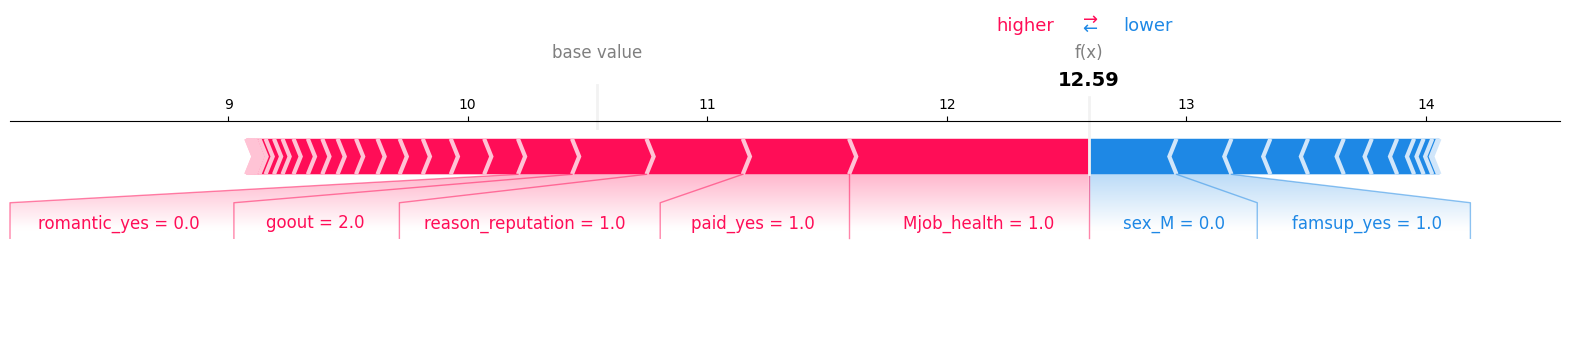

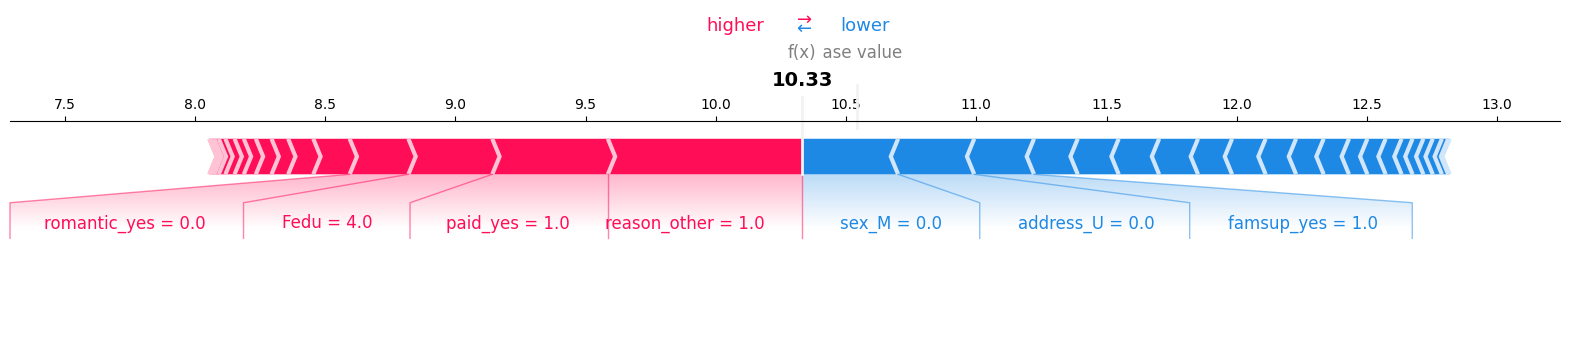

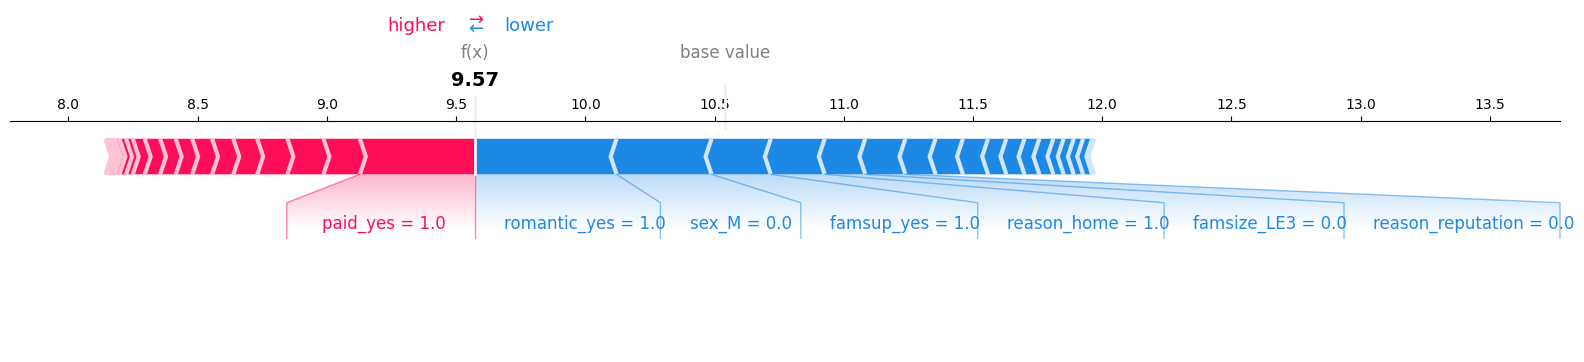

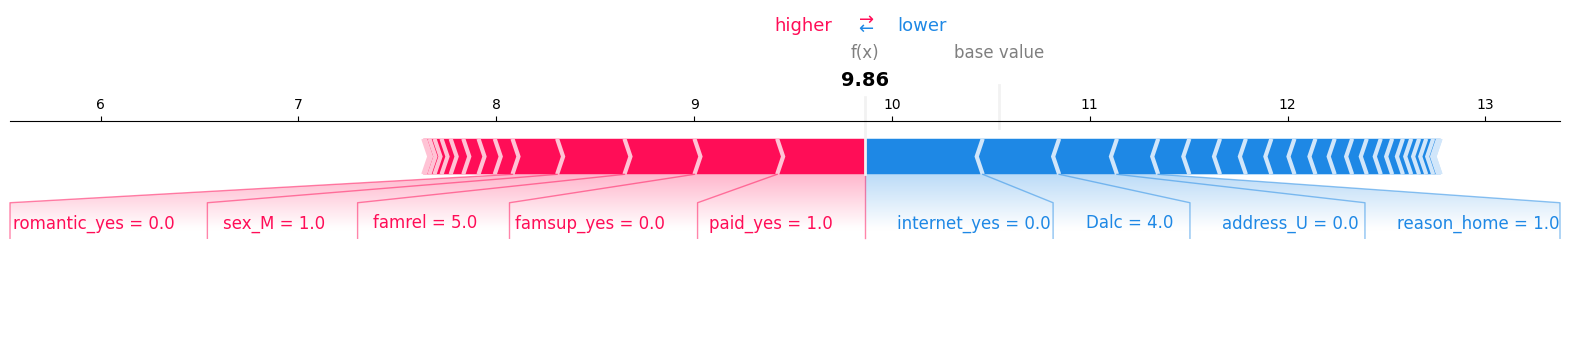

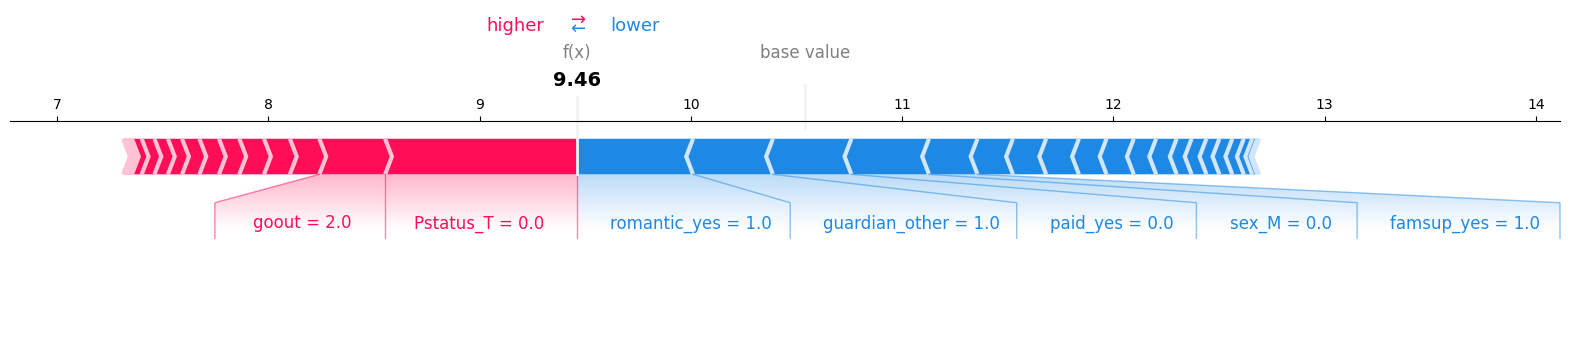

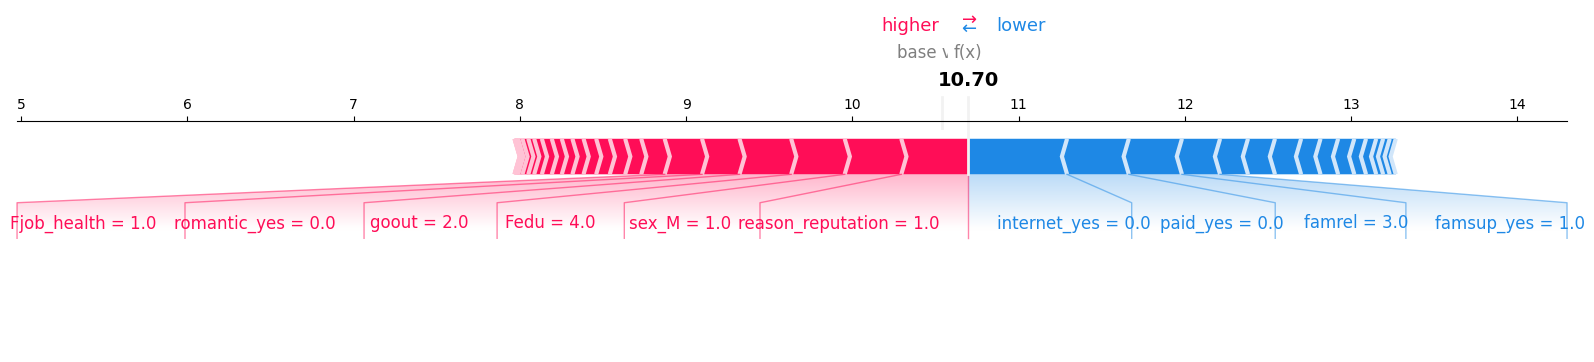

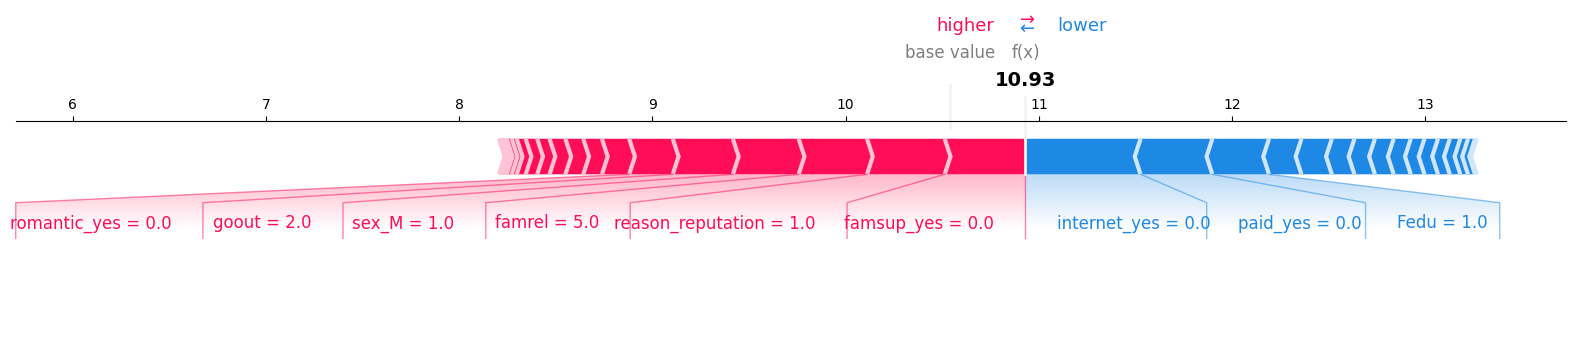

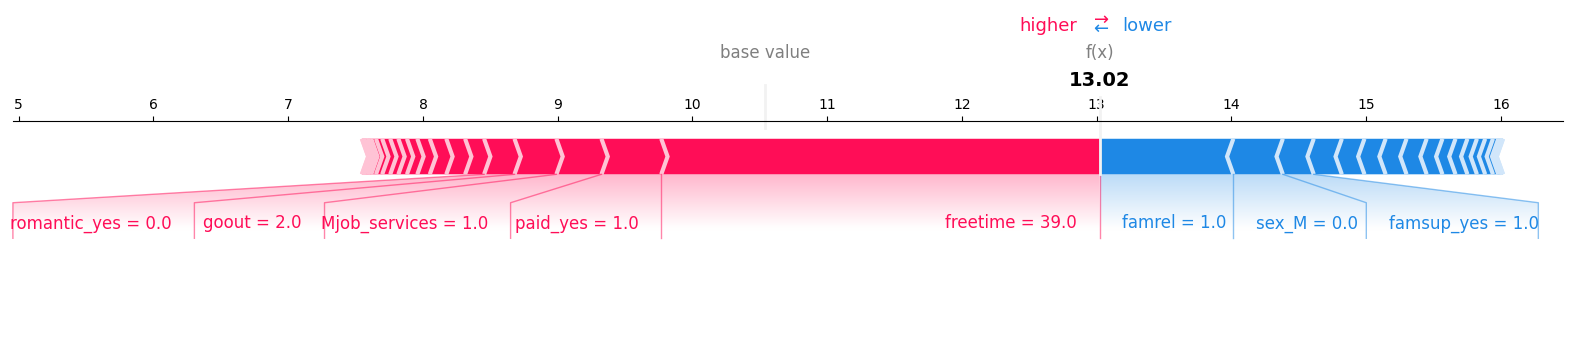

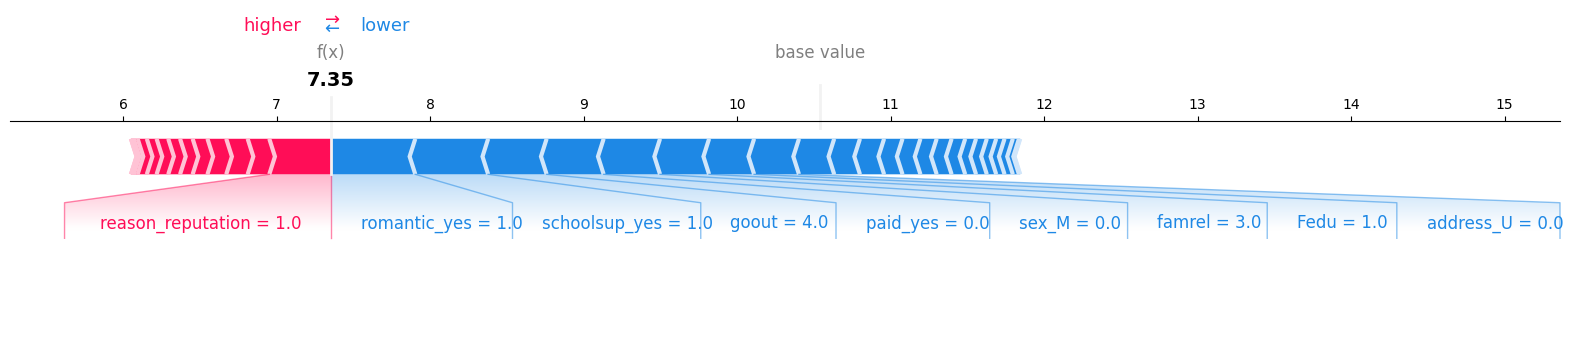

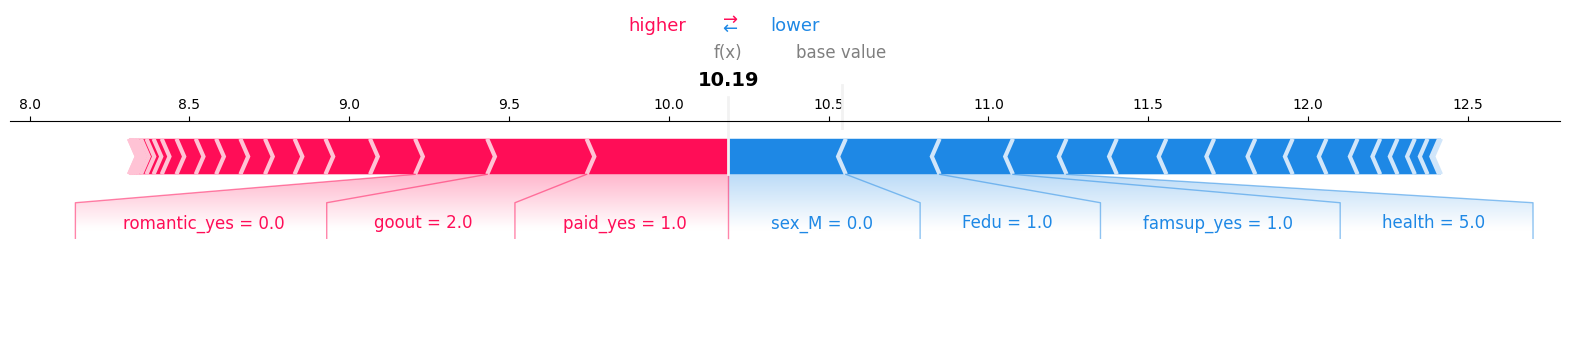

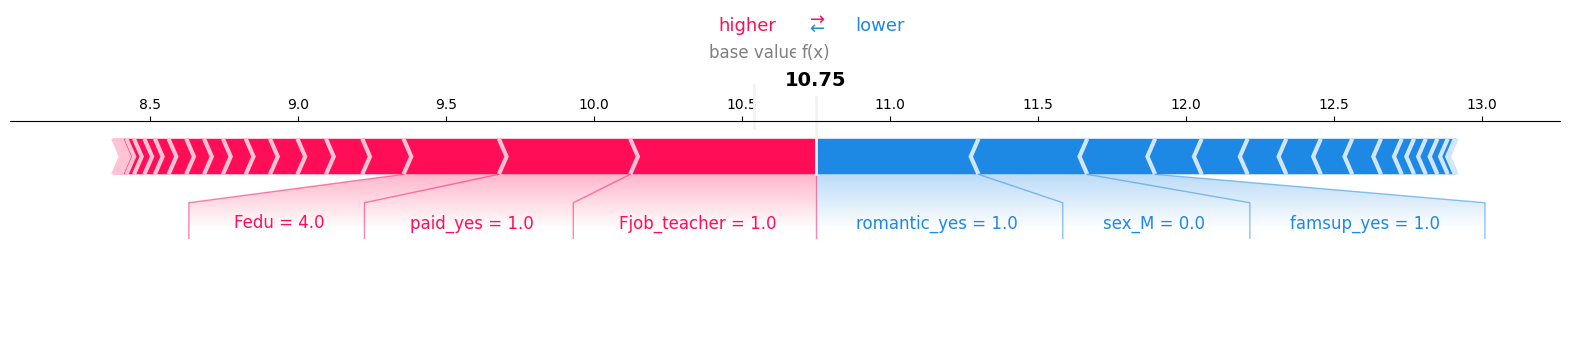

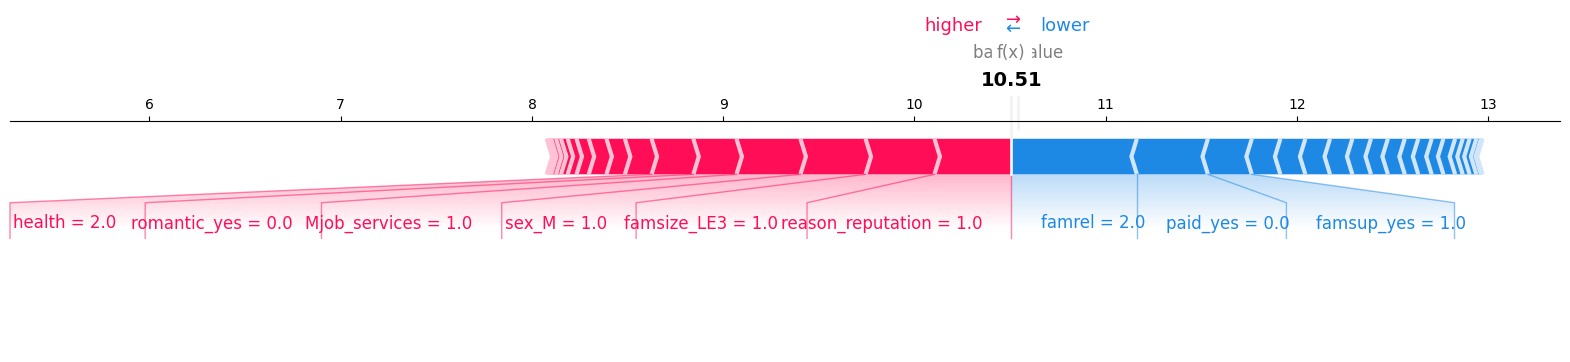

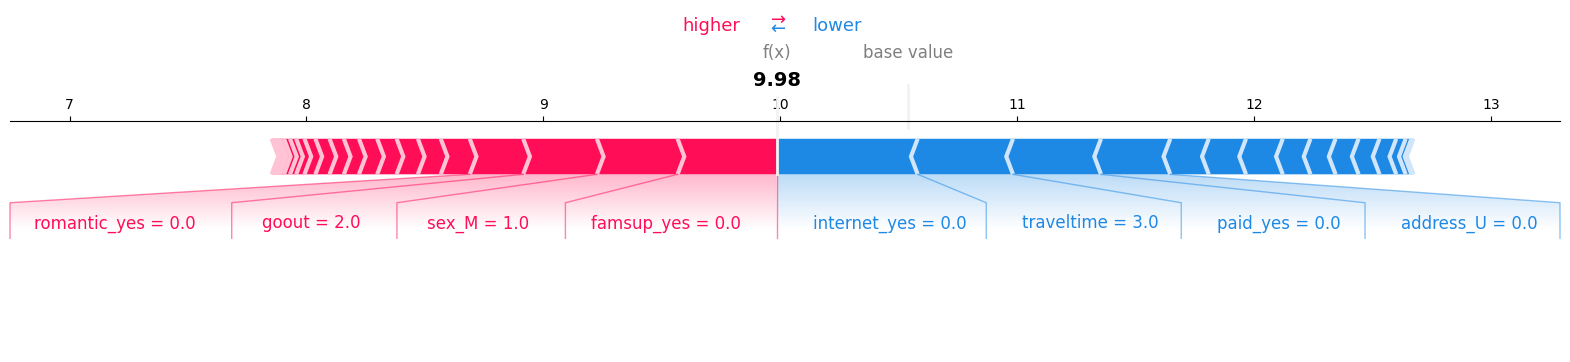

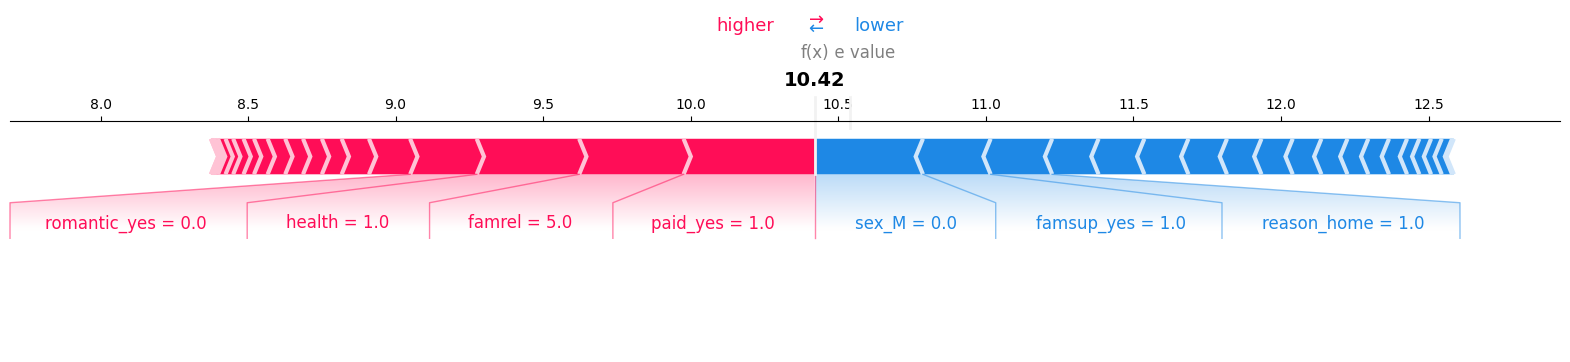

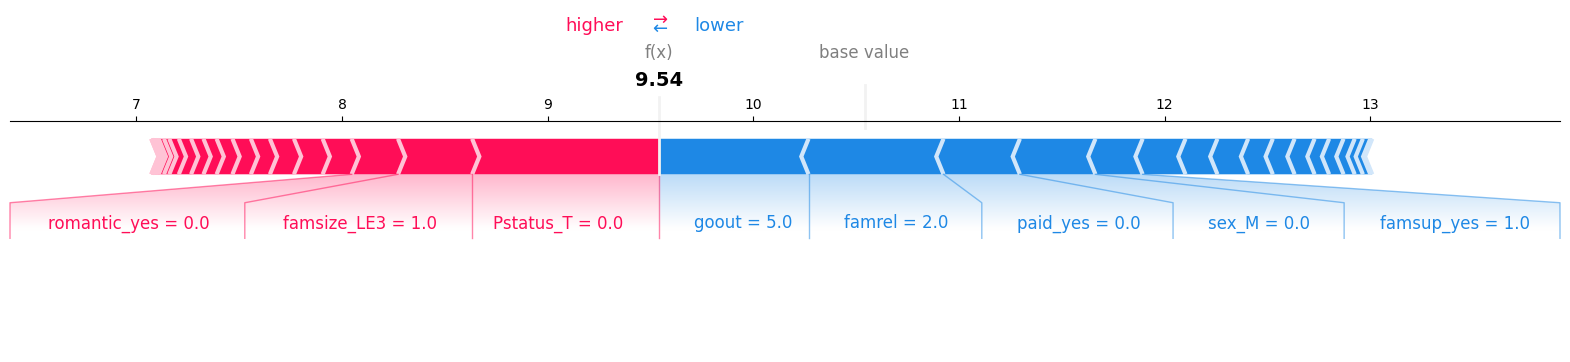

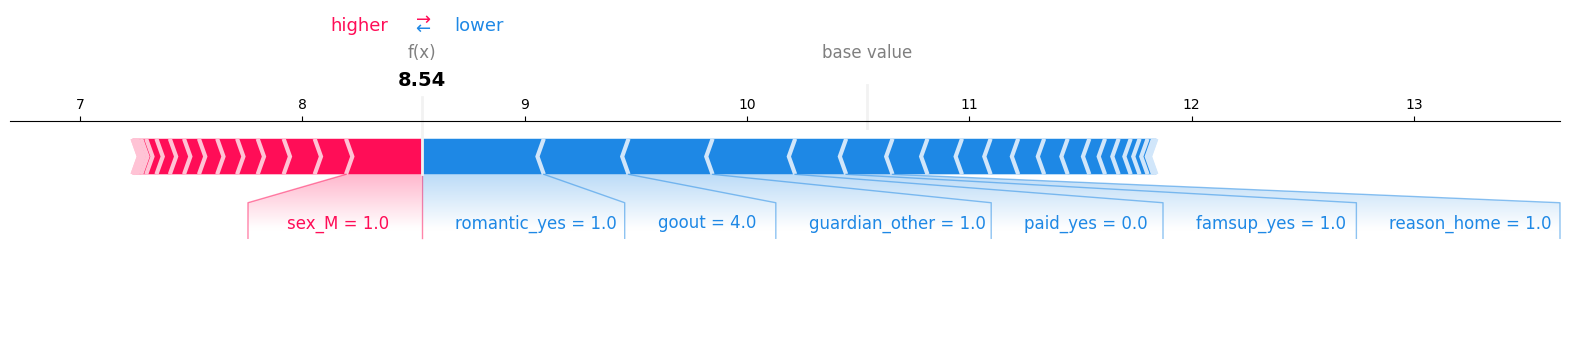

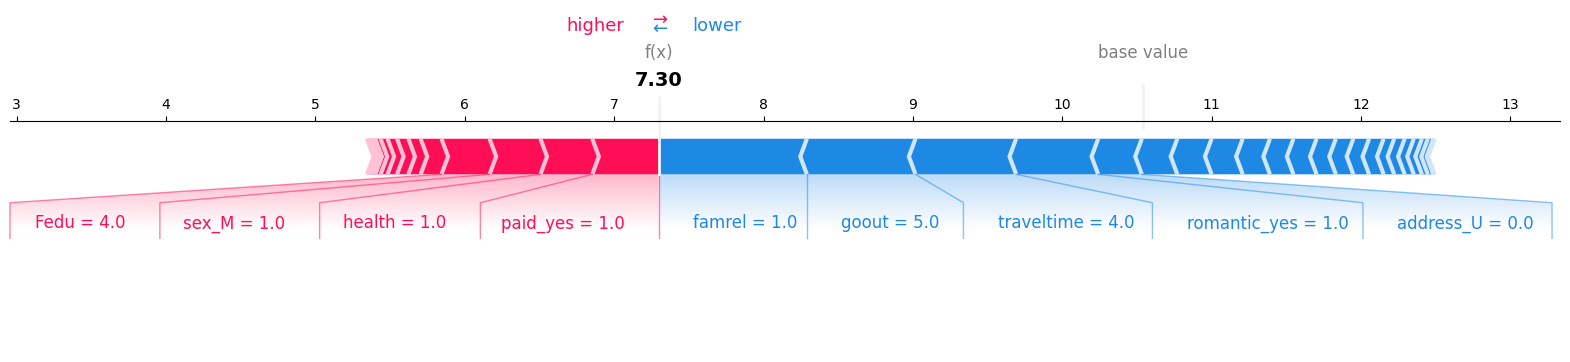

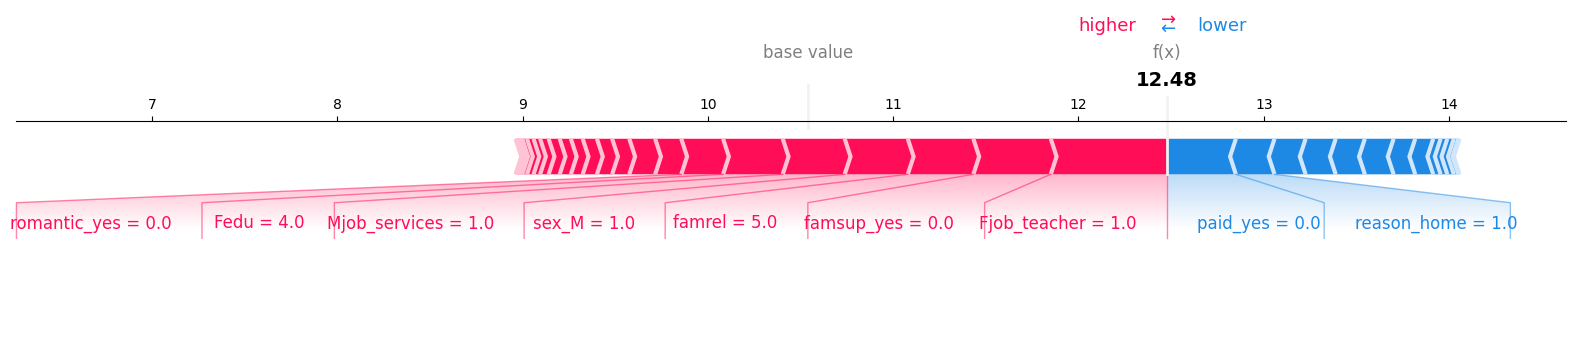

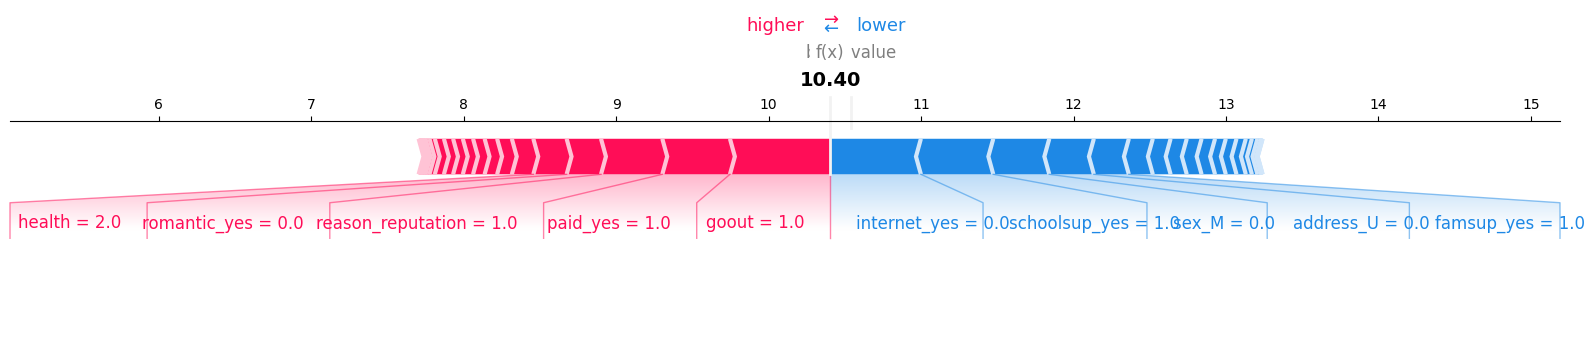

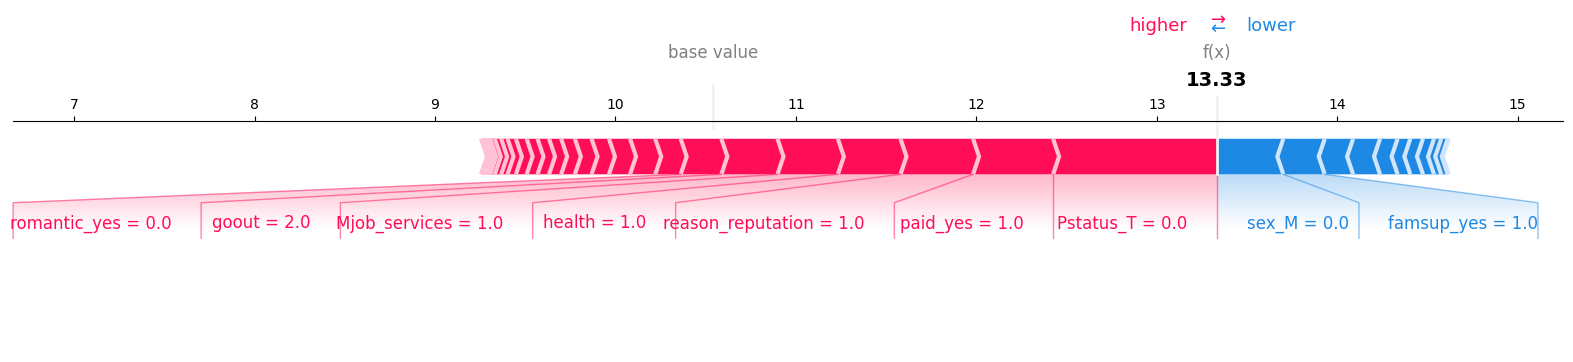

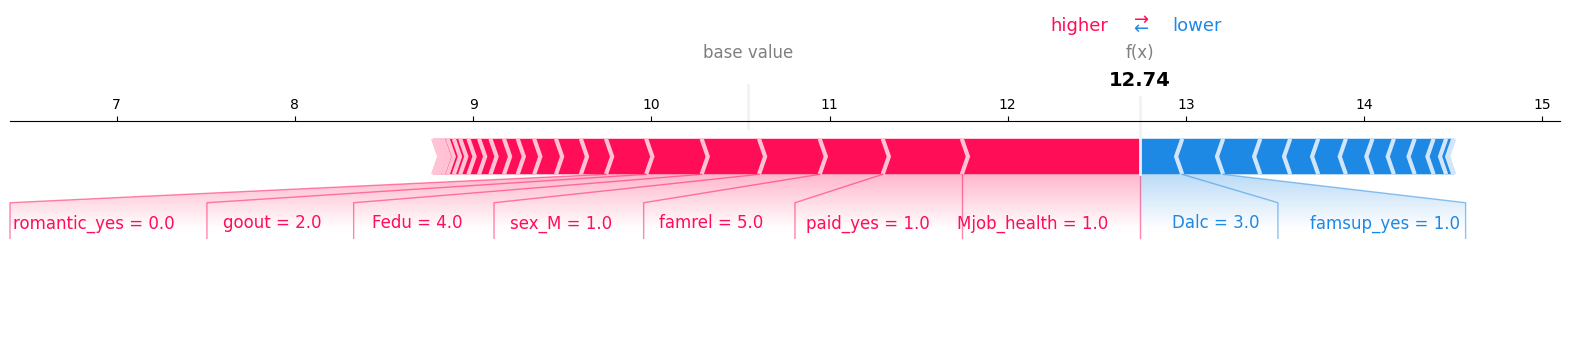

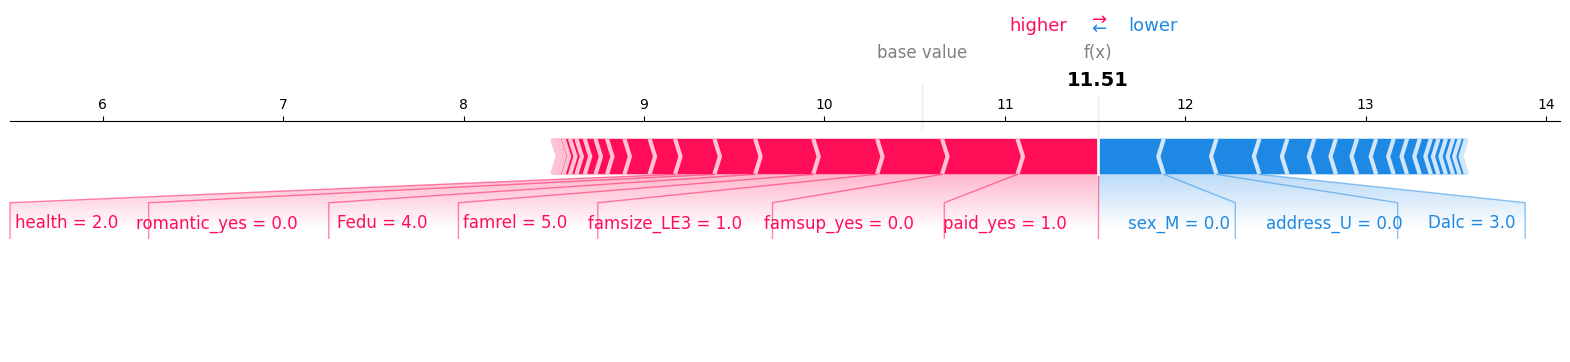

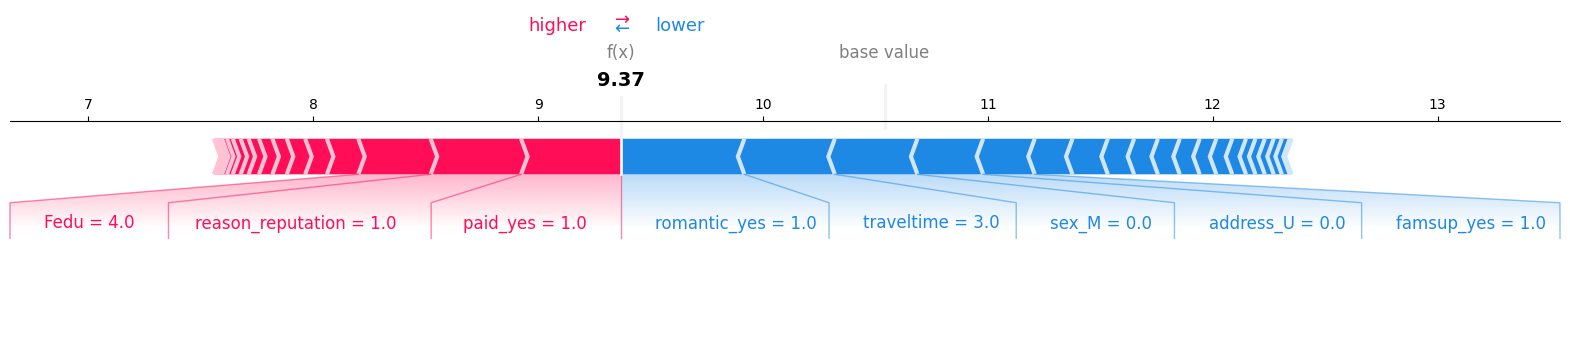

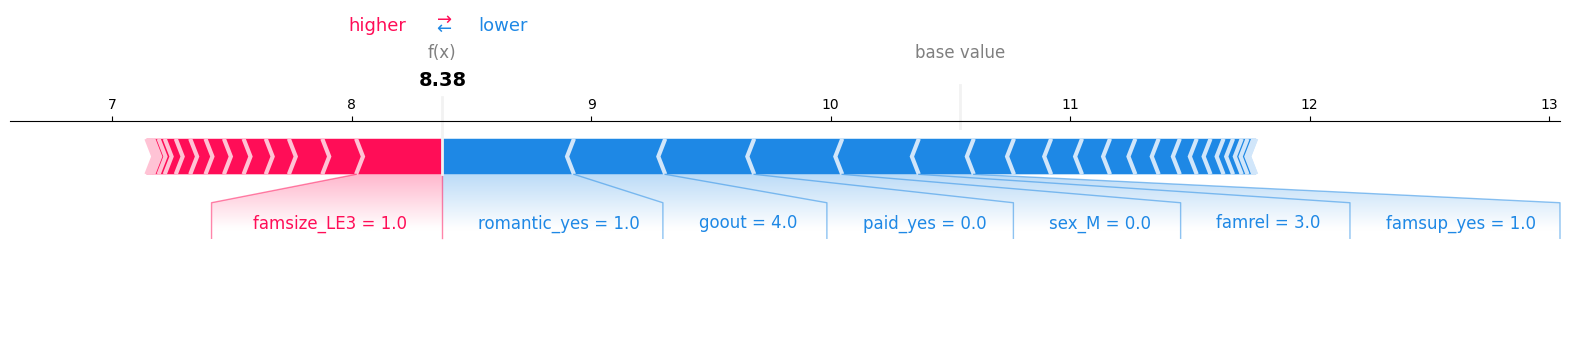

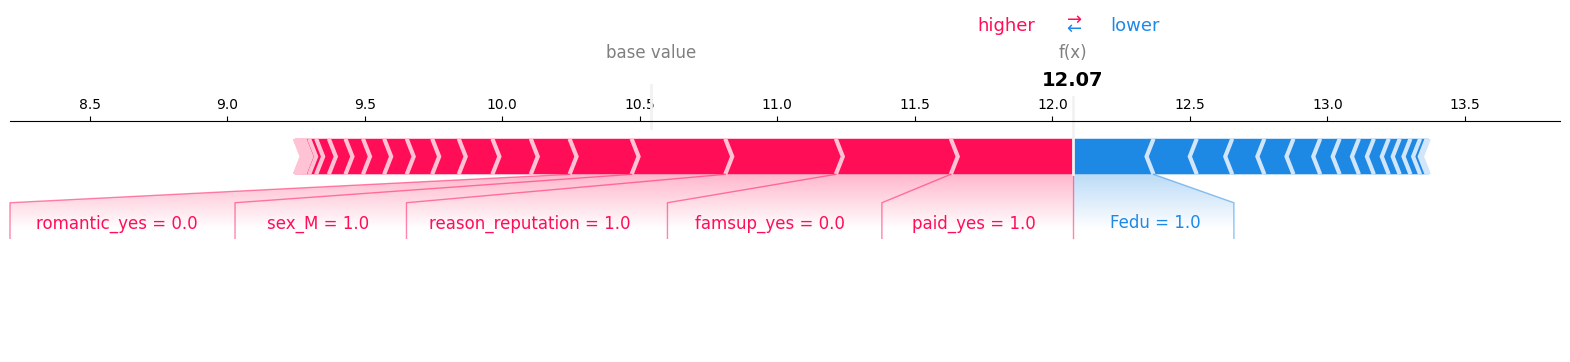

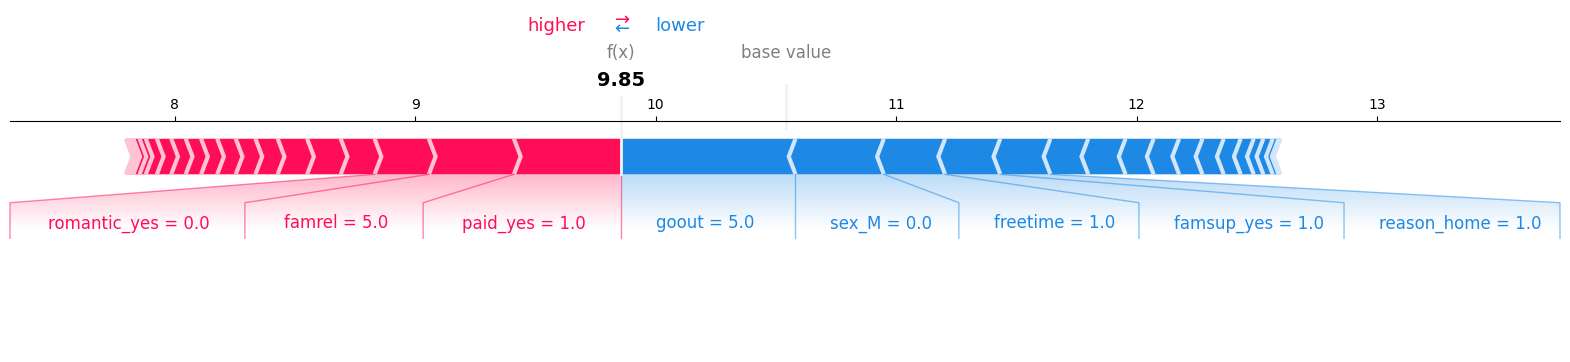

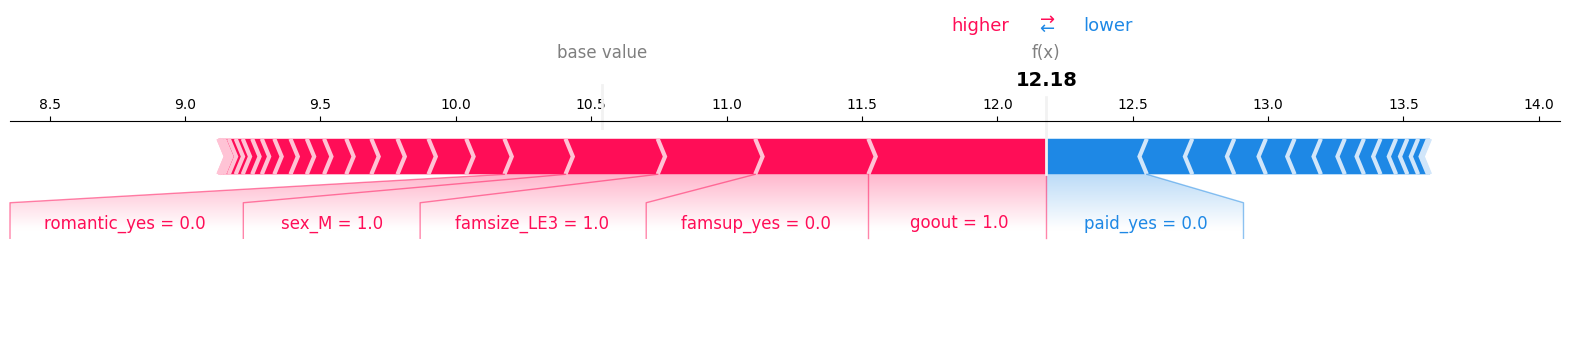

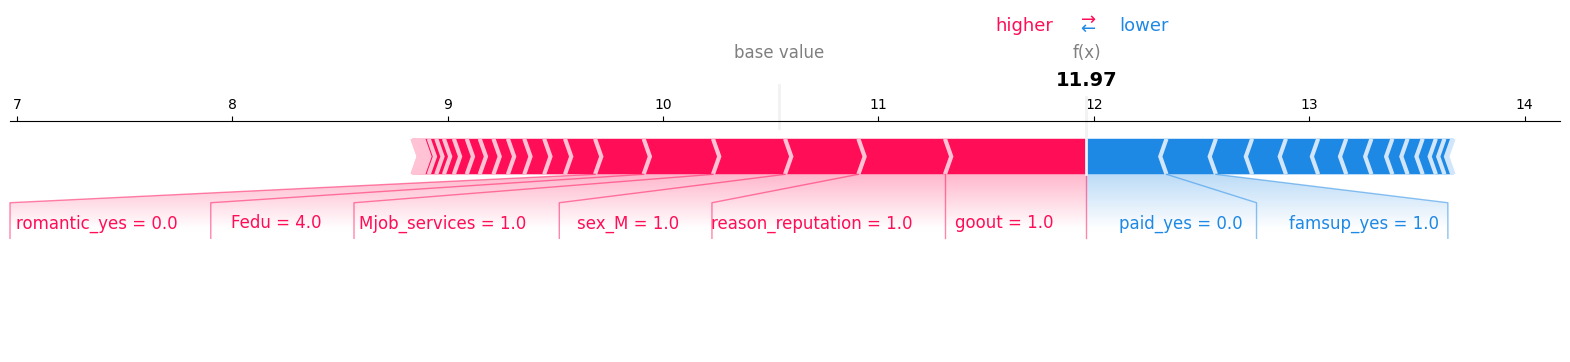

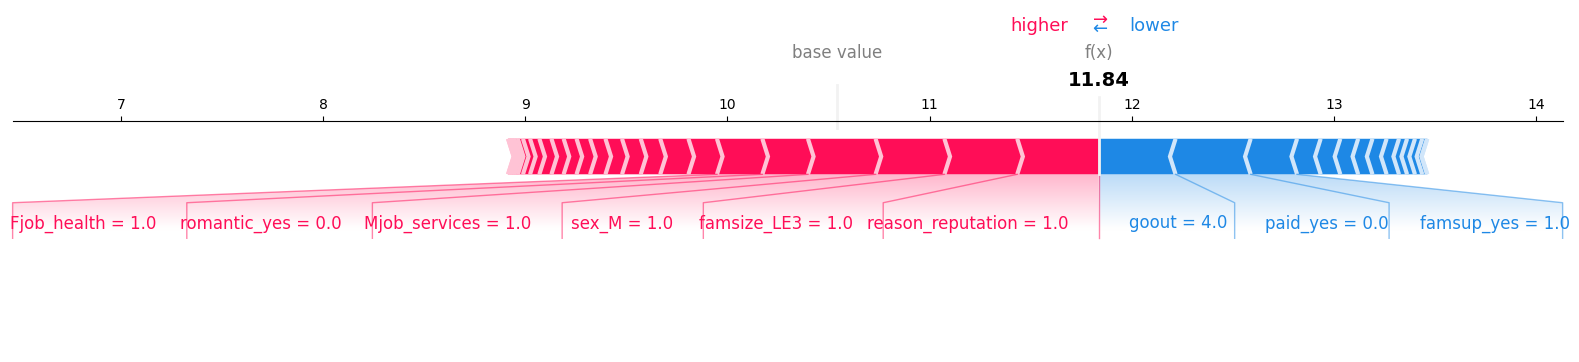

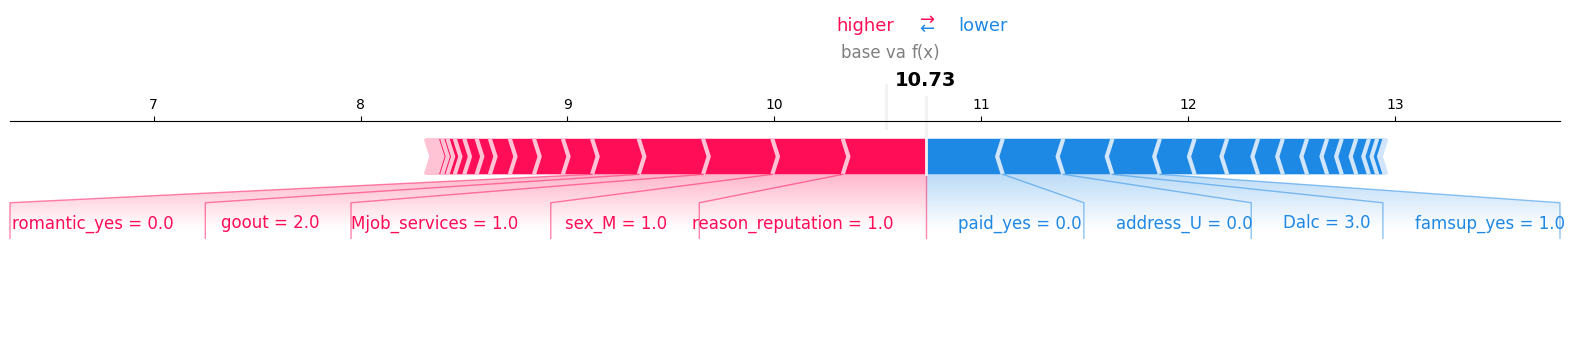

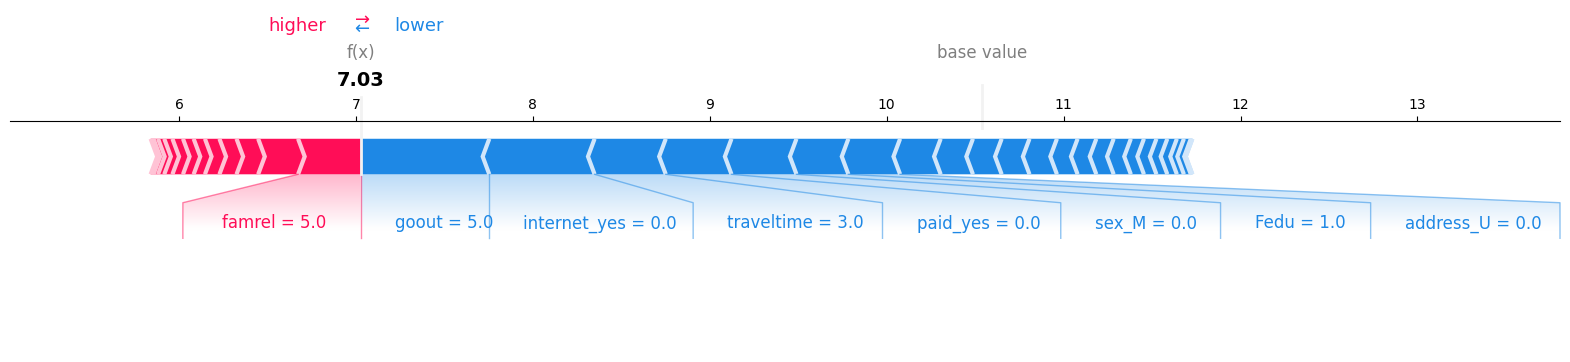

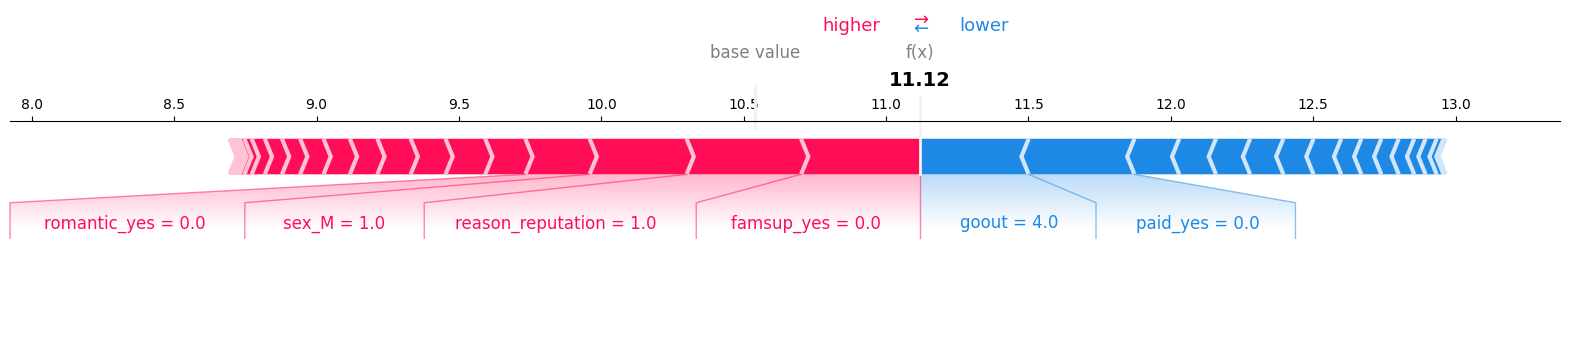

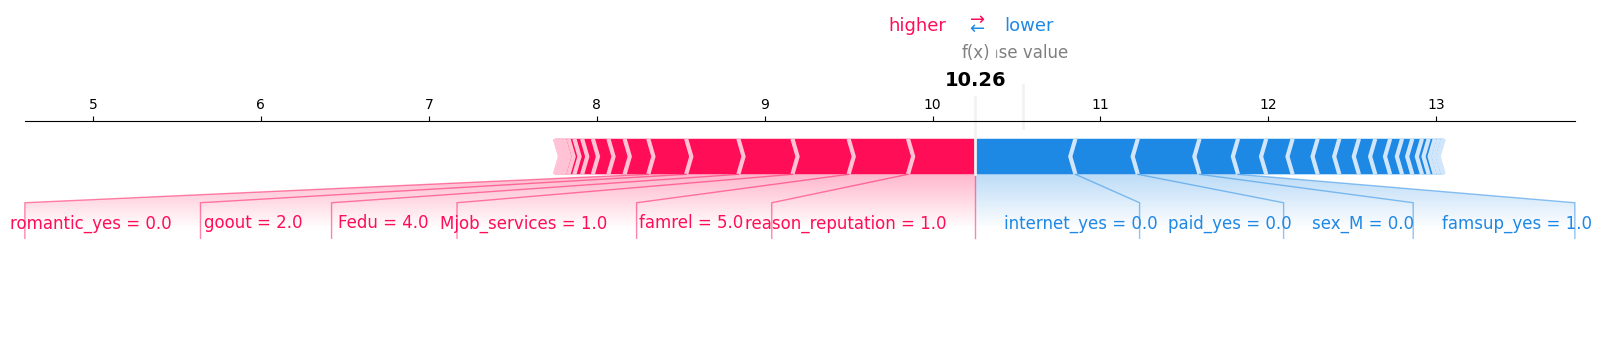

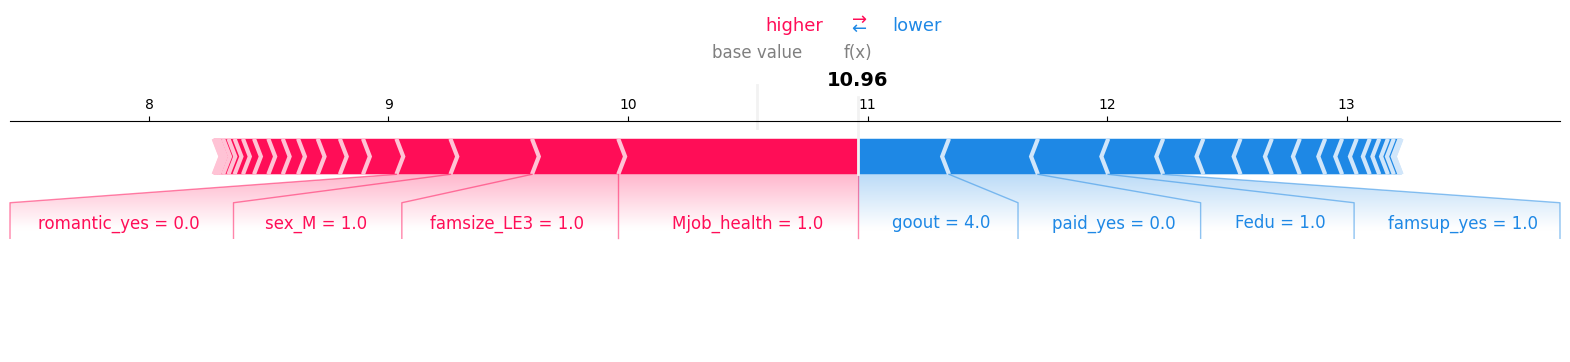

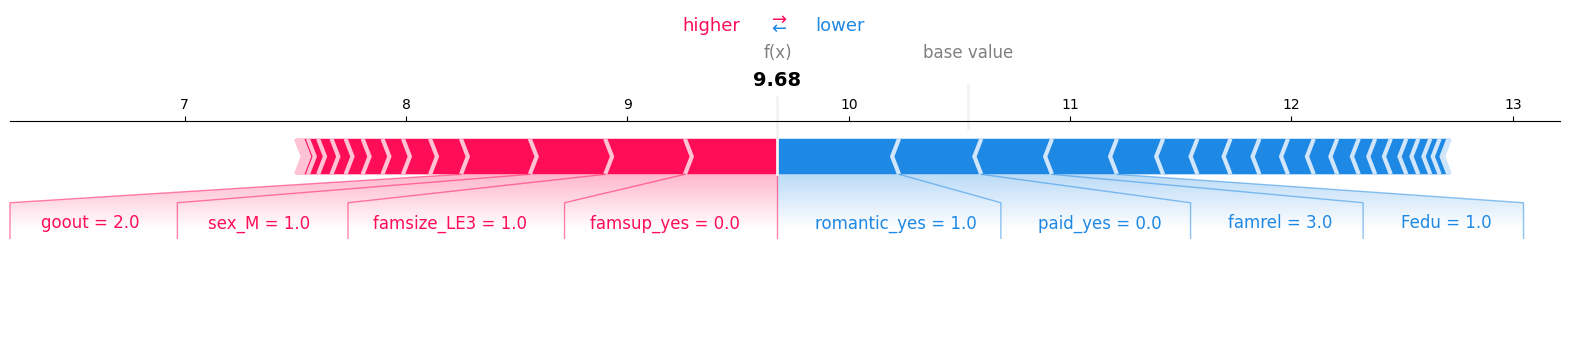

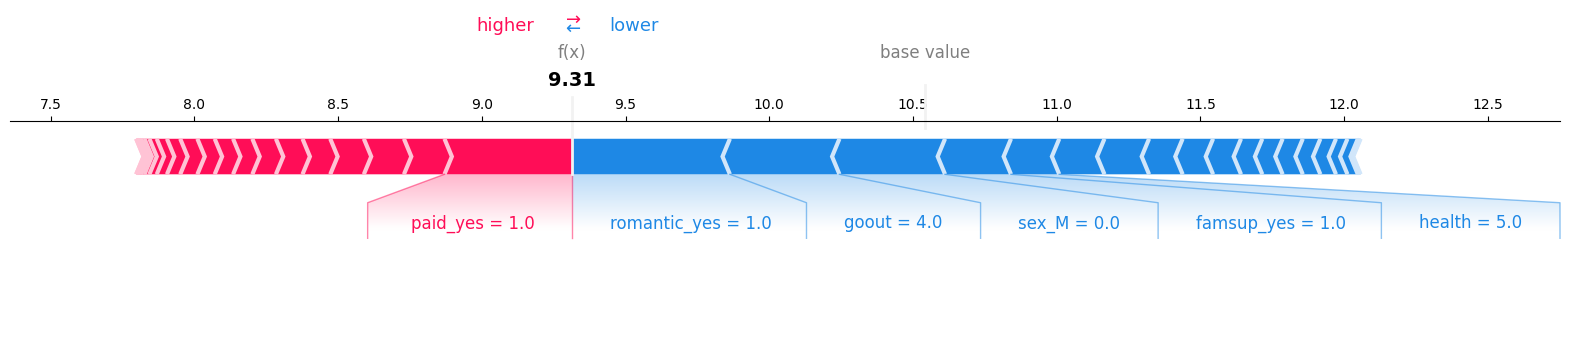

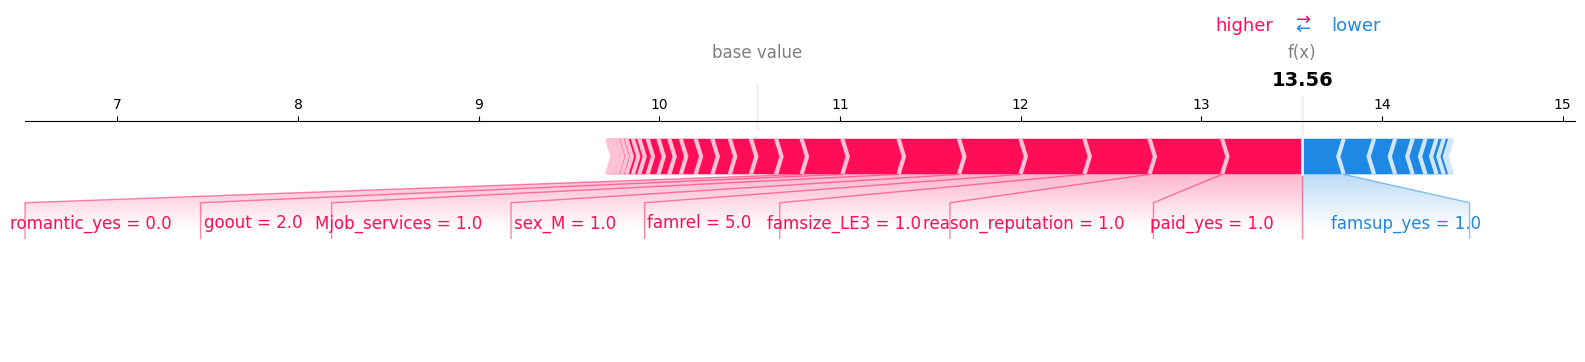

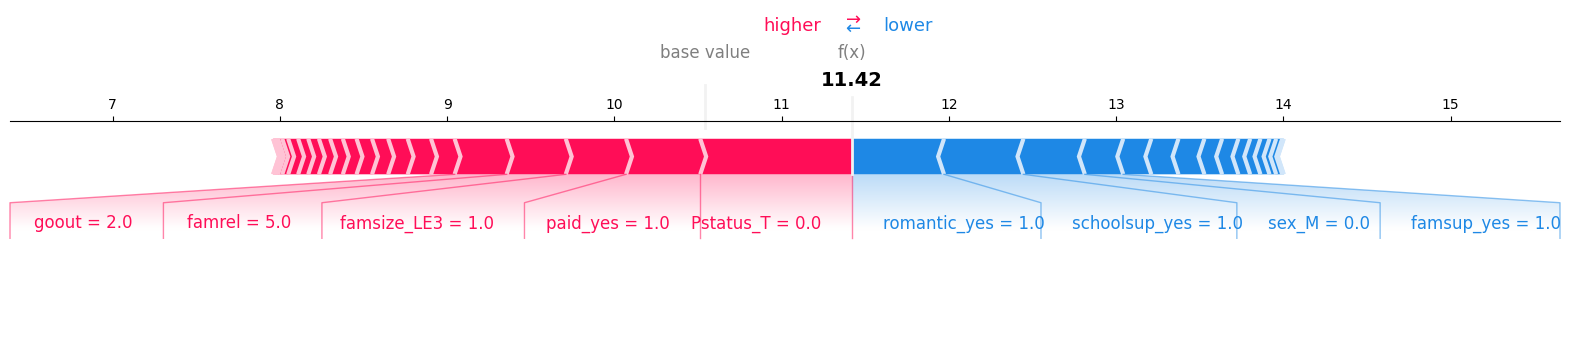

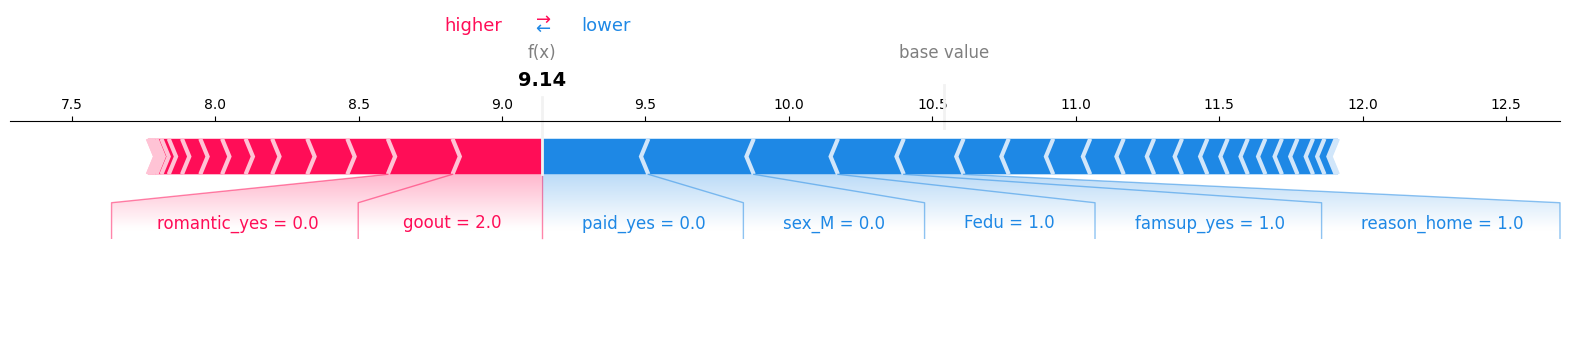

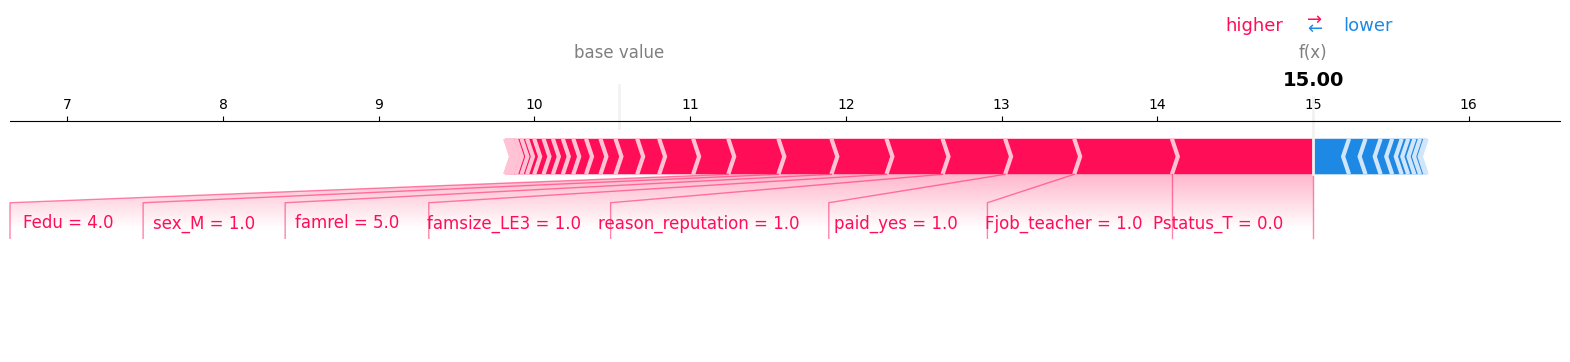

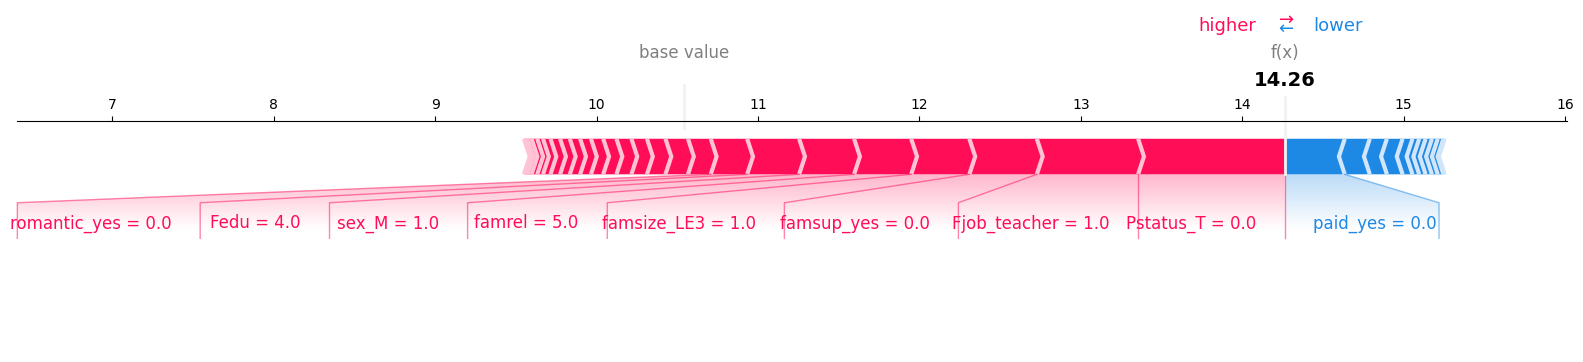

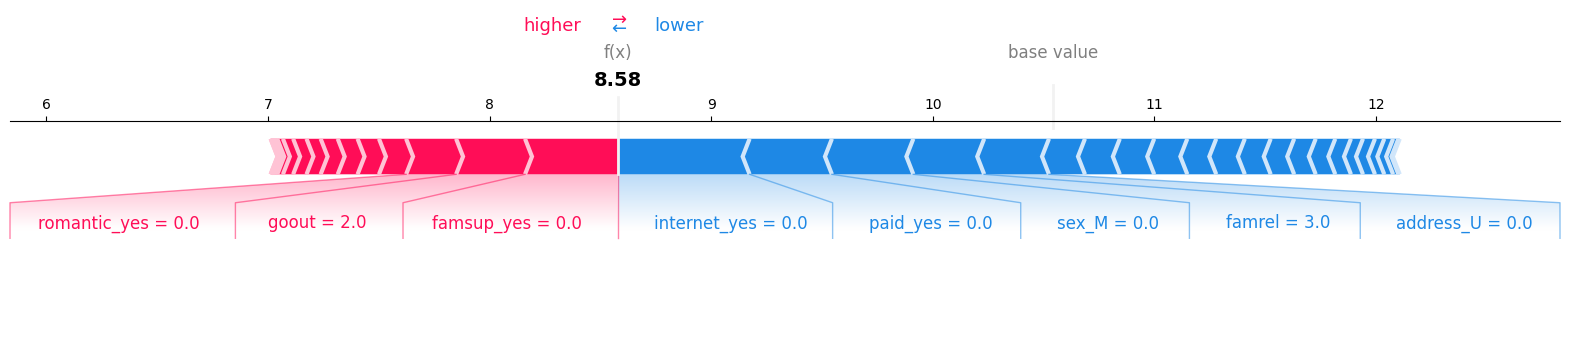

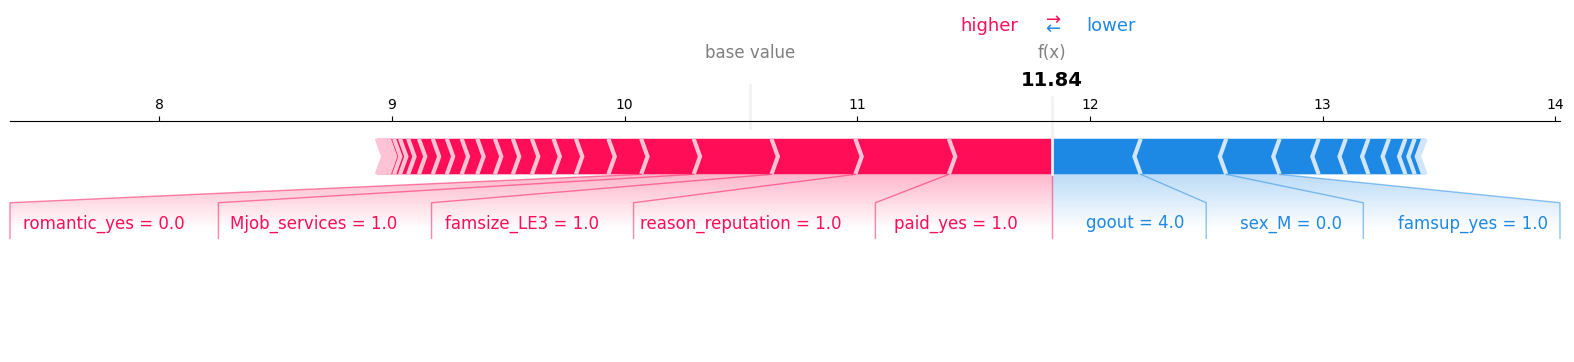

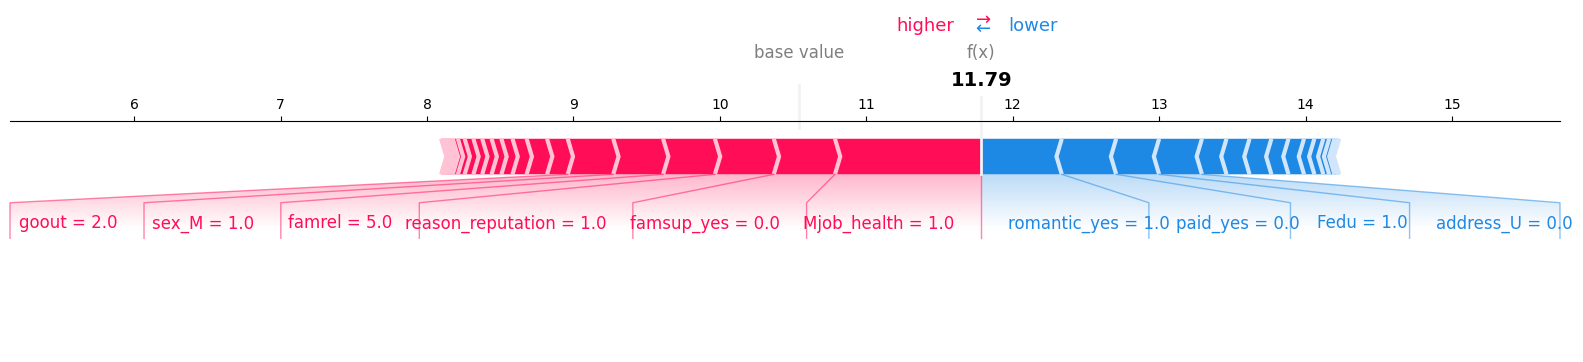

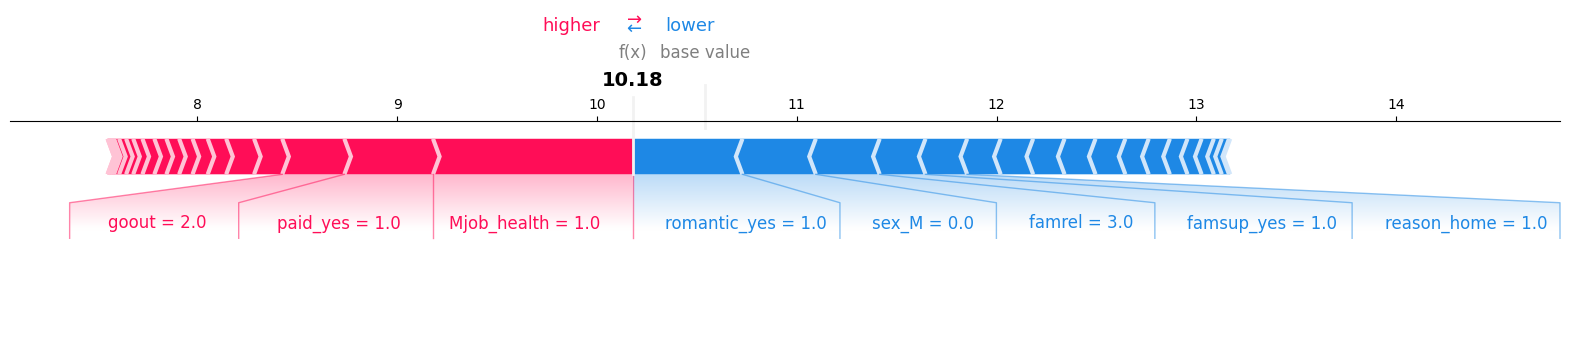

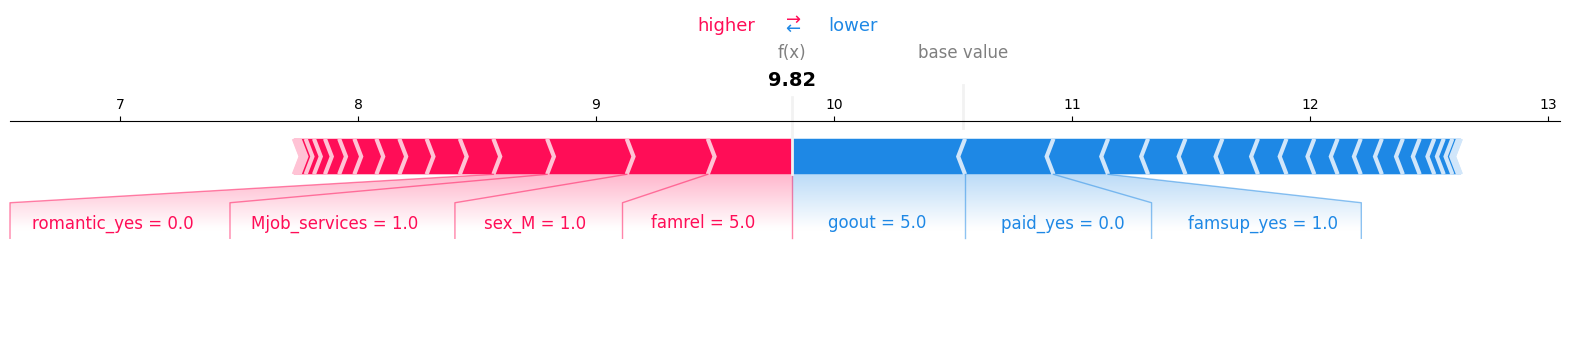

Generating SHAP summary for Ridge Regression...


  0%|          | 0/79 [00:00<?, ?it/s]

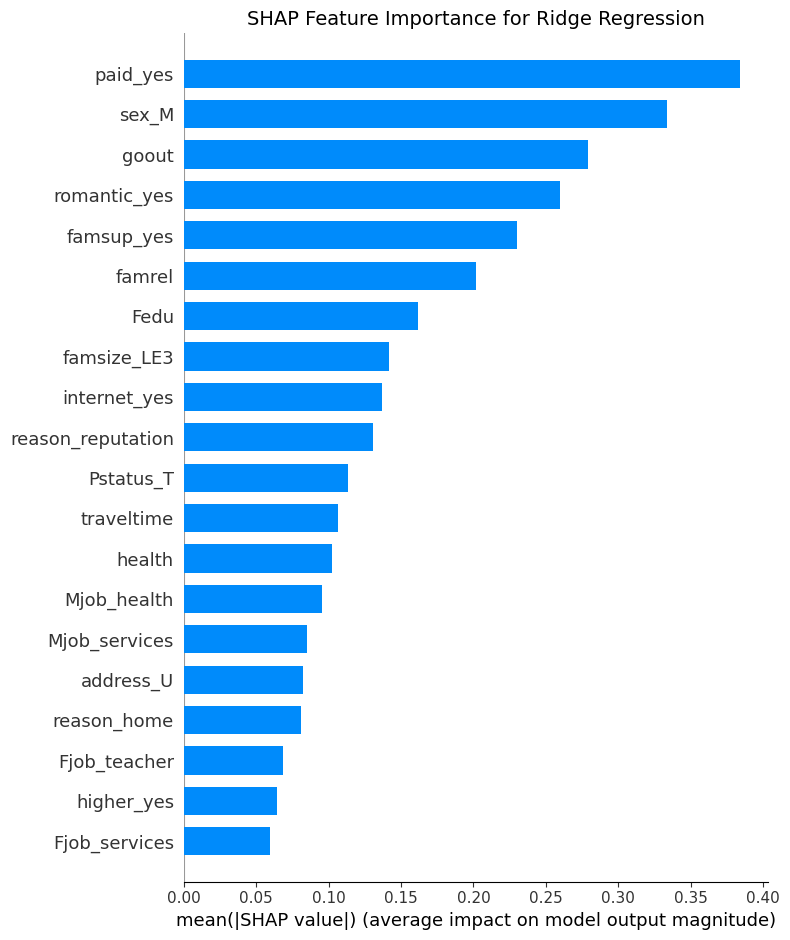

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [113.43746311374575],
                         'ridge__solver': ['auto', 'svd', 'sag']},
             scoring='neg_mean_absolute_error', verbose=2)

In [38]:
#Ridge Regeression prediction
finalPred.RidgeRegression()